# Topic Modeling on Petition Data

Understanding a large collection of petitions can be achived through topic modeling. This technique has the capability of accurately asigning high level categories to petitions, allowing people to better understand, make sense of, and interpret the content.

The goal of this work is to come up with some petition topics can easily be interpreted by us. The resulting topics can be further used to discovering hidden structure: find similar petitions, visualize a set of petitions, analyze the trend of petitioning...

##  Read data

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

%matplotlib inline

Read petitions dataset from .csv file (transformed from .sql file). Petitions whose body have less than 50 words are removed.

In [2]:
import csv

doc_complete = []
with open('petitions_complete.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        doc_complete.append(row) 

Define a helper function to covert text to unicode.

In [3]:
def to_unicode(text):
    if type(text) == str:
    # Ignore errors even if the string is not proper UTF-8 or has
    # broken marker bytes.
    # Python built-in function unicode() can do this.
        return unicode(text, "utf-8", errors="ignore")
    else:
        # Assume the value object has proper __unicode__() method
        return unicode(text)

In [4]:
train_texts = []
for doc in doc_complete:
    text = to_unicode(doc['title']) + " " + to_unicode(doc['body'])
    text = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
    train_texts.append(text)

In [5]:
titles = []
for doc in doc_complete:
    text = to_unicode(doc['title'])
    text = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
    titles.append(text)
    
1.0 * sum([len(title) for title in titles]) / len(titles)

11.192673992673992

In [6]:
bodys = []
for doc in doc_complete:
    text = to_unicode(doc['body'])
    text = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
    bodys.append(text)
    
1.0 * sum([len(body) for body in bodys]) / len(bodys)

83.08376068376069

In [7]:
len(train_texts)

4095

In [8]:
sum([len(train_text) for train_text in train_texts])

386062

In [9]:
max([len(train_text) for train_text in train_texts])

144

In [10]:
min([len(train_text) for train_text in train_texts])

2

In [11]:
flat_list = [item for sublist in train_texts for item in sublist]

In [12]:
def getUniqueWords(allWords) :
    uniqueWords = [] 
    for i in allWords:
        if not i in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords

uniqueWords = getUniqueWords(flat_list);

In [13]:
len(uniqueWords)

21403

In [14]:
train_texts[0]

[u'grant',
 u'voters',
 u'the',
 u'ability',
 u'vote',
 u'for',
 u'the',
 u'president',
 u'the',
 u'united',
 u'states',
 u'dissolving',
 u'the',
 u'electoral',
 u'college',
 u'the',
 u'elections',
 u'and',
 u'produced',
 u'electoral',
 u'college',
 u'winner',
 u'who',
 u'did',
 u'not',
 u'receive',
 u'the',
 u'plurality',
 u'the',
 u'nationwide',
 u'popular',
 u'vote',
 u'that',
 u'the',
 u'american',
 u'people',
 u'did',
 u'not',
 u'get',
 u'the',
 u'president',
 u'democracy',
 u'should',
 u'have',
 u'selected',
 u'due',
 u'the',
 u'way',
 u'electoral',
 u'votes',
 u'are',
 u'allocated',
 u'candidates',
 u'have',
 u'strong',
 u'incentive',
 u'focus',
 u'their',
 u'campaigns',
 u'swing',
 u'states',
 u'with',
 u'many',
 u'voters',
 u'such',
 u'florida',
 u'and',
 u'neglect',
 u'states',
 u'such',
 u'texas',
 u'which',
 u'not',
 u'swing',
 u'due',
 u'necessary',
 u'rounding',
 u'errors',
 u'when',
 u'allocating',
 u'votes',
 u'members',
 u'sparsely',
 u'populated',
 u'state',
 u'effect

In [15]:
from collections import Counter
flat_texts = [j for i in train_texts for j in i]
top_words = Counter(flat_texts).most_common(1000)
for word, frequency in top_words:
    print("%s %d" % (word, frequency))

the 27789
and 14794
for 6106
that 4788
this 3682
are 3569
with 2711
have 2542
not 2413
from 2399
their 2249
our 2213
has 1933
people 1921
all 1857
they 1664
states 1543
government 1475
was 1418
who 1336
will 1335
president 1298
united 1227
should 1199
his 1125
these 1106
been 1033
obama 991
federal 986
more 975
white 965
which 916
can 900
you 900
law 892
them 891
state 880
any 870
american 848
time 833
would 832
petition 817
many 795
being 785
other 781
but 779
national 753
there 753
one 749
act 726
help 700
rights 693
children 691
only 685
were 684
america 681
stop 680
against 680
public 662
than 659
its 643
new 635
out 627
years 622
over 622
citizens 618
please 605
make 596
into 594
support 585
country 581
need 557
her 554
military 553
administration 536
now 535
world 532
when 532
year 528
right 523
those 519
use 514
about 505
also 499
health 488
congress 478
under 471
day 459
allow 455
such 452
house 451
without 449
because 443
americans 438
life 437
most 430
anti 429
what 429
while

## Preprocess the data

This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
* Stopword removal using NLTK's english stopwords dataset.
* Bigram collocation detection (frequently co-occuring tokens) using gensim's Phrases. This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
* Lemmatization (using gensim's lemmatize) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [16]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection
bigram[['new', 'york', 'example']]

2017-12-11 09:20:49,058 : INFO : collecting all words and their counts
2017-12-11 09:20:49,060 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-12-11 09:20:49,792 : INFO : collected 223814 word types from a corpus of 386062 words (unigram + bigrams) and 4095 sentences
2017-12-11 09:20:49,793 : INFO : using 223814 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[u'new_york', u'example']

In [17]:
from nltk.corpus import stopwords 
from gensim.utils import lemmatize
import string

# clean strings
stops = set(stopwords.words('english'))
exclude = set(string.punctuation) 
# manualy created ignore word list
ignore = ["get","country","obama","without","right","government","president","cause","end","becomes","men","say","including","take","ask","stop","support","1","want","petition","american","united", "state","thousand", "since","even","million", "hour", "it" ,"could", "mr", "two", "every", "may","new","know", "good", "one", "many", "time", "need", "would", "way", "u", "year", "also", "day", "make", "made", "people", "use", "must", "found", "please", "help"]
def process_texts(texts):
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    texts = [[word for word in line if word not in exclude] for line in texts]
    texts = [[word for word in line if word not in ignore] for line in texts]
    return texts

Create the training data that will be used for topic model training.

In [18]:
%%time
train_texts = process_texts(train_texts)

CPU times: user 41.5 s, sys: 247 ms, total: 41.7 s
Wall time: 41.9 s


In [19]:
len(train_texts)

4095

In [20]:
train_texts[4:6]

[['sex_marriage',
  'nation',
  'iowa',
  'hampshire',
  'new_york',
  'vermont',
  'sex_couple',
  'benefit',
  'couple',
  'sex_marriage',
  'group',
  'person',
  'nation',
  'great_nation',
  'freedom',
  'opportunity',
  'person',
  'take_stand',
  'leader',
  'sex_marriage',
  'nation'],
 ['marijuana',
  'alcohol',
  'person',
  'discussion',
  'life',
  'hundred',
  'billion',
  'policy',
  'goal',
  'rate',
  'drug',
  'access',
  'community',
  'marijuana',
  'alcohol',
  'feel',
  'criminalization',
  'result']]

Finalising our dictionary and corpus

In [21]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

2017-12-11 09:23:01,068 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-12-11 09:23:01,353 : INFO : built Dictionary(11506 unique tokens: [u'sinjar', u'mumps', u'yellow', u'narcotic', u'vani']...) from 4095 documents (total 121230 corpus positions)


In [22]:
# Random seed
random_seed = 1989
state = np.random.RandomState(random_seed)

## Topic modeling using LDA

In [ ]:
%%time
num_topics = 20
iterations=5
passes=5
eval_every = 1

ldamodel = LdaModel(corpus=corpus, id2word=dictionary, random_state=state,
                   num_topics=num_topics, iterations=iterations, passes=passes, eval_every=eval_every)

2017-12-12 11:14:42,433 : INFO : using symmetric alpha at 0.05
2017-12-12 11:14:42,435 : INFO : using symmetric eta at 8.69111767773e-05
2017-12-12 11:14:42,439 : INFO : using serial LDA version on this node
2017-12-12 11:14:44,342 : INFO : running online (multi-pass) LDA training, 20 topics, 5 passes over the supplied corpus of 4095 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 5x with a convergence threshold of 0.001000
2017-12-12 11:14:46,658 : DEBUG : bound: at document #0
2017-12-12 11:14:51,388 : INFO : -14.345 per-word bound, 20811.4 perplexity estimate based on a held-out corpus of 2000 documents with 59457 words
2017-12-12 11:14:51,389 : INFO : PROGRESS: pass 0, at document #2000/4095
2017-12-12 11:14:51,390 : DEBUG : performing inference on a chunk of 2000 documents
2017-12-12 11:14:53,323 : DEBUG : 2/2000 documents converged within 5 iterations
2017-12-12 11:14:53,324 : DEBUG : updating topics
2017-12-12 11:14:53,3

In [101]:
def print_topics(ldamodel):
    for i in range(ldamodel.num_topics):
        print ldamodel.print_topic(i)

In [121]:
topics_terms_proba

array([[  4.76913766e-03,   1.17673041e-04,   1.26950740e-05, ...,
          2.77951344e-03,   2.77951344e-03,   2.77951344e-03],
       [  1.44722155e-02,   9.53083897e-04,   4.70579582e-05, ...,
          6.33922836e-06,   6.33922836e-06,   6.33922836e-06],
       [  1.19096764e-03,   2.38284570e-04,   1.10229106e-05, ...,
          8.81235886e-06,   8.81235886e-06,   8.81235886e-06],
       ..., 
       [  1.92503606e-02,   1.55082655e-03,   7.52079836e-06, ...,
          5.56400301e-06,   5.56400301e-06,   5.56400301e-06],
       [  3.30687471e-04,   5.36454089e-04,   5.34909472e-06, ...,
          5.32077422e-06,   5.32077422e-06,   5.32077422e-06],
       [  4.20659947e-05,   9.49578017e-06,   8.00665051e-06, ...,
          7.86372070e-06,   7.86372070e-06,   7.86372070e-06]])

In [122]:
import random

def get_random(left, right):
    ran = random.uniform(0, 1)
    length = right - left
    adjustment = length * ran
    result = left + adjustment
    return result

In [124]:
for i in range(len(topics_terms_proba)):
    for j in range(len(topics_terms_proba[0])):
        topics_terms_proba[i][j] *= get_random(0.9, 1.1)

topics_terms_proba

array([[  4.31085989e-03,   1.11877080e-04,   1.31291349e-05, ...,
          2.60941523e-03,   2.89950433e-03,   2.84062928e-03],
       [  1.49099052e-02,   9.80091938e-04,   4.32553543e-05, ...,
          5.76536986e-06,   6.59763002e-06,   6.14639460e-06],
       [  1.22464613e-03,   2.49977729e-04,   1.19647173e-05, ...,
          9.64660687e-06,   8.58431775e-06,   8.09631312e-06],
       ..., 
       [  1.79031082e-02,   1.49190091e-03,   6.80147075e-06, ...,
          5.87198625e-06,   5.54977945e-06,   6.04388318e-06],
       [  3.00798353e-04,   5.37421131e-04,   5.45358427e-06, ...,
          5.84919767e-06,   5.53193104e-06,   5.41926856e-06],
       [  4.22008658e-05,   9.93998071e-06,   7.80228708e-06, ...,
          8.50954194e-06,   8.12362660e-06,   7.91368781e-06]])

In [125]:
ldamodel.update_eta(topics_terms_proba, 0)
print_topics(ldamodel)

0.029*"debate" + 0.027*"terrorism" + 0.025*"navy" + 0.022*"pakistan" + 0.019*"candidate" + 0.019*"title" + 0.018*"sailor" + 0.017*"astronaut" + 0.012*"rating" + 0.011*"party"
0.034*"citizen" + 0.021*"benefit" + 0.019*"child" + 0.018*"family" + 0.017*"veteran" + 0.014*"united_state" + 0.012*"visa" + 0.011*"tech" + 0.010*"soldier" + 0.010*"protection"
0.049*"person" + 0.019*"administration" + 0.018*"anti_racist" + 0.018*"world" + 0.018*"white" + 0.017*"pornography" + 0.016*"internet" + 0.015*"history" + 0.015*"everybody" + 0.015*"existence"
0.029*"child" + 0.028*"vaccination" + 0.022*"law" + 0.018*"person" + 0.013*"rod" + 0.013*"tommy" + 0.011*"act" + 0.011*"com" + 0.010*"jurisdiction" + 0.010*"firearm"
0.060*"india" + 0.037*"ban" + 0.024*"kashmir" + 0.022*"pakistan" + 0.020*"violation" + 0.014*"person" + 0.014*"war" + 0.014*"resolution" + 0.013*"icon" + 0.012*"human_right"
0.022*"ingredient" + 0.022*"industry" + 0.018*"student_loan" + 0.016*"habitat" + 0.016*"student" + 0.015*"service" 

Take a look at the resulting topics.

In [190]:
for i in range(0, 5):
    print(i, ldamodel.print_topic(i, topn=20))

(0, u'0.075*"the" + 0.037*"and" + 0.014*"for" + 0.011*"this" + 0.010*"that" + 0.009*"are" + 0.008*"from" + 0.007*"have" + 0.007*"with" + 0.006*"their" + 0.005*"people" + 0.005*"our" + 0.005*"not" + 0.005*"has" + 0.005*"all" + 0.004*"president" + 0.004*"who" + 0.003*"will" + 0.003*"his" + 0.003*"more"')
(1, u'0.056*"the" + 0.034*"and" + 0.013*"for" + 0.010*"that" + 0.010*"this" + 0.009*"are" + 0.008*"with" + 0.007*"our" + 0.006*"have" + 0.006*"from" + 0.006*"their" + 0.006*"his" + 0.005*"not" + 0.005*"people" + 0.005*"was" + 0.004*"will" + 0.004*"states" + 0.004*"has" + 0.004*"who" + 0.004*"all"')
(2, u'0.067*"the" + 0.039*"and" + 0.018*"for" + 0.013*"that" + 0.010*"this" + 0.008*"are" + 0.006*"with" + 0.006*"not" + 0.006*"their" + 0.005*"people" + 0.005*"has" + 0.005*"have" + 0.005*"our" + 0.005*"from" + 0.004*"his" + 0.004*"will" + 0.004*"they" + 0.004*"was" + 0.004*"been" + 0.004*"all"')
(3, u'0.096*"the" + 0.046*"and" + 0.015*"that" + 0.012*"for" + 0.011*"are" + 0.007*"this" + 0.007

In [192]:
ldatopics = ldamodel.show_topics(formatted=False)
_ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
print _ldatopics
# lda_coherence = CoherenceModel(topics=_ldatopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
# print(lda_coherence)

[[u'the', u'and', u'for', u'that', u'this', u'are', u'with', u'our', u'have', u'from'], [u'the', u'and', u'for', u'that', u'are', u'this', u'have', u'their', u'with', u'was'], [u'the', u'and', u'for', u'that', u'this', u'with', u'are', u'not', u'have', u'people'], [u'the', u'and', u'for', u'this', u'that', u'with', u'are', u'have', u'from', u'their'], [u'the', u'and', u'for', u'this', u'that', u'not', u'from', u'are', u'people', u'all'], [u'the', u'and', u'for', u'that', u'this', u'are', u'with', u'not', u'their', u'people'], [u'the', u'and', u'that', u'for', u'are', u'this', u'people', u'not', u'have', u'their'], [u'the', u'and', u'for', u'that', u'this', u'have', u'are', u'with', u'from', u'not'], [u'the', u'and', u'for', u'that', u'have', u'are', u'this', u'with', u'from', u'not'], [u'the', u'and', u'for', u'this', u'that', u'from', u'have', u'are', u'not', u'with']]


## Reducing to 2-D with t-SNE

In [57]:
def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic

doc_topics = get_doc_topic(corpus, ldamodel)
doc_vecs = []
for doc_topic in doc_topics:
    doc_vec = [i[1] for i in doc_topic]
    doc_vecs.append(doc_vec)

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
    
pca = PCA(n_components=num_topics)
fiftyDimVecs = pca.fit_transform([doc_vec for doc_vec in doc_vecs])
# tsne = TSNE(n_components=2)
# twoDimVecs = tsne.fit_transform(fiftyDimVecs)

In [65]:
print doc_vecs[0]

[0.0013888889214609176, 0.0013888889028434422, 0.066250906803789811, 0.1035487300781041, 0.081128602620930135, 0.0013888889080983504, 0.0013888889039734738, 0.0013888889076576114, 0.0013888889332977145, 0.0013888889130471464, 0.0013888889085236335, 0.0013888889179539605, 0.0013888888947075156, 0.14107379573276427, 0.5871646310934483, 0.0013888888999928515, 0.0013888888999832368, 0.0013888889142739257, 0.0013888889380838407, 0.0013888889070658899]


In [91]:
import csv

size = len(twoDimVecs)
with open('tsne.csv', 'w') as csvfile:
    fieldnames = ['cord_x', 'cord_y', 'topic_id', 'title', 'body']
    for i in range(num_topics):
        fieldnames.append('topic_' + str(i))
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(size):
        line = {'cord_x': twoDimVecs[i][0],
                'cord_y': twoDimVecs[i][1],
                'title': str(doc_complete[i]['title']),
                'body': str(doc_complete[i]['body'])}
        topic_id = 0;
        for j in range(num_topics):
            line['topic_' + str(j)] = doc_vecs[i][j]
            if (doc_vecs[i][j] > doc_vecs[i][topic_id]):
                topic_id = j
        line['topic_id'] = color
        writer.writerow(line)

import json
with open('tsne.json', 'a') as outfile:
    lines = []
    for i in range(size):
        line = {'cord_x': str(twoDimVecs[i][0]),
                'cord_y': str(twoDimVecs[i][1]),
                'title': str(doc_complete[i]['title']),
                'body': str(doc_complete[i]['body'])}
        color = 0;
        for j in range(num_topics):
            line['topic_' + str(j)] = doc_vecs[i][j]
            if (doc_vecs[i][j] > doc_vecs[i][color]):
                color = j
        line['topic_id'] = color
        lines.append(line)
    json.dump(lines, outfile, indent=2)

## Finding out the optimal number of topics

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. What is topic coherence (https://rare-technologies.com/what-is-topic-coherence/)?

In [130]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

def evaluate_graph(dictionary, corpus, texts, st, ed, step):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    passes=5
    for num_topics in range(st, ed, step):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=state, passes=passes)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(st, ed, step)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

Firstly, try to get the optimal number roughly, with the instances range from 10 to 200.

2017-11-22 13:38:53,889 : INFO : using symmetric alpha at 0.1
2017-11-22 13:38:53,891 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 13:38:53,894 : INFO : using serial LDA version on this node
2017-11-22 13:38:54,726 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 13:38:54,727 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 13:38:54,728 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 13:38:54,729 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:38:59,982 : DEBUG : 865/2000 documents converged within 50 iterations
2017-11-22 13:38:59,984 : DEBUG : updating topics
2017-11-22 13:38:59,985 : INFO : merging changes from 2000 docume

2017-11-22 13:39:23,783 : INFO : topic #8 (0.100): 0.008*"murder" + 0.007*"person" + 0.006*"war" + 0.006*"life" + 0.005*"crime" + 0.005*"death" + 0.005*"law" + 0.005*"existence" + 0.005*"nation" + 0.005*"anti_racist"
2017-11-22 13:39:23,784 : INFO : topic #7 (0.100): 0.019*"law" + 0.012*"woman" + 0.009*"person" + 0.007*"act" + 0.007*"home" + 0.005*"firearm" + 0.005*"program" + 0.005*"citizen" + 0.005*"child" + 0.005*"action"
2017-11-22 13:39:23,785 : INFO : topic diff=0.361099, rho=0.500000
2017-11-22 13:39:23,868 : DEBUG : bound: at document #0
2017-11-22 13:39:28,349 : INFO : -8.424 per-word bound, 343.4 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:39:28,350 : INFO : PROGRESS: pass 2, at document #3672/3672
2017-11-22 13:39:28,351 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:39:30,544 : DEBUG : 1607/1672 documents converged within 50 iterations
2017-11-22 13:39:30,545 : DEBUG : updating topics
2017-11-22 

2017-11-22 13:39:48,856 : INFO : topic #2 (0.100): 0.018*"united_state" + 0.018*"person" + 0.016*"vote" + 0.014*"power" + 0.012*"candidate" + 0.012*"bill" + 0.010*"voter" + 0.010*"election" + 0.009*"voting" + 0.008*"citizen"
2017-11-22 13:39:48,858 : INFO : topic #7 (0.100): 0.018*"law" + 0.012*"woman" + 0.009*"person" + 0.008*"officer" + 0.008*"act" + 0.007*"law_enforcement" + 0.006*"action" + 0.006*"home" + 0.006*"firearm" + 0.006*"citizen"
2017-11-22 13:39:48,859 : INFO : topic #3 (0.100): 0.015*"person" + 0.011*"world" + 0.010*"flag" + 0.009*"internet" + 0.005*"history" + 0.005*"nation" + 0.005*"company" + 0.005*"congress" + 0.004*"system" + 0.004*"percent"
2017-11-22 13:39:48,860 : INFO : topic diff=0.164071, rho=0.408248
2017-11-22 13:39:48,863 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=10180, num_topics=10, decay=0.5, chunksize=2000)
2017-11-22 13:39:48,903 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilit

2017-11-22 13:39:49,443 : INFO : accumulator serialized
2017-11-22 13:39:49,410 : INFO : accumulator serialized
2017-11-22 13:39:49,706 : INFO : 7 accumulators retrieved from output queue
2017-11-22 13:39:49,754 : INFO : accumulated word occurrence stats for 3621 virtual documents
2017-11-22 13:39:50,458 : INFO : using symmetric alpha at 0.05
2017-11-22 13:39:50,459 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 13:39:50,462 : INFO : using serial LDA version on this node
2017-11-22 13:39:52,114 : INFO : running online (multi-pass) LDA training, 20 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 13:39:52,116 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 13:39:52,119 : INFO : PROGRESS: pass 0, at document #2000/3672


2017-11-22 13:40:22,620 : INFO : topic #8 (0.050): 0.024*"child" + 0.015*"person" + 0.015*"vehicle" + 0.012*"death" + 0.010*"man" + 0.009*"murder" + 0.009*"law" + 0.009*"marijuana" + 0.008*"family" + 0.007*"car"
2017-11-22 13:40:22,621 : INFO : topic #3 (0.050): 0.013*"person" + 0.012*"woman" + 0.012*"child" + 0.012*"internet" + 0.009*"service" + 0.008*"provider" + 0.007*"family" + 0.006*"company" + 0.006*"community" + 0.006*"mother"
2017-11-22 13:40:22,623 : INFO : topic #0 (0.050): 0.010*"person" + 0.009*"home" + 0.009*"system" + 0.008*"india" + 0.007*"history" + 0.007*"justice" + 0.006*"request" + 0.006*"status" + 0.006*"holiday" + 0.006*"action"
2017-11-22 13:40:22,624 : INFO : topic #1 (0.050): 0.015*"person" + 0.009*"citizen" + 0.009*"united_state" + 0.009*"water" + 0.007*"nation" + 0.006*"home" + 0.006*"job" + 0.006*"honor" + 0.005*"life" + 0.005*"family"
2017-11-22 13:40:22,625 : INFO : topic diff=0.420581, rho=0.500000
2017-11-22 13:40:22,733 : DEBUG : bound: at document #0
20

2017-11-22 13:40:48,926 : INFO : topic #10 (0.050): 0.014*"person" + 0.010*"immigrant" + 0.010*"bill" + 0.009*"visa" + 0.009*"worker" + 0.008*"world" + 0.007*"debate" + 0.006*"issue" + 0.006*"business" + 0.006*"group"
2017-11-22 13:40:48,928 : INFO : topic #5 (0.050): 0.036*"person" + 0.018*"vote" + 0.017*"election" + 0.016*"candidate" + 0.015*"voter" + 0.012*"gun" + 0.012*"democracy" + 0.011*"isis" + 0.010*"voting" + 0.009*"united_state"
2017-11-22 13:40:48,929 : INFO : topic #9 (0.050): 0.035*"student" + 0.034*"child" + 0.031*"school" + 0.023*"education" + 0.009*"teacher" + 0.009*"program" + 0.008*"class" + 0.007*"kid" + 0.007*"parent" + 0.007*"person"
2017-11-22 13:40:48,930 : INFO : topic #3 (0.050): 0.015*"service" + 0.014*"internet" + 0.013*"person" + 0.011*"woman" + 0.011*"child" + 0.009*"mother" + 0.009*"provider" + 0.009*"family" + 0.008*"company" + 0.007*"community"
2017-11-22 13:40:48,932 : INFO : topic #6 (0.050): 0.024*"person" + 0.020*"ukraine" + 0.016*"visa" + 0.016*"rus

2017-11-22 13:40:49,763 : INFO : accumulator serialized
2017-11-22 13:40:49,764 : INFO : serializing accumulator to return to master...
2017-11-22 13:40:49,766 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:40:49,767 : INFO : accumulator serialized
2017-11-22 13:40:49,769 : DEBUG : observed sentinel value; terminating
2017-11-22 13:40:49,771 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:40:49,772 : INFO : serializing accumulator to return to master...
2017-11-22 13:40:49,775 : INFO : accumulator serialized
2017-11-22 13:40:50,178 : INFO : 7 accumulators retrieved from output queue
2017-11-22 13:40:50,266 : INFO : accumulated word occurrence stats for 3657 virtual documents
2017-11-22 13:40:51,679 : INFO : using symmetric alpha at 0.0333333333333
2017-11-22 13:40:51,680 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 13:40:51,683 : INFO : using serial LDA version on this node
2017-11-22 13:40:54,193 : IN

2017-11-22 13:41:25,760 : DEBUG : 1977/2000 documents converged within 50 iterations
2017-11-22 13:41:25,762 : DEBUG : updating topics
2017-11-22 13:41:25,766 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:41:26,013 : INFO : topic #7 (0.033): 0.021*"law" + 0.012*"israel" + 0.012*"congress" + 0.012*"child" + 0.009*"crime" + 0.007*"act" + 0.007*"male" + 0.006*"gender" + 0.006*"order" + 0.006*"legislation"
2017-11-22 13:41:26,015 : INFO : topic #27 (0.033): 0.019*"home" + 0.017*"water" + 0.017*"law" + 0.012*"job" + 0.010*"citizen" + 0.010*"area" + 0.010*"land" + 0.007*"book" + 0.007*"economy" + 0.006*"elephant"
2017-11-22 13:41:26,016 : INFO : topic #25 (0.033): 0.015*"protection" + 0.011*"office" + 0.009*"agency" + 0.008*"person" + 0.008*"secret_service" + 0.008*"administration" + 0.007*"nothing" + 0.007*"wolf" + 0.006*"order" + 0.006*"united_state"
2017-11-22 13:41:26,017 : INFO : topic #26 (0.033): 0.017*"nation" + 0.016*"person" + 0.013*"flag

2017-11-22 13:41:51,266 : INFO : PROGRESS: pass 4, at document #3672/3672
2017-11-22 13:41:51,267 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:41:53,521 : DEBUG : 1654/1672 documents converged within 50 iterations
2017-11-22 13:41:53,523 : DEBUG : updating topics
2017-11-22 13:41:53,527 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:41:53,689 : INFO : topic #17 (0.033): 0.031*"child" + 0.016*"officer" + 0.015*"murder" + 0.014*"video" + 0.011*"attack" + 0.011*"law" + 0.010*"month" + 0.010*"firearm" + 0.009*"death" + 0.008*"com"
2017-11-22 13:41:53,690 : INFO : topic #8 (0.033): 0.046*"person" + 0.017*"democracy" + 0.014*"voting" + 0.012*"election" + 0.012*"nation" + 0.012*"woman" + 0.011*"vote" + 0.010*"citizen" + 0.010*"justice" + 0.009*"united_state"
2017-11-22 13:41:53,691 : INFO : topic #24 (0.033): 0.029*"voter" + 0.017*"vote" + 0.015*"person" + 0.014*"percent" + 0.014*"syndrome" + 0.012*"election" + 0.010*"mar

2017-11-22 13:41:54,852 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:41:54,851 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:41:54,852 : DEBUG : observed sentinel value; terminating
2017-11-22 13:41:54,854 : DEBUG : observed sentinel value; terminating
2017-11-22 13:41:54,854 : INFO : serializing accumulator to return to master...
2017-11-22 13:41:54,854 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:41:54,856 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 13:41:54,857 : INFO : accumulator serialized
2017-11-22 13:41:54,857 : INFO : serializing accumulator to return to master...
2017-11-22 13:41:54,858 : INFO : serializing accumulator to return to master...
2017-11-22 13:41:54,861 : INFO : accumulator serialized
2017-11-22 13:41:54,861 : INFO : accumulator serialized
2017-11-22 13:41:54,796 : INFO : accumulator serialized
2017-11-22 13:41:55,4

2017-11-22 13:42:29,814 : INFO : topic #16 (0.025): 0.026*"family" + 0.020*"mother" + 0.013*"percent" + 0.010*"nation" + 0.010*"symbol" + 0.008*"fire" + 0.008*"health" + 0.007*"icon" + 0.007*"personnel" + 0.007*"change"
2017-11-22 13:42:29,817 : INFO : topic diff=0.576386, rho=0.577350
2017-11-22 13:42:29,820 : INFO : PROGRESS: pass 2, at document #2000/3672
2017-11-22 13:42:29,821 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:42:32,603 : DEBUG : 1976/2000 documents converged within 50 iterations
2017-11-22 13:42:32,606 : DEBUG : updating topics
2017-11-22 13:42:32,611 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:42:32,900 : INFO : topic #12 (0.025): 0.020*"business" + 0.014*"company" + 0.012*"person" + 0.011*"game" + 0.010*"team" + 0.009*"internet" + 0.008*"industry" + 0.007*"rule" + 0.007*"member" + 0.007*"consumer"
2017-11-22 13:42:32,902 : INFO : topic #32 (0.025): 0.042*"person" + 0.016*"isis" + 0.013*"land" 

2017-11-22 13:42:53,938 : INFO : topic #37 (0.025): 0.031*"treatment" + 0.028*"drug" + 0.014*"person" + 0.014*"disease" + 0.014*"care" + 0.012*"disability" + 0.012*"family" + 0.011*"home" + 0.011*"coverage" + 0.011*"disorder"
2017-11-22 13:42:53,941 : INFO : topic diff=0.267440, rho=0.408248
2017-11-22 13:42:54,081 : DEBUG : bound: at document #0
2017-11-22 13:42:58,724 : INFO : -8.619 per-word bound, 393.2 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:42:58,725 : INFO : PROGRESS: pass 4, at document #3672/3672
2017-11-22 13:42:58,726 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:43:01,093 : DEBUG : 1662/1672 documents converged within 50 iterations
2017-11-22 13:43:01,096 : DEBUG : updating topics
2017-11-22 13:43:01,101 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:43:01,291 : INFO : topic #17 (0.025): 0.037*"ukraine" + 0.034*"russia" + 0.031*"person" + 0.015*"tru

2017-11-22 13:43:02,723 : DEBUG : observed sentinel value; terminating
2017-11-22 13:43:02,726 : DEBUG : observed sentinel value; terminating
2017-11-22 13:43:02,729 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:43:02,730 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:43:02,733 : INFO : serializing accumulator to return to master...
2017-11-22 13:43:02,733 : INFO : serializing accumulator to return to master...
2017-11-22 13:43:02,737 : INFO : accumulator serialized
2017-11-22 13:43:02,737 : INFO : accumulator serialized
2017-11-22 13:43:02,737 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:43:02,740 : DEBUG : observed sentinel value; terminating
2017-11-22 13:43:02,741 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 13:43:02,743 : INFO : serializing accumulator to return to master...
2017-11-22 13:43:02,746 : INFO : accumulator serialized
2017-1

2017-11-22 13:43:40,641 : INFO : topic #7 (0.020): 0.017*"crime" + 0.017*"person" + 0.017*"trial" + 0.014*"justice" + 0.012*"law" + 0.010*"bird" + 0.009*"grand_jury" + 0.009*"judge" + 0.009*"humanity" + 0.009*"history"
2017-11-22 13:43:40,642 : INFO : topic #22 (0.020): 0.043*"cancer" + 0.034*"treatment" + 0.021*"doctor" + 0.020*"healthcare" + 0.019*"drug" + 0.019*"infertility" + 0.017*"abortion" + 0.015*"family" + 0.013*"spouse" + 0.012*"nominee"
2017-11-22 13:43:40,643 : INFO : topic #11 (0.020): 0.028*"city" + 0.023*"candidate" + 0.019*"debate" + 0.016*"person" + 0.015*"murder" + 0.014*"assault" + 0.013*"office" + 0.012*"party" + 0.012*"death" + 0.009*"test"
2017-11-22 13:43:40,647 : INFO : topic diff=0.581680, rho=0.577350
2017-11-22 13:43:40,652 : INFO : PROGRESS: pass 2, at document #2000/3672
2017-11-22 13:43:40,653 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:43:43,727 : DEBUG : 1993/2000 documents converged within 50 iterations
2017-11-22 13:43:43,

2017-11-22 13:44:07,007 : INFO : topic #46 (0.020): 0.023*"college" + 0.015*"school" + 0.014*"job" + 0.013*"education" + 0.013*"congress" + 0.012*"marriage" + 0.011*"team" + 0.011*"program" + 0.010*"budget" + 0.009*"sport"
2017-11-22 13:44:07,008 : INFO : topic #42 (0.020): 0.019*"transgender" + 0.018*"person" + 0.014*"coverage" + 0.014*"nurse" + 0.014*"language" + 0.013*"child" + 0.013*"vaccine" + 0.012*"civil_right" + 0.011*"vaccination" + 0.011*"ebola"
2017-11-22 13:44:07,009 : INFO : topic #6 (0.020): 0.028*"flag" + 0.023*"child" + 0.015*"facebook" + 0.014*"identity" + 0.010*"tradition" + 0.009*"baby" + 0.009*"prevention" + 0.008*"breast" + 0.008*"diversity_code" + 0.008*"chd"
2017-11-22 13:44:07,011 : INFO : topic #2 (0.020): 0.030*"family" + 0.021*"citizen" + 0.020*"mother" + 0.014*"california" + 0.012*"action" + 0.012*"life" + 0.011*"lake" + 0.010*"son" + 0.008*"wife" + 0.008*"county"
2017-11-22 13:44:07,013 : INFO : topic diff=0.290309, rho=0.408248
2017-11-22 13:44:07,169 : DE

2017-11-22 13:44:16,282 : INFO : serializing accumulator to return to master...
2017-11-22 13:44:16,283 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:44:16,285 : INFO : accumulator serialized
2017-11-22 13:44:16,290 : DEBUG : observed sentinel value; terminating
2017-11-22 13:44:16,292 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:44:16,295 : INFO : serializing accumulator to return to master...
2017-11-22 13:44:16,299 : INFO : accumulator serialized
2017-11-22 13:44:16,317 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:44:16,320 : DEBUG : observed sentinel value; terminating
2017-11-22 13:44:16,322 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 13:44:16,324 : INFO : serializing accumulator to return to master...
2017-11-22 13:44:16,328 : INFO : accumulator serialized
2017-11-22 13:44:16,360 : DEBUG : completed batch 7; 512 documents processed (51

2017-11-22 13:44:56,042 : DEBUG : 1659/1672 documents converged within 50 iterations
2017-11-22 13:44:56,045 : DEBUG : updating topics
2017-11-22 13:44:56,053 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:44:56,335 : INFO : topic #46 (0.017): 0.013*"man" + 0.013*"university" + 0.011*"person" + 0.010*"world" + 0.010*"president_obama" + 0.009*"date" + 0.009*"action" + 0.009*"nation" + 0.008*"life" + 0.008*"industry"
2017-11-22 13:44:56,336 : INFO : topic #24 (0.017): 0.031*"cancer" + 0.024*"dog" + 0.017*"area" + 0.014*"game" + 0.013*"patient" + 0.012*"service" + 0.010*"park" + 0.010*"rule" + 0.010*"poverty" + 0.009*"treatment"
2017-11-22 13:44:56,337 : INFO : topic #37 (0.017): 0.040*"law" + 0.017*"puerto_rico" + 0.015*"person" + 0.015*"terrorist_group" + 0.013*"corruption" + 0.011*"action" + 0.011*"fraud" + 0.010*"demand" + 0.008*"relation" + 0.008*"life"
2017-11-22 13:44:56,338 : INFO : topic #36 (0.017): 0.030*"china" + 0.029*"person" + 0.01

2017-11-22 13:45:19,456 : INFO : topic diff=0.412769, rho=0.447214
2017-11-22 13:45:19,460 : INFO : PROGRESS: pass 4, at document #2000/3672
2017-11-22 13:45:19,461 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:45:22,345 : DEBUG : 1996/2000 documents converged within 50 iterations
2017-11-22 13:45:22,349 : DEBUG : updating topics
2017-11-22 13:45:22,357 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:45:22,695 : INFO : topic #13 (0.017): 0.087*"student" + 0.078*"school" + 0.052*"education" + 0.022*"teacher" + 0.022*"child" + 0.016*"program" + 0.014*"college" + 0.012*"community" + 0.012*"public_school" + 0.009*"kid"
2017-11-22 13:45:22,696 : INFO : topic #44 (0.017): 0.066*"bill" + 0.037*"committee" + 0.029*"health_registry" + 0.027*"chemical" + 0.020*"house_floor" + 0.019*"exemption" + 0.017*"lake" + 0.015*"act" + 0.013*"tax_credit" + 0.013*"violence"
2017-11-22 13:45:22,697 : INFO : topic #25 (0.017): 0.064*"interne

2017-11-22 13:45:32,889 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:45:32,896 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:45:32,911 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:45:32,914 : DEBUG : observed sentinel value; terminating
2017-11-22 13:45:32,918 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 13:45:32,922 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:45:32,921 : INFO : serializing accumulator to return to master...
2017-11-22 13:45:32,925 : DEBUG : observed sentinel value; terminating
2017-11-22 13:45:32,931 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 13:45:32,937 : INFO : serializing accumulator to return to master...
2017-11-22 13:45:32,947 : INFO : accumulator serialized
2017-11-22 13:45:32,977 : DEBUG : completed batch 6; 408 documents processed (408 virtual)

2017-11-22 13:46:07,081 : INFO : topic #60 (0.014): 0.013*"child" + 0.011*"person" + 0.011*"student" + 0.009*"education" + 0.009*"act" + 0.009*"order" + 0.008*"school" + 0.008*"energy" + 0.008*"death" + 0.007*"health"
2017-11-22 13:46:07,082 : INFO : topic #14 (0.014): 0.019*"rape" + 0.013*"hillary_clinton" + 0.012*"victim" + 0.012*"clinton" + 0.010*"human_right" + 0.009*"conviction" + 0.008*"life" + 0.007*"child" + 0.007*"man" + 0.007*"woman"
2017-11-22 13:46:07,086 : INFO : topic diff=0.459528, rho=0.577350
2017-11-22 13:46:07,299 : DEBUG : bound: at document #0
2017-11-22 13:46:12,681 : INFO : -9.685 per-word bound, 823.1 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:46:12,682 : INFO : PROGRESS: pass 1, at document #3672/3672
2017-11-22 13:46:12,683 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:46:15,647 : DEBUG : 1664/1672 documents converged within 50 iterations
2017-11-22 13:46:15,651 : DEBUG : updating

2017-11-22 13:46:40,140 : INFO : topic #67 (0.014): 0.021*"person" + 0.017*"word" + 0.017*"gun_violence" + 0.017*"anti_racist" + 0.016*"month" + 0.014*"father" + 0.013*"racist" + 0.012*"genocide" + 0.011*"diversity_code" + 0.011*"goo"
2017-11-22 13:46:40,141 : INFO : topic #17 (0.014): 0.042*"israel" + 0.017*"regulation" + 0.016*"money" + 0.016*"rule" + 0.014*"consumer" + 0.013*"gaza" + 0.012*"net_neutrality" + 0.012*"ownership" + 0.011*"act" + 0.010*"draft"
2017-11-22 13:46:40,142 : INFO : topic #43 (0.014): 0.044*"person" + 0.017*"change" + 0.015*"relief" + 0.015*"city" + 0.013*"police" + 0.012*"ebola" + 0.012*"town" + 0.011*"infrastructure" + 0.010*"law" + 0.010*"region"
2017-11-22 13:46:40,146 : INFO : topic diff=0.446425, rho=0.447214
2017-11-22 13:46:40,151 : INFO : PROGRESS: pass 4, at document #2000/3672
2017-11-22 13:46:40,152 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:46:43,245 : DEBUG : 1998/2000 documents converged within 50 iterations
2017-11

2017-11-22 13:46:54,089 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:46:54,106 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:46:54,155 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:46:54,201 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:46:54,214 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:46:54,295 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:46:54,304 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:46:54,314 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:46:54,331 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 13:46:54,362 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 13:46:54,365 : DEBUG : observed sentinel value; terminating
2017-11-22 13:46:54

2017-11-22 13:47:31,696 : INFO : topic #65 (0.013): 0.019*"company" + 0.015*"month" + 0.015*"person" + 0.015*"fund" + 0.014*"rate" + 0.011*"history" + 0.011*"percent" + 0.010*"water" + 0.009*"oil" + 0.008*"treatment"
2017-11-22 13:47:31,697 : INFO : topic #55 (0.013): 0.021*"gender" + 0.013*"parent" + 0.012*"person" + 0.011*"service" + 0.011*"hand" + 0.010*"pocket" + 0.009*"warren" + 0.009*"parenting" + 0.009*"program" + 0.009*"child"
2017-11-22 13:47:31,698 : INFO : topic #53 (0.013): 0.014*"law" + 0.012*"person" + 0.010*"japan" + 0.010*"world" + 0.009*"dolphin" + 0.009*"firearm" + 0.008*"power" + 0.008*"weapon" + 0.007*"child" + 0.006*"home"
2017-11-22 13:47:31,699 : INFO : topic #66 (0.013): 0.048*"person" + 0.020*"ukraine" + 0.017*"united_state" + 0.014*"law" + 0.014*"land" + 0.011*"citizen" + 0.009*"home" + 0.009*"action" + 0.008*"world" + 0.008*"child"
2017-11-22 13:47:31,703 : INFO : topic diff=0.438276, rho=0.577350
2017-11-22 13:47:31,932 : DEBUG : bound: at document #0
2017-1

2017-11-22 13:48:06,297 : INFO : topic #21 (0.013): 0.033*"police" + 0.028*"death" + 0.019*"officer" + 0.017*"michigan" + 0.013*"emergency" + 0.013*"california" + 0.012*"alcohol" + 0.012*"usage" + 0.011*"head" + 0.011*"hate_crime"
2017-11-22 13:48:06,299 : INFO : topic #47 (0.013): 0.040*"mental_health" + 0.021*"applicant" + 0.020*"agenda" + 0.020*"counselor" + 0.014*"service" + 0.012*"sqdns" + 0.012*"face" + 0.012*"maternity" + 0.010*"navy" + 0.010*"woman"
2017-11-22 13:48:06,300 : INFO : topic #78 (0.013): 0.032*"vehicle" + 0.032*"land" + 0.026*"car" + 0.017*"alaska" + 0.017*"person" + 0.016*"traffic" + 0.014*"river" + 0.013*"venezuelan" + 0.012*"whale" + 0.012*"act"
2017-11-22 13:48:06,301 : INFO : topic #57 (0.013): 0.022*"game" + 0.016*"fan" + 0.016*"visa" + 0.013*"news" + 0.013*"week" + 0.013*"democracy" + 0.011*"identity" + 0.011*"egypt" + 0.010*"protester" + 0.010*"reporter"
2017-11-22 13:48:06,303 : INFO : topic #44 (0.013): 0.032*"company" + 0.029*"food" + 0.027*"question" + 

2017-11-22 13:48:20,357 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:48:20,359 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:48:20,391 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:48:20,432 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:48:20,452 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:48:20,494 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:48:20,518 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:48:20,581 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:48:20,631 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:48:20,633 : DEBUG : completed batch 6; 448 documents processed (448 virtual)
2017-11-22 13:48:20,707 : DEBUG : completed batch 7; 512 documents processed (512 virtual)

2017-11-22 13:48:56,511 : INFO : PROGRESS: pass 1, at document #2000/3672
2017-11-22 13:48:56,512 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:49:00,159 : DEBUG : 1991/2000 documents converged within 50 iterations
2017-11-22 13:49:00,164 : DEBUG : updating topics
2017-11-22 13:49:00,176 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:49:00,674 : INFO : topic #88 (0.011): 0.024*"child" + 0.019*"michigan" + 0.015*"emergency" + 0.014*"policy" + 0.013*"world" + 0.010*"crew" + 0.009*"business" + 0.009*"personnel" + 0.008*"page" + 0.008*"woman"
2017-11-22 13:49:00,675 : INFO : topic #16 (0.011): 0.043*"benefit" + 0.022*"person" + 0.019*"israel" + 0.018*"weapon" + 0.013*"pay" + 0.013*"point" + 0.013*"protection" + 0.012*"link" + 0.011*"research" + 0.011*"firearm"
2017-11-22 13:49:00,676 : INFO : topic #30 (0.011): 0.023*"home" + 0.021*"church" + 0.019*"fire" + 0.018*"penny" + 0.016*"production" + 0.016*"farm" + 0.015*"fami

2017-11-22 13:49:28,546 : INFO : topic diff=0.521686, rho=0.447214
2017-11-22 13:49:28,763 : DEBUG : bound: at document #0
2017-11-22 13:49:34,478 : INFO : -9.049 per-word bound, 529.6 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:49:34,479 : INFO : PROGRESS: pass 3, at document #3672/3672
2017-11-22 13:49:34,480 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:49:37,732 : DEBUG : 1671/1672 documents converged within 50 iterations
2017-11-22 13:49:37,737 : DEBUG : updating topics
2017-11-22 13:49:37,747 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:49:38,077 : INFO : topic #83 (0.011): 0.051*"product" + 0.035*"ingredient" + 0.029*"manufacturer" + 0.028*"testing" + 0.025*"consumer" + 0.021*"test" + 0.019*"food" + 0.015*"crash" + 0.015*"toll" + 0.012*"treaty"
2017-11-22 13:49:38,079 : INFO : topic #36 (0.011): 0.069*"marijuana" + 0.059*"isis" + 0.018*"drug" + 0.014*"ammu

2017-11-22 13:49:52,903 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:49:52,903 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:49:52,958 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:49:52,962 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:49:53,002 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:49:53,104 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:49:53,112 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:49:53,176 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:49:53,186 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:49:53,246 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:49:53,260 : DEBUG : completed batch 5; 384 documents processed (384 virtual)

2017-11-22 13:50:33,486 : INFO : topic #69 (0.010): 0.020*"service" + 0.018*"ground" + 0.018*"child" + 0.017*"poverty" + 0.016*"combat" + 0.013*"medal" + 0.012*"report" + 0.012*"suspension" + 0.012*"terror_group" + 0.012*"detention"
2017-11-22 13:50:33,487 : INFO : topic #2 (0.010): 0.023*"person" + 0.021*"united_state" + 0.017*"marine" + 0.016*"duty" + 0.013*"congress" + 0.013*"pledge" + 0.012*"citizen" + 0.011*"performance" + 0.011*"terrorism" + 0.010*"device"
2017-11-22 13:50:33,492 : INFO : topic diff=2.544253, rho=0.707107
2017-11-22 13:50:33,498 : INFO : PROGRESS: pass 1, at document #2000/3672
2017-11-22 13:50:33,500 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:50:37,222 : DEBUG : 1999/2000 documents converged within 50 iterations
2017-11-22 13:50:37,227 : DEBUG : updating topics
2017-11-22 13:50:37,240 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:50:37,762 : INFO : topic #2 (0.010): 0.025*"person" + 0.020

2017-11-22 13:51:05,654 : INFO : topic #23 (0.010): 0.029*"care" + 0.022*"family" + 0.021*"condition" + 0.017*"treatment" + 0.014*"terror" + 0.014*"schedule" + 0.014*"doctor" + 0.012*"paper" + 0.010*"soldier" + 0.009*"order"
2017-11-22 13:51:05,655 : INFO : topic #76 (0.010): 0.032*"magazine" + 0.017*"trial" + 0.015*"civil_right" + 0.015*"prosecutor" + 0.013*"justice" + 0.013*"life" + 0.012*"office" + 0.011*"case" + 0.011*"ammunition" + 0.010*"crime"
2017-11-22 13:51:05,660 : INFO : topic diff=0.540691, rho=0.447214
2017-11-22 13:51:05,891 : DEBUG : bound: at document #0
2017-11-22 13:51:11,594 : INFO : -9.127 per-word bound, 558.9 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:51:11,595 : INFO : PROGRESS: pass 3, at document #3672/3672
2017-11-22 13:51:11,596 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:51:14,918 : DEBUG : 1670/1672 documents converged within 50 iterations
2017-11-22 13:51:14,923 : DEBUG : u

2017-11-22 13:51:30,194 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:51:30,221 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,254 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:51:30,275 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:51:30,411 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,470 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,506 : DEBUG : completed batch 5; 384 documents processed (384 virtual)
2017-11-22 13:51:30,525 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,539 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,578 : DEBUG : completed batch 4; 320 documents processed (320 virtual)
2017-11-22 13:51:30,633 : DEBUG : completed batch 4; 320 documents processed (320 virtual)

2017-11-22 13:52:12,744 : INFO : topic #56 (0.009): 0.042*"iran" + 0.028*"cat" + 0.025*"service" + 0.024*"dog" + 0.023*"community" + 0.023*"veteran" + 0.016*"shelter" + 0.016*"minority" + 0.013*"foreign_policy" + 0.011*"secretary_state"
2017-11-22 13:52:12,745 : INFO : topic #46 (0.009): 0.036*"food" + 0.021*"asylum" + 0.020*"judge" + 0.018*"crime" + 0.016*"education" + 0.016*"student" + 0.015*"saudi_arabia" + 0.014*"muslim" + 0.013*"christianity" + 0.012*"person"
2017-11-22 13:52:12,746 : INFO : topic #64 (0.009): 0.023*"israel" + 0.019*"city" + 0.016*"vitamin" + 0.014*"person" + 0.012*"relief" + 0.011*"rocket" + 0.011*"investigation" + 0.010*"nation" + 0.010*"terrorist" + 0.010*"terrorism"
2017-11-22 13:52:12,747 : INFO : topic #101 (0.009): 0.039*"person" + 0.028*"surgery" + 0.026*"citizenship" + 0.013*"medicare" + 0.012*"equality" + 0.012*"gender" + 0.012*"transgender" + 0.011*"citizen" + 0.011*"treatment" + 0.010*"operation"
2017-11-22 13:52:12,752 : INFO : topic diff=2.566562, rh

2017-11-22 13:52:45,922 : INFO : topic #86 (0.009): 0.039*"pay" + 0.031*"money" + 0.019*"puerto_rico" + 0.017*"corruption" + 0.016*"community" + 0.014*"system" + 0.012*"hollywood" + 0.011*"violate" + 0.010*"united_state" + 0.010*"pair"
2017-11-22 13:52:45,923 : INFO : topic #99 (0.009): 0.042*"fire" + 0.016*"gas" + 0.016*"person" + 0.014*"protection" + 0.013*"steel" + 0.013*"industry" + 0.011*"building" + 0.009*"apple" + 0.009*"law" + 0.009*"firearm"
2017-11-22 13:52:45,924 : INFO : topic #109 (0.009): 0.045*"program" + 0.039*"committee" + 0.033*"family" + 0.022*"fight" + 0.020*"coup" + 0.018*"egypt" + 0.016*"culture" + 0.014*"army" + 0.014*"leader" + 0.013*"wrestling"
2017-11-22 13:52:45,925 : INFO : topic #3 (0.009): 0.046*"economy" + 0.039*"home" + 0.039*"student_loan" + 0.032*"debt" + 0.031*"tax" + 0.022*"witness" + 0.022*"company" + 0.021*"money" + 0.021*"income" + 0.020*"interest"
2017-11-22 13:52:45,927 : INFO : topic #39 (0.009): 0.115*"ukraine" + 0.045*"russia" + 0.019*"loan" 

2017-11-22 13:53:11,040 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:53:11,083 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:53:11,098 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:53:11,132 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:53:11,180 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,305 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,348 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,349 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,375 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,409 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:53:11,435 : DEBUG : completed batch 3; 256 documents processed (256 virtual)

2017-11-22 13:53:44,733 : DEBUG : bound: at document #0
2017-11-22 13:53:51,715 : INFO : -22.208 per-word bound, 4845026.4 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:53:51,716 : INFO : PROGRESS: pass 0, at document #3672/3672
2017-11-22 13:53:51,717 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:53:56,289 : DEBUG : 1648/1672 documents converged within 50 iterations
2017-11-22 13:53:56,295 : DEBUG : updating topics
2017-11-22 13:53:56,311 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:53:56,744 : INFO : topic #25 (0.008): 0.019*"person" + 0.017*"polling" + 0.016*"elephant" + 0.016*"life" + 0.012*"hand" + 0.011*"congress" + 0.009*"appointment" + 0.009*"testimony" + 0.009*"post_office" + 0.009*"law"
2017-11-22 13:53:56,745 : INFO : topic #45 (0.008): 0.051*"patient" + 0.032*"doctor" + 0.026*"treatment" + 0.024*"soldier" + 0.021*"congress" + 0.020*"gun" + 0.019*"aborti

2017-11-22 13:54:27,077 : INFO : topic #5 (0.008): 0.082*"person" + 0.032*"democrat" + 0.030*"democracy" + 0.024*"store" + 0.017*"pet" + 0.016*"vote" + 0.016*"new_york" + 0.015*"cruelty" + 0.014*"world" + 0.014*"china"
2017-11-22 13:54:27,083 : INFO : topic diff=0.640011, rho=0.500000
2017-11-22 13:54:27,091 : INFO : PROGRESS: pass 3, at document #2000/3672
2017-11-22 13:54:27,092 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:54:31,006 : DEBUG : 2000/2000 documents converged within 50 iterations
2017-11-22 13:54:31,012 : DEBUG : updating topics
2017-11-22 13:54:31,027 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:54:31,544 : INFO : topic #51 (0.008): 0.029*"freedom" + 0.029*"human_right" + 0.023*"violation" + 0.022*"april" + 0.020*"citizen" + 0.016*"sacrifice" + 0.016*"rider" + 0.015*"national_cancer" + 0.014*"request" + 0.014*"survey"
2017-11-22 13:54:31,546 : INFO : topic #91 (0.008): 0.031*"bill" + 0.028*"person

2017-11-22 13:54:57,930 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:54:57,988 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:54:58,015 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:54:58,019 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:54:58,046 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:54:58,060 : DEBUG : completed batch 2; 192 documents processed (192 virtual)
2017-11-22 13:54:58,144 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:54:58,258 : DEBUG : completed batch 3; 256 documents processed (256 virtual)
2017-11-22 13:54:58,311 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:54:58,342 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:54:58,352 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-

2017-11-22 13:55:35,059 : INFO : topic #126 (0.008): 0.030*"student" + 0.028*"person" + 0.015*"school" + 0.014*"doctor" + 0.013*"firearm" + 0.011*"ukraine" + 0.009*"united_state" + 0.009*"opportunity" + 0.008*"population" + 0.008*"dollar"
2017-11-22 13:55:35,060 : INFO : topic #116 (0.008): 0.040*"shark" + 0.015*"sean" + 0.015*"scandal" + 0.012*"law" + 0.012*"rhee" + 0.012*"event" + 0.011*"decision" + 0.009*"election" + 0.009*"michelle" + 0.009*"freedom"
2017-11-22 13:55:35,062 : INFO : topic #7 (0.008): 0.019*"person" + 0.013*"dog" + 0.011*"law" + 0.010*"child" + 0.009*"tax" + 0.009*"agency" + 0.008*"justice" + 0.008*"office" + 0.007*"business" + 0.007*"process"
2017-11-22 13:55:35,068 : INFO : topic diff=122.279558, rho=1.000000
2017-11-22 13:55:35,490 : DEBUG : bound: at document #0
2017-11-22 13:55:42,749 : INFO : -23.293 per-word bound, 10276331.8 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 13:55:42,750 : INFO : PROGRESS: pass 0, at

2017-11-22 13:56:19,869 : INFO : topic #65 (0.008): 0.047*"student_loan" + 0.041*"interest" + 0.037*"debt" + 0.026*"home" + 0.023*"week" + 0.023*"parent" + 0.022*"adoption" + 0.021*"family" + 0.018*"child" + 0.018*"loan"
2017-11-22 13:56:19,871 : INFO : topic #94 (0.008): 0.072*"food" + 0.056*"social_security" + 0.044*"disability" + 0.034*"service" + 0.034*"benefit" + 0.020*"care" + 0.018*"obesity" + 0.017*"home" + 0.017*"provider" + 0.015*"table"
2017-11-22 13:56:19,872 : INFO : topic #24 (0.008): 0.075*"china" + 0.056*"japan" + 0.046*"taiwan" + 0.025*"registry" + 0.020*"island" + 0.019*"task_force" + 0.015*"talk" + 0.013*"title" + 0.013*"case" + 0.012*"september"
2017-11-22 13:56:19,873 : INFO : topic #93 (0.008): 0.035*"vaccination" + 0.031*"evidence" + 0.026*"trial" + 0.021*"person" + 0.021*"salary" + 0.017*"outbreak" + 0.016*"vaccine" + 0.016*"center" + 0.015*"toll" + 0.014*"precedent"
2017-11-22 13:56:19,879 : INFO : topic diff=0.673779, rho=0.500000
2017-11-22 13:56:19,887 : INF

2017-11-22 13:56:51,411 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:56:51,420 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:56:51,440 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:56:51,457 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:56:51,539 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,686 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,754 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,781 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,780 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,783 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:56:51,798 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11

2017-11-22 13:57:31,416 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:57:32,312 : INFO : topic #85 (0.007): 0.021*"student" + 0.017*"counselor" + 0.014*"band" + 0.013*"school" + 0.010*"immigrant" + 0.009*"magazine" + 0.009*"high_capacity" + 0.009*"court" + 0.009*"process" + 0.009*"child"
2017-11-22 13:57:32,313 : INFO : topic #101 (0.007): 0.013*"justice" + 0.011*"person" + 0.011*"student" + 0.011*"citizen" + 0.010*"united_state" + 0.008*"firefighter" + 0.007*"leader" + 0.007*"tuition" + 0.007*"alec" + 0.007*"politician"
2017-11-22 13:57:32,314 : INFO : topic #4 (0.007): 0.016*"puppy" + 0.016*"service" + 0.015*"vote" + 0.013*"church" + 0.013*"sex" + 0.013*"bill" + 0.011*"coverage" + 0.011*"couple" + 0.009*"child" + 0.009*"gov"
2017-11-22 13:57:32,315 : INFO : topic #32 (0.007): 0.019*"person" + 0.019*"ukraine" + 0.016*"policy" + 0.016*"child" + 0.013*"blood" + 0.013*"cure" + 0.011*"patent" + 0.011*"cancer" + 0.011*"family" + 0.009*"enlightenm

2017-11-22 13:58:14,328 : INFO : PROGRESS: pass 2, at document #3672/3672
2017-11-22 13:58:14,329 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 13:58:18,528 : DEBUG : 1672/1672 documents converged within 50 iterations
2017-11-22 13:58:18,535 : DEBUG : updating topics
2017-11-22 13:58:18,554 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 13:58:18,992 : INFO : topic #113 (0.007): 0.085*"child" + 0.048*"aircraft" + 0.021*"company" + 0.020*"facebook" + 0.018*"brain" + 0.016*"pornography" + 0.015*"employer" + 0.014*"injury" + 0.014*"person" + 0.014*"vaccine"
2017-11-22 13:58:18,994 : INFO : topic #135 (0.007): 0.029*"diversity_code" + 0.025*"law" + 0.025*"grand_jury" + 0.024*"word" + 0.022*"chance" + 0.022*"computer" + 0.022*"person" + 0.021*"head" + 0.019*"pennsylvania" + 0.016*"diversity"
2017-11-22 13:58:18,995 : INFO : topic #24 (0.007): 0.067*"constitution" + 0.050*"senator" + 0.049*"lion" + 0.035*"amendment" + 0.032*"sea

2017-11-22 13:58:51,379 : INFO : topic diff=0.389064, rho=0.408248
2017-11-22 13:58:51,412 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=10180, num_topics=140, decay=0.5, chunksize=2000)
2017-11-22 13:58:51,437 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 13:58:52,136 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,154 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,167 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,170 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,171 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,179 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 13:58:52,297 : DEBUG : completed batch 1; 128 documents processed (128 virtual)
2017-11-22 13:58:52

2017-11-22 13:59:25,315 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 13:59:25,319 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 13:59:25,320 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 13:59:33,615 : DEBUG : 1369/2000 documents converged within 50 iterations
2017-11-22 13:59:33,622 : DEBUG : updating topics
2017-11-22 13:59:33,641 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 13:59:34,557 : INFO : topic #11 (0.007): 0.017*"graduate" + 0.013*"ban" + 0.012*"service" + 0.011*"cable" + 0.011*"law" + 0.011*"president_obama" + 0.011*"student_loan" + 0.010*"artist" + 0.010*"school" + 0.009*"work"
2017-11-22 13:59:34,559 : INFO : topic #16 (0.007): 0.030*"person" + 0.028*"united_state" + 0.022*"water" + 0.018*"motto" + 0.018*"alaska" + 0.018*"act" + 0.014*"nation" + 0.014*"statue" + 0.013*"company" + 0.013*"natural

2017-11-22 14:00:10,453 : INFO : topic #98 (0.007): 0.043*"chemical" + 0.041*"health_registry" + 0.035*"committee" + 0.028*"house_floor" + 0.023*"attack" + 0.022*"knowledge" + 0.022*"act" + 0.022*"bill" + 0.019*"drug" + 0.018*"director"
2017-11-22 14:00:10,460 : INFO : topic diff=0.579106, rho=0.500000
2017-11-22 14:00:10,761 : DEBUG : bound: at document #0
2017-11-22 14:00:17,418 : INFO : -9.649 per-word bound, 803.1 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:00:17,419 : INFO : PROGRESS: pass 2, at document #3672/3672
2017-11-22 14:00:17,420 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 14:00:21,571 : DEBUG : 1672/1672 documents converged within 50 iterations
2017-11-22 14:00:21,578 : DEBUG : updating topics
2017-11-22 14:00:21,597 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 14:00:22,052 : INFO : topic #130 (0.007): 0.090*"treatment" + 0.058*"coverage" + 0.040*"body

2017-11-22 14:00:55,349 : INFO : topic #60 (0.007): 0.050*"border" + 0.040*"traffic" + 0.028*"agent" + 0.021*"radiation" + 0.019*"place" + 0.019*"restriction" + 0.019*"dose" + 0.018*"safety" + 0.017*"law" + 0.017*"pair"
2017-11-22 14:00:55,350 : INFO : topic #35 (0.007): 0.049*"employer" + 0.038*"application" + 0.030*"lottery" + 0.023*"process" + 0.020*"company" + 0.020*"rule" + 0.019*"cap" + 0.018*"employee" + 0.015*"religion" + 0.015*"information"
2017-11-22 14:00:55,357 : INFO : topic diff=0.397332, rho=0.408248
2017-11-22 14:00:55,391 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=10180, num_topics=150, decay=0.5, chunksize=2000)
2017-11-22 14:00:55,415 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:00:56,220 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 14:00:56,230 : DEBUG : completed batch 0; 64 documents processed (64 virtual)
2017-11-22 1

2017-11-22 14:01:03,321 : INFO : accumulated word occurrence stats for 3672 virtual documents
2017-11-22 14:01:20,218 : INFO : using symmetric alpha at 0.00625
2017-11-22 14:01:20,219 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 14:01:20,222 : INFO : using serial LDA version on this node
2017-11-22 14:01:33,685 : INFO : running online (multi-pass) LDA training, 160 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 14:01:33,686 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 14:01:33,689 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 14:01:33,690 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:01:42,352 : DEBUG : 1359/2000 documents converged within 50 iterations
2017-11-22 14:0

2017-11-22 14:02:20,937 : INFO : topic #91 (0.006): 0.039*"person" + 0.026*"change" + 0.023*"computer" + 0.023*"debate" + 0.020*"new_york" + 0.018*"legalization" + 0.018*"judge" + 0.017*"crime" + 0.016*"policy" + 0.014*"dictator"
2017-11-22 14:02:20,938 : INFO : topic #0 (0.006): 0.276*"child" + 0.067*"parent" + 0.058*"family" + 0.025*"poverty" + 0.024*"adoption" + 0.023*"law" + 0.017*"life" + 0.012*"tax_credit" + 0.010*"father" + 0.010*"california"
2017-11-22 14:02:20,939 : INFO : topic #138 (0.006): 0.019*"missouri" + 0.018*"forest" + 0.015*"land" + 0.014*"recreation" + 0.013*"issue" + 0.012*"area" + 0.012*"person" + 0.012*"nuclear_waste" + 0.012*"management" + 0.011*"weaponry"
2017-11-22 14:02:20,946 : INFO : topic diff=0.578236, rho=0.500000
2017-11-22 14:02:21,256 : DEBUG : bound: at document #0
2017-11-22 14:02:28,181 : INFO : -9.679 per-word bound, 819.9 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:02:28,182 : INFO : PROGRESS: p

2017-11-22 14:03:07,507 : INFO : topic #136 (0.006): 0.041*"citizen" + 0.040*"law" + 0.033*"syrium" + 0.032*"force" + 0.029*"witness" + 0.026*"case" + 0.021*"doj" + 0.020*"person" + 0.018*"grand_jury" + 0.018*"law_enforcement"
2017-11-22 14:03:07,508 : INFO : topic #145 (0.006): 0.030*"pay" + 0.029*"benefit" + 0.027*"salary" + 0.024*"worker" + 0.023*"position" + 0.022*"retiree" + 0.020*"field" + 0.019*"prayer" + 0.018*"retirement" + 0.018*"employee"
2017-11-22 14:03:07,510 : INFO : topic #36 (0.006): 0.056*"marriage" + 0.051*"india" + 0.044*"afghanistan" + 0.032*"release" + 0.022*"act" + 0.021*"person" + 0.020*"president_obama" + 0.019*"agenda" + 0.016*"federal_law" + 0.016*"bureau"
2017-11-22 14:03:07,511 : INFO : topic #107 (0.006): 0.100*"voter" + 0.025*"ballot" + 0.025*"citizen" + 0.020*"vote" + 0.020*"thomas" + 0.019*"prostate_cancer" + 0.017*"consideration" + 0.017*"request" + 0.016*"man" + 0.015*"affair"
2017-11-22 14:03:07,518 : INFO : topic diff=0.405307, rho=0.408248
2017-11-

2017-11-22 14:03:11,066 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:03:11,068 : DEBUG : observed sentinel value; terminating
2017-11-22 14:03:11,070 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 14:03:11,072 : INFO : serializing accumulator to return to master...
2017-11-22 14:03:11,074 : INFO : accumulator serialized
2017-11-22 14:03:10,856 : INFO : accumulator serialized
2017-11-22 14:03:13,410 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:03:14,707 : INFO : accumulated word occurrence stats for 3672 virtual documents
2017-11-22 14:03:34,132 : INFO : using symmetric alpha at 0.00588235294118
2017-11-22 14:03:34,133 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 14:03:34,136 : INFO : using serial LDA version on this node
2017-11-22 14:03:48,296 : INFO : running online (multi-pass) LDA training, 170 topics, 5 passes over the supplied corpus of 3672 documents, updating model once eve

2017-11-22 14:04:37,539 : DEBUG : updating topics
2017-11-22 14:04:37,558 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:04:38,217 : INFO : topic #29 (0.006): 0.043*"autism" + 0.037*"volunteer" + 0.020*"community" + 0.019*"chance" + 0.018*"bigotry" + 0.018*"goo" + 0.017*"department" + 0.015*"diabetes" + 0.013*"future" + 0.013*"education"
2017-11-22 14:04:38,218 : INFO : topic #133 (0.006): 0.066*"job" + 0.025*"person" + 0.022*"money" + 0.020*"system" + 0.019*"storm" + 0.018*"sector" + 0.018*"disaster" + 0.017*"service" + 0.016*"construction" + 0.016*"economy"
2017-11-22 14:04:38,219 : INFO : topic #6 (0.006): 0.085*"vote" + 0.062*"person" + 0.025*"election" + 0.016*"party" + 0.015*"issue" + 0.015*"change" + 0.012*"candidate" + 0.012*"hunt" + 0.012*"yeman" + 0.011*"ambassador"
2017-11-22 14:04:38,220 : INFO : topic #118 (0.006): 0.067*"texas" + 0.054*"approval" + 0.037*"application" + 0.029*"citizen" + 0.027*"applicant" + 0.024*"process" + 0.02

2017-11-22 14:05:21,723 : INFO : -9.224 per-word bound, 597.9 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:05:21,724 : INFO : PROGRESS: pass 4, at document #3672/3672
2017-11-22 14:05:21,725 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 14:05:26,147 : DEBUG : 1672/1672 documents converged within 50 iterations
2017-11-22 14:05:26,154 : DEBUG : updating topics
2017-11-22 14:05:26,173 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 14:05:26,640 : INFO : topic #89 (0.006): 0.021*"ship" + 0.019*"company" + 0.019*"network" + 0.017*"area" + 0.017*"http_www" + 0.017*"water" + 0.017*"caregiver" + 0.015*"service" + 0.015*"navy" + 0.015*"person"
2017-11-22 14:05:26,641 : INFO : topic #33 (0.006): 0.052*"source" + 0.047*"code" + 0.028*"field" + 0.027*"malaysia" + 0.025*"document" + 0.019*"machine" + 0.016*"captive" + 0.015*"software" + 0.013*"remain" + 0.012*"action"
2017-11-22 14:05:

2017-11-22 14:05:30,304 : DEBUG : observed sentinel value; terminating
2017-11-22 14:05:30,307 : DEBUG : finished all batches; 448 documents processed (448 virtual)
2017-11-22 14:05:30,309 : INFO : serializing accumulator to return to master...
2017-11-22 14:05:30,311 : INFO : accumulator serialized
2017-11-22 14:05:30,317 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 14:05:30,319 : DEBUG : observed sentinel value; terminating
2017-11-22 14:05:30,320 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 14:05:30,322 : INFO : serializing accumulator to return to master...
2017-11-22 14:05:30,327 : INFO : accumulator serialized
2017-11-22 14:05:30,343 : DEBUG : completed batch 8; 576 documents processed (576 virtual)
2017-11-22 14:05:30,345 : DEBUG : observed sentinel value; terminating
2017-11-22 14:05:30,347 : DEBUG : finished all batches; 576 documents processed (576 virtual)
2017-11-22 14:05:30,348 : INFO : serializing accumu

2017-11-22 14:06:53,223 : INFO : topic #133 (0.006): 0.075*"sanction" + 0.036*"lift" + 0.031*"china" + 0.029*"ban" + 0.021*"concern" + 0.020*"child" + 0.019*"world" + 0.019*"com" + 0.016*"pennsylvania" + 0.015*"manipulation"
2017-11-22 14:06:53,224 : INFO : topic #107 (0.006): 0.055*"service" + 0.055*"mental_health" + 0.053*"republic" + 0.045*"sale" + 0.036*"association" + 0.021*"potus" + 0.020*"region" + 0.020*"mortgage" + 0.019*"order" + 0.017*"failure"
2017-11-22 14:06:53,233 : INFO : topic diff=0.613390, rho=0.577350
2017-11-22 14:06:53,243 : INFO : PROGRESS: pass 2, at document #2000/3672
2017-11-22 14:06:53,244 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:06:58,346 : DEBUG : 1999/2000 documents converged within 50 iterations
2017-11-22 14:06:58,354 : DEBUG : updating topics
2017-11-22 14:06:58,374 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:06:59,044 : INFO : topic #24 (0.006): 0.045*"africa" + 0.042*"terr

2017-11-22 14:07:36,004 : INFO : topic #96 (0.006): 0.034*"person" + 0.032*"citizen" + 0.022*"customer" + 0.020*"brother" + 0.018*"honor" + 0.018*"liberty" + 0.018*"meeting" + 0.018*"safety" + 0.017*"importance" + 0.016*"united_state"
2017-11-22 14:07:36,005 : INFO : topic #163 (0.006): 0.094*"immigrant" + 0.051*"turkey" + 0.027*"climate_change" + 0.027*"stem" + 0.026*"spraying" + 0.023*"demand" + 0.019*"geo_engineering" + 0.019*"visa" + 0.016*"president_obama" + 0.015*"aerosol"
2017-11-22 14:07:36,006 : INFO : topic #101 (0.006): 0.042*"rifle" + 0.039*"veto" + 0.036*"corporation" + 0.026*"crime" + 0.020*"favor" + 0.018*"law" + 0.017*"firearm" + 0.017*"option" + 0.014*"district" + 0.013*"shotgun"
2017-11-22 14:07:36,015 : INFO : topic diff=0.495729, rho=0.408248
2017-11-22 14:07:36,328 : DEBUG : bound: at document #0
2017-11-22 14:07:43,509 : INFO : -9.245 per-word bound, 606.6 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:07:43,510 : I

2017-11-22 14:07:52,460 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 14:07:52,464 : INFO : serializing accumulator to return to master...
2017-11-22 14:07:52,466 : INFO : serializing accumulator to return to master...
2017-11-22 14:07:52,472 : INFO : accumulator serialized
2017-11-22 14:07:52,474 : INFO : accumulator serialized
2017-11-22 14:07:52,524 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:07:52,526 : DEBUG : observed sentinel value; terminating
2017-11-22 14:07:52,528 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 14:07:52,530 : INFO : serializing accumulator to return to master...
2017-11-22 14:07:52,533 : INFO : accumulator serialized
2017-11-22 14:07:52,583 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:07:52,578 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:07:52,592 : DEBUG : observed sentinel value; t

2017-11-22 14:09:20,013 : DEBUG : updating topics
2017-11-22 14:09:20,035 : INFO : merging changes from 1672 documents into a model of 3672 documents
2017-11-22 14:09:20,604 : INFO : topic #166 (0.005): 0.067*"girl" + 0.042*"performance" + 0.034*"fact" + 0.033*"favor" + 0.028*"offer" + 0.023*"inspection" + 0.019*"system" + 0.018*"testing" + 0.017*"docket" + 0.017*"test"
2017-11-22 14:09:20,605 : INFO : topic #50 (0.005): 0.043*"car" + 0.038*"new_york" + 0.026*"aim" + 0.022*"intimidation" + 0.020*"result" + 0.019*"floor" + 0.018*"import" + 0.017*"eyewitness" + 0.017*"photograph" + 0.017*"boyfriend"
2017-11-22 14:09:20,606 : INFO : topic #157 (0.005): 0.056*"health" + 0.015*"water" + 0.013*"resident" + 0.013*"land" + 0.013*"mine" + 0.013*"person" + 0.013*"school" + 0.012*"security" + 0.011*"nih" + 0.011*"enforce"
2017-11-22 14:09:20,608 : INFO : topic #151 (0.005): 0.040*"pain" + 0.039*"member" + 0.033*"status" + 0.033*"islam" + 0.032*"muslim" + 0.026*"organization" + 0.022*"walmart" + 0

2017-11-22 14:09:58,843 : INFO : PROGRESS: pass 4, at document #2000/3672
2017-11-22 14:09:58,844 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:10:04,074 : DEBUG : 2000/2000 documents converged within 50 iterations
2017-11-22 14:10:04,084 : DEBUG : updating topics
2017-11-22 14:10:04,105 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:10:04,791 : INFO : topic #88 (0.005): 0.057*"law" + 0.043*"policy" + 0.022*"access" + 0.021*"physician" + 0.021*"medicare" + 0.020*"nutrition" + 0.020*"cigarette" + 0.018*"change" + 0.016*"smoking" + 0.015*"marijuana"
2017-11-22 14:10:04,793 : INFO : topic #107 (0.005): 0.058*"officer" + 0.058*"pay" + 0.050*"law" + 0.031*"law_enforcement" + 0.022*"polouse" + 0.021*"music" + 0.020*"worker" + 0.020*"statute" + 0.018*"duty" + 0.014*"cop"
2017-11-22 14:10:04,795 : INFO : topic #35 (0.005): 0.033*"occupation" + 0.028*"law" + 0.024*"action" + 0.023*"shareholder" + 0.023*"fairness" + 0.021*"mo

2017-11-22 14:10:21,340 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:10:21,505 : DEBUG : completed batch 8; 536 documents processed (536 virtual)
2017-11-22 14:10:21,507 : DEBUG : observed sentinel value; terminating
2017-11-22 14:10:21,511 : DEBUG : finished all batches; 536 documents processed (536 virtual)
2017-11-22 14:10:21,513 : INFO : serializing accumulator to return to master...
2017-11-22 14:10:21,540 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:10:21,541 : DEBUG : completed batch 7; 512 documents processed (512 virtual)
2017-11-22 14:10:21,544 : DEBUG : observed sentinel value; terminating
2017-11-22 14:10:21,548 : DEBUG : finished all batches; 512 documents processed (512 virtual)
2017-11-22 14:10:21,543 : DEBUG : observed sentinel value; terminating
2017-11-22 14:10:21,552 : INFO : serializing accumulator to return to master...
2017-11-22 14:10:21,554 : DEBUG : finished all batches; 512 documents proce

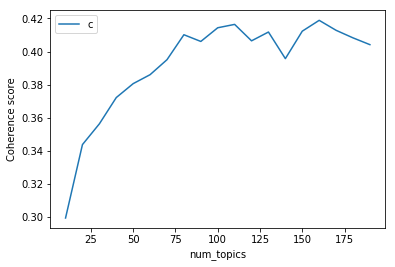

CPU times: user 30min 31s, sys: 25.4 s, total: 30min 56s
Wall time: 31min 56s


In [131]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, st=10, ed=200, step=10)

As shown in the above figure, the best optimal number of topics is around 110 (80~160), which corresponds to Pew Research Report (http://www.pewinternet.org/2016/12/28/we-the-people-five-years-of-online-petitions/).

In [132]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lmlist[10], corpus, dictionary) # lmlist[10] -> num_topics = 110

2017-11-22 14:16:50,960 : DEBUG : performing inference on a chunk of 3672 documents
2017-11-22 14:16:57,878 : DEBUG : 3670/3672 documents converged within 50 iterations
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
40     2.228050        1       1  0.202892  0.238414
34     1.641554        1       2  0.002825  0.034641
106    1.491154        1       3 -0.133871  0.037215
94     1.353753        1       4  0.108289  0.071308
3      1.331523        1       5  0.129957 -0.059852
19     1.325139        1       6 -0.014232 -0.037211
38     1.312550        1       7 -0.056962 -0.017175
21     1.259349        1       8 -0.002031 -0.073544
20     1.257807        1       9  0.131325  0.007627
31     1.253673        1      10 -0.081409  0.042887
65     1.213333        1      11 -0.066109  0.044133
39     1.191454        1      12  0.000293 -0.092095
66     1.171943        1      13 -0.150438  0.070135
27     1.168845        1      14 -0.010253  0.107131
76     1.083275        1      15  0.028932  0.007192
12     1.077257        1      16  0.124689  0.167327
44     1.074054        1      17 -0.126745 -0.010807
17     1.071232        1      18 -0.101509  0.076347
36     1.064838        1      19 -0.034190  0.019372
10     1.045264        1      20 -0.019165 -0.056720
96     1.045117        1      21 -0.088988 -0.050466
14     1.044331        1      22  0.038316 -0.017733
75     1.033116        1      23  0.041476  0.076916
83     1.021603        1      24 -0.016009  0.032553
102    1.013093        1      25  0.066801 -0.004069
59     1.000311        1      26 -0.041677 -0.006211
69     0.989661        1      27  0.070695 -0.019267
53     0.988095        1      28 -0.104017  0.016146
74     0.984744        1      29 -0.086159  0.042289
104    0.979356        1      30 -0.017829  0.064914
...         ...      ...     ...       ...       ...
78     0.761518        1      81 -0.028445 -0.007450
68     0.756279        1      82  0.039799 -0.032437
57     0.754986        1      83  0.110204 -0.085011
43     0.754934        1      84  0.060806 -0.023465
24     0.742990        1      85 -0.061092 -0.035617
13     0.736474        1      86  0.020537  0.059316
30     0.732285        1      87  0.147614  0.024845
15     0.730056        1      88  0.011906 -0.031642
81     0.728226        1      89 -0.024450  0.043131
55     0.728200        1      90 -0.005754 -0.036256
60     0.724715        1      91 -0.021903 -0.053557
35     0.717499        1      92  0.070592 -0.041781
50     0.706560        1      93  0.047094 -0.064424
107    0.696345        1      94 -0.107418  0.027750
11     0.694315        1      95  0.005523 -0.036203
48     0.685433        1      96  0.086403 -0.101940
42     0.675423        1      97  0.033287 -0.076302
22     0.665242        1      98  0.033136 -0.035499
51     0.657705        1      99 -0.010263 -0.033751
32     0.644107        1     100 -0.034279  0.015431
105    0.635202        1     101 -0.020525  0.003360
72     0.631900        1     102  0.008893 -0.011691
33     0.631213        1     103  0.026441 -0.014903
73     0.631203        1     104  0.050025 -0.109829
4      0.629365        1     105  0.058637 -0.115761
84     0.628031        1     106  0.019511  0.067632
2      0.616032        1     107  0.045142  0.042104
95     0.614029        1     108 -0.014783  0.019747
109    0.546729        1     109  0.053175 -0.036625
108    0.518189        1     110  0.063066 -0.058104

[110 rows x 5 columns], topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
421    Default   873.000000            child   873.000000  30.0000  30.0000
4626   Default   274.000000          student   274.000000  29.0000  29.0000
7648   Default   256.000000           school   256.000000  28.0000  28.0000
8142   Default   201.000000          officer   201.000000  27.0000  27.0000
1156   Default   279.000000            power   279.000000  26.0000  26.0000
2223   Default   190.000000             visa   190.000000  25.

In [161]:
lmtopics = lmlist[10].show_topics(formatted=False)

## Topic modeling using HDP

In [134]:
%%time
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

2017-11-22 14:18:39,836 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,003 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,005 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,007 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,009 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,346 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,348 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,431 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,433 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,435 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,438 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,440 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,442 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,505 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,507 : WARNING : likelihood is decreasing!
2017-11-22 14:18:40,509 : WARNING : likelihood is decreasing!
2017-11-

2017-11-22 14:18:44,798 : WARNING : likelihood is decreasing!
2017-11-22 14:18:44,800 : WARNING : likelihood is decreasing!
2017-11-22 14:18:44,802 : WARNING : likelihood is decreasing!
2017-11-22 14:18:44,805 : WARNING : likelihood is decreasing!
2017-11-22 14:18:44,808 : WARNING : likelihood is decreasing!
2017-11-22 14:18:44,931 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,094 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,097 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,099 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,102 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,106 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,108 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,110 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,113 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,117 : WARNING : likelihood is decreasing!
2017-11-22 14:18:45,120 : WARNING : likelihood is decreasing!
2017-11-

2017-11-22 14:18:51,235 : WARNING : likelihood is decreasing!
2017-11-22 14:18:51,238 : WARNING : likelihood is decreasing!
2017-11-22 14:18:51,241 : WARNING : likelihood is decreasing!
2017-11-22 14:18:51,245 : WARNING : likelihood is decreasing!
2017-11-22 14:18:51,248 : WARNING : likelihood is decreasing!
2017-11-22 14:18:51,252 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,188 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,190 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,936 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,938 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,940 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,943 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,944 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,947 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,950 : WARNING : likelihood is decreasing!
2017-11-22 14:18:52,953 : WARNING : likelihood is decreasing!
2017-11-

2017-11-22 14:19:01,067 : INFO : (15, u'0.002*person + 0.002*dog + 0.001*fund + 0.001*citizen + 0.001*united_state + 0.001*family + 0.001*nation + 0.001*scholarship + 0.001*law + 0.001*process')
2017-11-22 14:19:01,080 : INFO : (16, u'0.002*law + 0.002*person + 0.001*member + 0.001*price + 0.001*family + 0.001*union + 0.001*fund + 0.001*money + 0.001*benefit + 0.001*company')
2017-11-22 14:19:01,093 : INFO : (17, u'0.001*drug + 0.001*green_card + 0.001*sarcoma + 0.001*system + 0.001*person + 0.001*blood + 0.001*ban + 0.001*treatment + 0.001*gain + 0.001*superdelegate')
2017-11-22 14:19:01,107 : INFO : (18, u'0.002*child + 0.002*person + 0.001*family + 0.001*parent + 0.001*infliction + 0.001*hra + 0.001*justice + 0.001*birth + 0.001*month + 0.001*week')
2017-11-22 14:19:01,122 : INFO : (19, u'0.002*person + 0.002*law + 0.002*citizen + 0.001*united_state + 0.001*world + 0.001*property + 0.001*ukraine + 0.001*addition + 0.001*egypt + 0.001*cairo')


CPU times: user 22.4 s, sys: 800 ms, total: 23.2 s
Wall time: 23 s


In [138]:
hdpmodel.print_topics(num_topics=-1, num_words=10)

2017-11-22 14:25:49,758 : INFO : (0, u'0.012*person + 0.007*child + 0.004*law + 0.004*family + 0.003*world + 0.003*united_state + 0.003*life + 0.003*citizen + 0.003*action + 0.002*nation')
2017-11-22 14:25:49,775 : INFO : (1, u'0.007*person + 0.006*law + 0.003*crime + 0.002*united_state + 0.002*child + 0.002*citizen + 0.002*act + 0.002*change + 0.002*family + 0.002*student')
2017-11-22 14:25:49,791 : INFO : (2, u'0.006*person + 0.003*citizen + 0.002*law + 0.002*united_state + 0.002*food + 0.002*officer + 0.002*nation + 0.002*congress + 0.002*authority + 0.002*family')
2017-11-22 14:25:49,806 : INFO : (3, u'0.005*person + 0.003*child + 0.003*world + 0.002*home + 0.002*family + 0.002*life + 0.002*school + 0.002*community + 0.002*united_state + 0.002*man')
2017-11-22 14:25:49,825 : INFO : (4, u'0.006*person + 0.002*child + 0.002*candidate + 0.002*law + 0.002*citizen + 0.002*congress + 0.002*debate + 0.002*party + 0.002*service + 0.002*program')
2017-11-22 14:25:49,840 : INFO : (5, u'0.005

2017-11-22 14:25:50,597 : INFO : (42, u'0.001*annie + 0.001*alyssa + 0.001*panther + 0.001*customer + 0.001*origin + 0.001*momentum + 0.001*refund + 0.001*sympathy + 0.001*sinkhole + 0.001*wing')
2017-11-22 14:25:50,616 : INFO : (43, u'0.001*isis + 0.001*person + 0.001*child + 0.001*cheerleader + 0.001*spot + 0.001*captive + 0.001*bonner + 0.001*printer + 0.001*kurd + 0.001*cancer_research')
2017-11-22 14:25:50,635 : INFO : (44, u'0.001*person + 0.001*cancer + 0.001*woman + 0.001*israel + 0.001*child + 0.001*gig + 0.001*administration + 0.001*curse + 0.001*process + 0.001*cannabi')
2017-11-22 14:25:50,660 : INFO : (45, u'0.001*elephant + 0.001*loss + 0.001*sheldon + 0.001*emo + 0.001*jaoa + 0.001*implausibility + 0.001*person + 0.001*service_member + 0.001*sell + 0.001*shipping')
2017-11-22 14:25:50,682 : INFO : (46, u'0.001*html + 0.001*surat + 0.001*scrutiny + 0.001*bagger + 0.001*meat + 0.001*american_dream + 0.001*bedsore + 0.001*leopoldo + 0.001*oxbplwejq + 0.001*nancy')
2017-11-2

2017-11-22 14:25:51,456 : INFO : (83, u'0.001*person + 0.001*monosodium + 0.001*chechnya + 0.001*zohyrdo + 0.001*vermont + 0.001*valizadeh + 0.001*marijuana + 0.001*abstinence + 0.001*aura + 0.001*sovereignty')
2017-11-22 14:25:51,478 : INFO : (84, u'0.001*administration + 0.001*pickett + 0.001*visa + 0.001*rebuttal + 0.001*safari + 0.001*assange + 0.001*immigrant + 0.001*mistreatment + 0.001*congofreedom + 0.001*ammendment')
2017-11-22 14:25:51,497 : INFO : (85, u'0.001*law + 0.001*evasion + 0.001*vaccination + 0.001*alito + 0.001*cruelty + 0.001*turkic + 0.001*congress + 0.001*aug + 0.001*jared + 0.001*contract')
2017-11-22 14:25:51,517 : INFO : (86, u'0.001*disease + 0.001*secretary + 0.001*rangevoting + 0.001*chekov + 0.001*send_message + 0.001*nodis + 0.001*change + 0.001*withdrawal + 0.001*www + 0.001*november')
2017-11-22 14:25:51,533 : INFO : (87, u'0.001*fume + 0.001*bobby + 0.001*laboratory + 0.001*subsidy + 0.001*morsi + 0.001*inhabitant + 0.001*bahraini + 0.001*privatizatio

2017-11-22 14:25:52,125 : INFO : (124, u'0.001*point + 0.001*rice + 0.001*repeal + 0.001*khalsa + 0.001*uganda_anti + 0.001*devotee + 0.001*man + 0.001*iron + 0.001*coin + 0.001*registry')
2017-11-22 14:25:52,140 : INFO : (125, u'0.001*trenton + 0.001*panetta + 0.001*lack + 0.001*distribution + 0.001*contact + 0.001*nasr + 0.001*able_get + 0.001*consitutution + 0.001*lobbyist + 0.001*exploitation')
2017-11-22 14:25:52,154 : INFO : (126, u'0.001*demonstration + 0.001*cessation + 0.001*ruin + 0.001*tyveon + 0.001*egg + 0.001*perspective + 0.001*soviet + 0.001*exist + 0.001*discharge + 0.001*competency')
2017-11-22 14:25:52,170 : INFO : (127, u'0.001*yadev + 0.001*job + 0.001*career + 0.001*voice + 0.001*kalmus + 0.001*bishop + 0.001*fannie + 0.001*chapter + 0.001*vandalium + 0.001*plugin')
2017-11-22 14:25:52,186 : INFO : (128, u'0.001*rep + 0.001*research + 0.001*luttrell + 0.001*kia + 0.001*ultralight + 0.001*pasteurization + 0.001*boutique + 0.001*habea + 0.001*lpr + 0.001*taxpayer_do

[(0,
  u'0.012*person + 0.007*child + 0.004*law + 0.004*family + 0.003*world + 0.003*united_state + 0.003*life + 0.003*citizen + 0.003*action + 0.002*nation'),
 (1,
  u'0.007*person + 0.006*law + 0.003*crime + 0.002*united_state + 0.002*child + 0.002*citizen + 0.002*act + 0.002*change + 0.002*family + 0.002*student'),
 (2,
  u'0.006*person + 0.003*citizen + 0.002*law + 0.002*united_state + 0.002*food + 0.002*officer + 0.002*nation + 0.002*congress + 0.002*authority + 0.002*family'),
 (3,
  u'0.005*person + 0.003*child + 0.003*world + 0.002*home + 0.002*family + 0.002*life + 0.002*school + 0.002*community + 0.002*united_state + 0.002*man'),
 (4,
  u'0.006*person + 0.002*child + 0.002*candidate + 0.002*law + 0.002*citizen + 0.002*congress + 0.002*debate + 0.002*party + 0.002*service + 0.002*program'),
 (5,
  u'0.005*child + 0.004*person + 0.003*family + 0.002*law + 0.002*student + 0.001*month + 0.001*treatment + 0.001*disease + 0.001*education + 0.001*world'),
 (6,
  u'0.004*person + 0.0

In [159]:
hdptopics = hdpmodel.show_topics(formatted=False)

## Topic modeling with LSI

In [142]:
num_topics = 110
passes=5

lsimodel = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)

2017-11-22 14:30:37,255 : INFO : using serial LSI version on this node
2017-11-22 14:30:37,256 : INFO : updating model with new documents
2017-11-22 14:30:37,257 : INFO : preparing a new chunk of documents
2017-11-22 14:30:37,259 : DEBUG : converting corpus to csc format
2017-11-22 14:30:37,305 : INFO : using 100 extra samples and 2 power iterations
2017-11-22 14:30:37,306 : INFO : 1st phase: constructing (10180, 210) action matrix
2017-11-22 14:30:37,385 : INFO : orthonormalizing (10180, 210) action matrix
2017-11-22 14:30:37,404 : DEBUG : computing QR of (10180, 210) dense matrix
2017-11-22 14:30:37,595 : DEBUG : running 2 power iterations
2017-11-22 14:30:37,658 : DEBUG : computing QR of (10180, 210) dense matrix
2017-11-22 14:30:37,880 : DEBUG : computing QR of (10180, 210) dense matrix
2017-11-22 14:30:38,073 : INFO : 2nd phase: running dense svd on (210, 3672) matrix
2017-11-22 14:30:38,239 : INFO : computing the final decomposition
2017-11-22 14:30:38,240 : INFO : keeping 110 fa

In [157]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  u'0.624*"person" + 0.380*"child" + 0.252*"law" + 0.176*"family" + 0.148*"citizen" + 0.148*"united_state" + 0.100*"life" + 0.100*"world" + 0.085*"nation" + 0.077*"school"'),
 (1,
  u'-0.802*"child" + 0.494*"person" + -0.169*"family" + -0.124*"parent" + 0.087*"united_state" + -0.064*"school" + 0.042*"citizen" + -0.042*"age" + -0.041*"adoption" + 0.040*"ukraine"'),
 (2,
  u'-0.644*"law" + 0.498*"person" + 0.263*"child" + -0.211*"citizen" + -0.133*"act" + -0.117*"united_state" + -0.098*"congress" + -0.085*"officer" + -0.070*"action" + -0.068*"service"'),
 (3,
  u'0.589*"law" + -0.317*"student" + -0.236*"family" + 0.224*"person" + -0.189*"school" + 0.187*"child" + -0.168*"united_state" + -0.164*"program" + -0.154*"education" + -0.132*"service"'),
 (4,
  u'0.468*"united_state" + 0.428*"citizen" + -0.410*"student" + -0.273*"school" + -0.219*"law" + 0.176*"power" + -0.158*"education" + 0.153*"family" + 0.110*"constitution" + -0.102*"program"')]

In [156]:
lsitopics = lsimodel.show_topics(formatted=False)

## LDA as LSI

In [154]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    passes=5
    num_topics = 110
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        print("-----------",top_topics[0][1])
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=state, passes=passes)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [155]:
lm, top_topics = ret_top_model()

2017-11-22 14:49:05,058 : INFO : using symmetric alpha at 0.00909090909091
2017-11-22 14:49:05,060 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 14:49:05,064 : INFO : using serial LDA version on this node


('-----------', 0)


2017-11-22 14:49:14,432 : INFO : running online (multi-pass) LDA training, 110 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 14:49:14,433 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 14:49:14,440 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 14:49:14,441 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:49:22,124 : DEBUG : 1258/2000 documents converged within 50 iterations
2017-11-22 14:49:22,130 : DEBUG : updating topics
2017-11-22 14:49:22,143 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:49:22,949 : INFO : topic #64 (0.009): 0.016*"person" + 0.015*"home" + 0.008*"teacher" + 0.008*"service" + 0.008*"date" + 0.008*"child" + 0.007*"sah" + 0.00

2017-11-22 14:49:54,783 : INFO : topic #30 (0.009): 0.033*"amendment" + 0.021*"united_state" + 0.020*"citizen" + 0.017*"constitution" + 0.016*"court" + 0.014*"retrial" + 0.014*"treason" + 0.011*"crime" + 0.011*"ammunition" + 0.010*"justice"
2017-11-22 14:49:54,785 : INFO : topic #65 (0.009): 0.042*"information" + 0.036*"rape" + 0.033*"victim" + 0.023*"evidence" + 0.020*"rapist" + 0.017*"investigation" + 0.017*"justice" + 0.015*"fund" + 0.015*"program" + 0.014*"agency"
2017-11-22 14:49:54,791 : INFO : topic diff=0.579659, rho=0.500000
2017-11-22 14:49:55,050 : DEBUG : bound: at document #0
2017-11-22 14:50:01,191 : INFO : -9.439 per-word bound, 694.0 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:50:01,192 : INFO : PROGRESS: pass 2, at document #3672/3672
2017-11-22 14:50:01,192 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 14:50:04,771 : DEBUG : 1672/1672 documents converged within 50 iterations
2017-11-22 14:50:

2017-11-22 14:50:34,373 : INFO : topic #94 (0.009): 0.037*"person" + 0.035*"sport" + 0.034*"http_www" + 0.026*"com" + 0.016*"fraud" + 0.015*"part" + 0.014*"nation" + 0.013*"georgia" + 0.010*"economic_crisis" + 0.010*"choice"
2017-11-22 14:50:34,374 : INFO : topic #101 (0.009): 0.062*"medal" + 0.035*"unit" + 0.035*"combat" + 0.031*"item" + 0.022*"service" + 0.019*"affiliation" + 0.018*"abortion" + 0.015*"life" + 0.013*"relocation" + 0.013*"ship"
2017-11-22 14:50:34,375 : INFO : topic #87 (0.009): 0.023*"interest" + 0.022*"spraying" + 0.021*"person" + 0.021*"home" + 0.017*"vacation" + 0.016*"exchange" + 0.016*"ethic" + 0.014*"adult" + 0.014*"conversation" + 0.013*"nation"
2017-11-22 14:50:34,381 : INFO : topic diff=0.353638, rho=0.408248
2017-11-22 14:50:34,414 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:34,469 : INFO : 1 batches submitted to accumulate stats from 64 documents (1641 virtual)


2017-11-22 14:50:35,165 : INFO : accumulator serialized
2017-11-22 14:50:35,168 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:35,173 : DEBUG : completed batch 1; 128 documents processed (2864 virtual)
2017-11-22 14:50:35,181 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:35,182 : DEBUG : completed batch 2; 192 documents processed (4354 virtual)
2017-11-22 14:50:35,183 : INFO : accumulator serialized
2017-11-22 14:50:35,184 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:35,184 : DEBUG : finished all batches; 128 documents processed (2864 virtual)
2017-11-22 14:50:35,187 : DEBUG : finished all batches; 192 documents processed (4354 virtual)
2017-11-22 14:50:35,187 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:35,189 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:35,189 : INFO : accumulator serialized
2017-11-22 14:50:35,192 : INFO : accumulator serialized
2017-11-22 14:50:35,

2017-11-22 14:50:36,136 : INFO : accumulator serialized
2017-11-22 14:50:36,090 : INFO : accumulator serialized
2017-11-22 14:50:36,383 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:36,394 : INFO : accumulated word occurrence stats for 6301 virtual documents
2017-11-22 14:50:36,431 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:36,474 : INFO : 1 batches submitted to accumulate stats from 64 documents (1494 virtual)
2017-11-22 14:50:36,482 : INFO : 2 batches submitted to accumulate stats from 128 documents (3004 virtual)
2017-11-22 14:50:36,487 : INFO : 3 batches submitted to accumulate stats from 192 documents (4382 virtual)
2017-11-22 14:50:36,493 : INFO : 4 batches submitted to accumulate stats from 256 documents (5613 virtual)
2017-11-22 14:50:36,498 : INFO : 5 batches submitted to accumulate stats from 320 documents (6970 virtual)
2017-11-22 14:50:36,508 : INFO : 6 b

2017-11-22 14:50:37,147 : INFO : 2 batches submitted to accumulate stats from 128 documents (2968 virtual)
2017-11-22 14:50:37,152 : INFO : 3 batches submitted to accumulate stats from 192 documents (4172 virtual)
2017-11-22 14:50:37,158 : INFO : 4 batches submitted to accumulate stats from 256 documents (5547 virtual)
2017-11-22 14:50:37,165 : INFO : 5 batches submitted to accumulate stats from 320 documents (6800 virtual)
2017-11-22 14:50:37,170 : INFO : 6 batches submitted to accumulate stats from 384 documents (8138 virtual)
2017-11-22 14:50:37,174 : INFO : 7 batches submitted to accumulate stats from 448 documents (9543 virtual)
2017-11-22 14:50:37,181 : INFO : 8 batches submitted to accumulate stats from 512 documents (10887 virtual)
2017-11-22 14:50:37,191 : INFO : 9 batches submitted to accumulate stats from 576 documents (12358 virtual)
2017-11-22 14:50:37,196 : INFO : 10 batches submitted to accumulate stats from 640 documents (13729 virtual)
2017-11-22 14:50:37,202 : INFO : 

2017-11-22 14:50:37,870 : INFO : 13 batches submitted to accumulate stats from 832 documents (16641 virtual)
2017-11-22 14:50:37,876 : INFO : 14 batches submitted to accumulate stats from 896 documents (17936 virtual)
2017-11-22 14:50:37,885 : INFO : 15 batches submitted to accumulate stats from 960 documents (19479 virtual)
2017-11-22 14:50:37,862 : DEBUG : completed batch 0; 64 documents processed (1344 virtual)
2017-11-22 14:50:37,869 : DEBUG : completed batch 0; 64 documents processed (1286 virtual)
2017-11-22 14:50:37,895 : INFO : 16 batches submitted to accumulate stats from 1024 documents (20835 virtual)
2017-11-22 14:50:37,879 : DEBUG : completed batch 0; 64 documents processed (1357 virtual)
2017-11-22 14:50:37,896 : DEBUG : completed batch 1; 128 documents processed (2797 virtual)
2017-11-22 14:50:37,904 : INFO : 17 batches submitted to accumulate stats from 1088 documents (22189 virtual)
2017-11-22 14:50:37,898 : DEBUG : completed batch 1; 128 documents processed (2506 virtu

2017-11-22 14:50:38,552 : DEBUG : completed batch 1; 128 documents processed (2808 virtual)
2017-11-22 14:50:38,555 : DEBUG : completed batch 1; 128 documents processed (2821 virtual)
2017-11-22 14:50:38,563 : INFO : 17 batches submitted to accumulate stats from 1088 documents (24077 virtual)
2017-11-22 14:50:38,581 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:38,585 : DEBUG : completed batch 1; 128 documents processed (2985 virtual)
2017-11-22 14:50:38,593 : DEBUG : completed batch 1; 128 documents processed (2734 virtual)
2017-11-22 14:50:38,584 : DEBUG : finished all batches; 128 documents processed (2821 virtual)
2017-11-22 14:50:38,607 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:38,598 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:38,602 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:38,616 : DEBUG : finished all batches; 128 documents processed (2734 virtual)
2017-11-22 14:50:38,608 : DEBUG : compl

2017-11-22 14:50:39,609 : INFO : 8 batches submitted to accumulate stats from 512 documents (12444 virtual)
2017-11-22 14:50:39,621 : INFO : 9 batches submitted to accumulate stats from 576 documents (13951 virtual)
2017-11-22 14:50:39,618 : DEBUG : completed batch 0; 64 documents processed (1632 virtual)
2017-11-22 14:50:39,610 : DEBUG : completed batch 0; 64 documents processed (1605 virtual)
2017-11-22 14:50:39,633 : INFO : 10 batches submitted to accumulate stats from 640 documents (15480 virtual)
2017-11-22 14:50:39,622 : DEBUG : completed batch 0; 64 documents processed (1450 virtual)
2017-11-22 14:50:39,636 : DEBUG : completed batch 0; 64 documents processed (1560 virtual)
2017-11-22 14:50:39,641 : DEBUG : completed batch 0; 64 documents processed (1558 virtual)
2017-11-22 14:50:39,651 : DEBUG : completed batch 1; 70 documents processed (1715 virtual)
2017-11-22 14:50:39,651 : DEBUG : completed batch 0; 64 documents processed (1502 virtual)
2017-11-22 14:50:39,653 : DEBUG : obse

2017-11-22 14:50:40,534 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:40,578 : INFO : 1 batches submitted to accumulate stats from 64 documents (1419 virtual)
2017-11-22 14:50:40,585 : INFO : 2 batches submitted to accumulate stats from 128 documents (2844 virtual)
2017-11-22 14:50:40,589 : INFO : 3 batches submitted to accumulate stats from 192 documents (4224 virtual)
2017-11-22 14:50:40,595 : INFO : 4 batches submitted to accumulate stats from 256 documents (5409 virtual)
2017-11-22 14:50:40,603 : INFO : 5 batches submitted to accumulate stats from 320 documents (6774 virtual)
2017-11-22 14:50:40,613 : INFO : 6 batches submitted to accumulate stats from 384 documents (8058 virtual)
2017-11-22 14:50:40,617 : INFO : 7 batches submitted to accumulate stats from 448 documents (9372 virtual)
2017-11-22 14:50:40,635 : INFO : 8 batches submitted to accumulate stats from 512 documents (10748 virtu

2017-11-22 14:50:41,310 : INFO : 4 batches submitted to accumulate stats from 256 documents (6027 virtual)
2017-11-22 14:50:41,322 : INFO : 5 batches submitted to accumulate stats from 320 documents (7463 virtual)
2017-11-22 14:50:41,332 : INFO : 6 batches submitted to accumulate stats from 384 documents (8820 virtual)
2017-11-22 14:50:41,329 : DEBUG : completed batch 0; 64 documents processed (1504 virtual)
2017-11-22 14:50:41,342 : INFO : 7 batches submitted to accumulate stats from 448 documents (10253 virtual)
2017-11-22 14:50:41,344 : DEBUG : completed batch 0; 64 documents processed (1526 virtual)
2017-11-22 14:50:41,355 : DEBUG : completed batch 0; 64 documents processed (1584 virtual)
2017-11-22 14:50:41,362 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:41,361 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:41,365 : DEBUG : completed batch 1; 74 documents processed (1774 virtual)
2017-11-22 14:50:41,366 : DEBUG : finished all batches; 64 docume

2017-11-22 14:50:41,964 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:41,964 : INFO : accumulator serialized
2017-11-22 14:50:41,967 : INFO : accumulator serialized
2017-11-22 14:50:41,936 : INFO : accumulator serialized
2017-11-22 14:50:42,225 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:42,240 : INFO : accumulated word occurrence stats for 19000 virtual documents
2017-11-22 14:50:42,290 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:42,340 : INFO : 1 batches submitted to accumulate stats from 64 documents (1447 virtual)
2017-11-22 14:50:42,348 : INFO : 2 batches submitted to accumulate stats from 128 documents (2865 virtual)
2017-11-22 14:50:42,353 : INFO : 3 batches submitted to accumulate stats from 192 documents (4218 virtual)
2017-11-22 14:50:42,359 : INFO : 4 batches submitted to accumulate stats from 256 documents (5374 virtual)
2017-1

2017-11-22 14:50:43,010 : INFO : 3 batches submitted to accumulate stats from 192 documents (3900 virtual)
2017-11-22 14:50:43,016 : INFO : 4 batches submitted to accumulate stats from 256 documents (5233 virtual)
2017-11-22 14:50:43,023 : INFO : 5 batches submitted to accumulate stats from 320 documents (6497 virtual)
2017-11-22 14:50:43,028 : INFO : 6 batches submitted to accumulate stats from 384 documents (7868 virtual)
2017-11-22 14:50:43,045 : INFO : 7 batches submitted to accumulate stats from 448 documents (9243 virtual)
2017-11-22 14:50:43,059 : INFO : 8 batches submitted to accumulate stats from 512 documents (10687 virtual)
2017-11-22 14:50:43,051 : DEBUG : completed batch 0; 64 documents processed (1374 virtual)
2017-11-22 14:50:43,066 : INFO : 9 batches submitted to accumulate stats from 576 documents (12067 virtual)
2017-11-22 14:50:43,062 : DEBUG : completed batch 0; 64 documents processed (1124 virtual)
2017-11-22 14:50:43,074 : INFO : 10 batches submitted to accumulate

2017-11-22 14:50:43,684 : INFO : accumulator serialized
2017-11-22 14:50:43,683 : DEBUG : completed batch 0; 64 documents processed (1481 virtual)
2017-11-22 14:50:43,690 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:43,693 : DEBUG : finished all batches; 64 documents processed (1481 virtual)
2017-11-22 14:50:43,694 : DEBUG : completed batch 1; 122 documents processed (2817 virtual)
2017-11-22 14:50:43,695 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:43,697 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:43,698 : INFO : accumulator serialized
2017-11-22 14:50:43,700 : DEBUG : finished all batches; 122 documents processed (2817 virtual)
2017-11-22 14:50:43,702 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:43,698 : DEBUG : completed batch 0; 64 documents processed (1541 virtual)
2017-11-22 14:50:43,705 : INFO : accumulator serialized
2017-11-22 14:50:43,705 : DEBUG : observed sentinel value; terminat

2017-11-22 14:50:44,667 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23283 virtual)
2017-11-22 14:50:44,672 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24700 virtual)
2017-11-22 14:50:44,670 : DEBUG : completed batch 0; 64 documents processed (1297 virtual)
2017-11-22 14:50:44,678 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25867 virtual)
2017-11-22 14:50:44,663 : DEBUG : completed batch 0; 64 documents processed (1358 virtual)
2017-11-22 14:50:44,690 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27328 virtual)
2017-11-22 14:50:44,682 : DEBUG : completed batch 0; 64 documents processed (1429 virtual)
2017-11-22 14:50:44,702 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28645 virtual)
2017-11-22 14:50:44,740 : DEBUG : completed batch 1; 128 documents processed (2702 virtual)
2017-11-22 14:50:44,746 : INFO : 22 batches submitted to accumulate stats from 1408 d

2017-11-22 14:50:45,392 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:45,392 : INFO : accumulator serialized
2017-11-22 14:50:45,393 : INFO : accumulator serialized
2017-11-22 14:50:45,395 : DEBUG : finished all batches; 91 documents processed (1988 virtual)
2017-11-22 14:50:45,397 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:45,398 : DEBUG : completed batch 1; 128 documents processed (2718 virtual)
2017-11-22 14:50:45,400 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:45,401 : INFO : accumulator serialized
2017-11-22 14:50:45,403 : DEBUG : finished all batches; 128 documents processed (2718 virtual)
2017-11-22 14:50:45,405 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:45,406 : DEBUG : completed batch 1; 128 documents processed (2767 virtual)
2017-11-22 14:50:45,407 : INFO : accumulator serialized
2017-11-22 14:50:45,409 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:45,411 : DEBU

2017-11-22 14:50:46,431 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24731 virtual)
2017-11-22 14:50:46,436 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25876 virtual)
2017-11-22 14:50:46,413 : DEBUG : completed batch 1; 128 documents processed (2864 virtual)
2017-11-22 14:50:46,441 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27241 virtual)
2017-11-22 14:50:46,448 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28519 virtual)
2017-11-22 14:50:46,438 : DEBUG : completed batch 1; 128 documents processed (2565 virtual)
2017-11-22 14:50:46,452 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29790 virtual)
2017-11-22 14:50:46,458 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31163 virtual)
2017-11-22 14:50:46,458 : DEBUG : completed batch 1; 128 documents processed (2736 virtual)
2017-11-22 14:50:46,458 : DEBUG : completed batch 1; 128 documen

2017-11-22 14:50:47,064 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:47,067 : INFO : accumulator serialized
2017-11-22 14:50:47,032 : INFO : accumulator serialized
2017-11-22 14:50:47,328 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:47,339 : INFO : accumulated word occurrence stats for 11048 virtual documents
2017-11-22 14:50:47,378 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:47,425 : INFO : 1 batches submitted to accumulate stats from 64 documents (1562 virtual)
2017-11-22 14:50:47,435 : INFO : 2 batches submitted to accumulate stats from 128 documents (2908 virtual)
2017-11-22 14:50:47,445 : INFO : 3 batches submitted to accumulate stats from 192 documents (4364 virtual)
2017-11-22 14:50:47,456 : INFO : 4 batches submitted to accumulate stats from 256 documents (5852 virtual)
2017-11-22 14:50:47,464 : INFO : 5 batches submitted to accumu

2017-11-22 14:50:48,141 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32557 virtual)
2017-11-22 14:50:48,158 : INFO : 25 batches submitted to accumulate stats from 1600 documents (33823 virtual)
2017-11-22 14:50:48,163 : DEBUG : completed batch 1; 128 documents processed (2675 virtual)
2017-11-22 14:50:48,160 : DEBUG : completed batch 2; 192 documents processed (4264 virtual)
2017-11-22 14:50:48,157 : DEBUG : completed batch 1; 128 documents processed (2776 virtual)
2017-11-22 14:50:48,168 : INFO : 26 batches submitted to accumulate stats from 1664 documents (34941 virtual)
2017-11-22 14:50:48,169 : DEBUG : completed batch 1; 128 documents processed (2573 virtual)
2017-11-22 14:50:48,177 : DEBUG : completed batch 2; 192 documents processed (4278 virtual)
2017-11-22 14:50:48,189 : DEBUG : completed batch 2; 192 documents processed (4266 virtual)
2017-11-22 14:50:48,191 : DEBUG : completed batch 2; 192 documents processed (3839 virtual)
2017-11-22 14:50:48,223 : 

2017-11-22 14:50:48,789 : DEBUG : finished all batches; 128 documents processed (2830 virtual)
2017-11-22 14:50:48,791 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:48,794 : INFO : accumulator serialized
2017-11-22 14:50:48,761 : INFO : accumulator serialized
2017-11-22 14:50:49,068 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:49,079 : INFO : accumulated word occurrence stats for 15539 virtual documents
2017-11-22 14:50:49,117 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:49,161 : INFO : 1 batches submitted to accumulate stats from 64 documents (1442 virtual)
2017-11-22 14:50:49,169 : INFO : 2 batches submitted to accumulate stats from 128 documents (2904 virtual)
2017-11-22 14:50:49,172 : INFO : 3 batches submitted to accumulate stats from 192 documents (4314 virtual)
2017-11-22 14:50:49,178 : INFO : 4 batches submitted to accumulate stats f

2017-11-22 14:50:49,543 : DEBUG : finished all batches; 320 documents processed (6926 virtual)
2017-11-22 14:50:49,545 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:49,545 : DEBUG : completed batch 4; 314 documents processed (6750 virtual)
2017-11-22 14:50:49,548 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:49,548 : INFO : accumulator serialized
2017-11-22 14:50:49,550 : DEBUG : finished all batches; 314 documents processed (6750 virtual)
2017-11-22 14:50:49,552 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:49,556 : INFO : accumulator serialized
2017-11-22 14:50:49,520 : INFO : accumulator serialized
2017-11-22 14:50:49,793 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:49,807 : INFO : accumulated word occurrence stats for 42444 virtual documents
2017-11-22 14:50:49,860 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows


2017-11-22 14:50:50,537 : INFO : 1 batches submitted to accumulate stats from 64 documents (1355 virtual)
2017-11-22 14:50:50,546 : INFO : 2 batches submitted to accumulate stats from 128 documents (2269 virtual)
2017-11-22 14:50:50,552 : INFO : 3 batches submitted to accumulate stats from 192 documents (3289 virtual)
2017-11-22 14:50:50,557 : INFO : 4 batches submitted to accumulate stats from 256 documents (4498 virtual)
2017-11-22 14:50:50,566 : INFO : 5 batches submitted to accumulate stats from 320 documents (5860 virtual)
2017-11-22 14:50:50,579 : DEBUG : completed batch 0; 64 documents processed (1355 virtual)
2017-11-22 14:50:50,591 : INFO : 6 batches submitted to accumulate stats from 384 documents (7129 virtual)
2017-11-22 14:50:50,583 : DEBUG : completed batch 0; 64 documents processed (914 virtual)
2017-11-22 14:50:50,598 : INFO : 7 batches submitted to accumulate stats from 448 documents (8404 virtual)
2017-11-22 14:50:50,592 : DEBUG : completed batch 0; 64 documents proce

2017-11-22 14:50:51,234 : DEBUG : finished all batches; 64 documents processed (1535 virtual)
2017-11-22 14:50:51,236 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:51,234 : DEBUG : completed batch 0; 64 documents processed (1571 virtual)
2017-11-22 14:50:51,240 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:51,240 : INFO : accumulator serialized
2017-11-22 14:50:51,242 : DEBUG : finished all batches; 64 documents processed (1571 virtual)
2017-11-22 14:50:51,244 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:51,246 : INFO : accumulator serialized
2017-11-22 14:50:51,201 : INFO : accumulator serialized
2017-11-22 14:50:51,512 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:51,523 : INFO : accumulated word occurrence stats for 11128 virtual documents
2017-11-22 14:50:51,561 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
201

2017-11-22 14:50:52,252 : INFO : 10 batches submitted to accumulate stats from 640 documents (13375 virtual)
2017-11-22 14:50:52,249 : DEBUG : completed batch 0; 64 documents processed (1446 virtual)
2017-11-22 14:50:52,259 : INFO : 11 batches submitted to accumulate stats from 704 documents (14711 virtual)
2017-11-22 14:50:52,248 : DEBUG : completed batch 0; 64 documents processed (1181 virtual)
2017-11-22 14:50:52,267 : INFO : 12 batches submitted to accumulate stats from 768 documents (16014 virtual)
2017-11-22 14:50:52,274 : INFO : 13 batches submitted to accumulate stats from 832 documents (17558 virtual)
2017-11-22 14:50:52,258 : DEBUG : completed batch 0; 64 documents processed (1315 virtual)
2017-11-22 14:50:52,266 : DEBUG : completed batch 0; 64 documents processed (1281 virtual)
2017-11-22 14:50:52,282 : INFO : 14 batches submitted to accumulate stats from 896 documents (18965 virtual)
2017-11-22 14:50:52,277 : DEBUG : completed batch 0; 64 documents processed (1346 virtual)


2017-11-22 14:50:52,907 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:52,910 : DEBUG : finished all batches; 64 documents processed (1320 virtual)
2017-11-22 14:50:52,909 : INFO : accumulator serialized
2017-11-22 14:50:52,912 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:52,914 : INFO : accumulator serialized
2017-11-22 14:50:52,925 : DEBUG : completed batch 0; 64 documents processed (1274 virtual)
2017-11-22 14:50:52,933 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:52,935 : DEBUG : finished all batches; 64 documents processed (1274 virtual)
2017-11-22 14:50:52,938 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:52,942 : INFO : accumulator serialized
2017-11-22 14:50:52,900 : INFO : accumulator serialized
2017-11-22 14:50:53,177 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:53,188 : INFO : accumulated word occurrence stats for 8472 virtual documents
2017-11-22 14:50:53,226 :

2017-11-22 14:50:53,938 : INFO : accumulator serialized
2017-11-22 14:50:53,938 : INFO : accumulator serialized
2017-11-22 14:50:53,940 : INFO : accumulator serialized
2017-11-22 14:50:53,941 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:53,944 : DEBUG : finished all batches; 128 documents processed (2785 virtual)
2017-11-22 14:50:53,945 : DEBUG : completed batch 1; 128 documents processed (2921 virtual)
2017-11-22 14:50:53,946 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:53,948 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:53,949 : INFO : accumulator serialized
2017-11-22 14:50:53,951 : DEBUG : finished all batches; 128 documents processed (2921 virtual)
2017-11-22 14:50:53,953 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:53,956 : INFO : accumulator serialized
2017-11-22 14:50:53,927 : INFO : accumulator serialized
2017-11-22 14:50:54,206 : INFO : 7 accumulators retrieved from output queue
2017

2017-11-22 14:50:54,940 : DEBUG : completed batch 0; 64 documents processed (1470 virtual)
2017-11-22 14:50:54,953 : INFO : 8 batches submitted to accumulate stats from 512 documents (11310 virtual)
2017-11-22 14:50:54,962 : INFO : 9 batches submitted to accumulate stats from 576 documents (12475 virtual)
2017-11-22 14:50:54,968 : INFO : 10 batches submitted to accumulate stats from 640 documents (13633 virtual)
2017-11-22 14:50:54,951 : DEBUG : completed batch 0; 64 documents processed (1391 virtual)
2017-11-22 14:50:54,970 : DEBUG : completed batch 0; 64 documents processed (1404 virtual)
2017-11-22 14:50:54,965 : DEBUG : completed batch 0; 64 documents processed (1477 virtual)
2017-11-22 14:50:54,979 : DEBUG : completed batch 0; 64 documents processed (1387 virtual)
2017-11-22 14:50:54,985 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:54,988 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:54,987 : DEBUG : completed batch 0; 64 documents processed (1

2017-11-22 14:50:55,585 : INFO : accumulator serialized
2017-11-22 14:50:55,550 : INFO : accumulator serialized
2017-11-22 14:50:55,842 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:55,852 : INFO : accumulated word occurrence stats for 18646 virtual documents
2017-11-22 14:50:55,890 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:50:55,940 : INFO : 1 batches submitted to accumulate stats from 64 documents (1479 virtual)
2017-11-22 14:50:55,953 : INFO : 2 batches submitted to accumulate stats from 128 documents (2992 virtual)
2017-11-22 14:50:55,963 : INFO : 3 batches submitted to accumulate stats from 192 documents (4402 virtual)
2017-11-22 14:50:55,975 : INFO : 4 batches submitted to accumulate stats from 256 documents (5850 virtual)
2017-11-22 14:50:55,983 : INFO : 5 batches submitted to accumulate stats from 320 documents (7255 virtual)
2017-11-22 14:50:55,990 : INFO : 6 

2017-11-22 14:50:56,633 : INFO : 22 batches submitted to accumulate stats from 1408 documents (30118 virtual)
2017-11-22 14:50:56,623 : DEBUG : completed batch 1; 128 documents processed (2666 virtual)
2017-11-22 14:50:56,639 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31419 virtual)
2017-11-22 14:50:56,643 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32633 virtual)
2017-11-22 14:50:56,632 : DEBUG : completed batch 1; 128 documents processed (2668 virtual)
2017-11-22 14:50:56,650 : INFO : 25 batches submitted to accumulate stats from 1600 documents (34071 virtual)
2017-11-22 14:50:56,654 : INFO : 26 batches submitted to accumulate stats from 1664 documents (35321 virtual)
2017-11-22 14:50:56,659 : INFO : 27 batches submitted to accumulate stats from 1728 documents (36637 virtual)
2017-11-22 14:50:56,663 : INFO : 28 batches submitted to accumulate stats from 1792 documents (38038 virtual)
2017-11-22 14:50:56,659 : DEBUG : completed ba

2017-11-22 14:50:57,351 : DEBUG : completed batch 1; 128 documents processed (2549 virtual)
2017-11-22 14:50:57,355 : DEBUG : completed batch 1; 128 documents processed (2615 virtual)
2017-11-22 14:50:57,379 : DEBUG : completed batch 2; 192 documents processed (3421 virtual)
2017-11-22 14:50:57,373 : DEBUG : completed batch 1; 128 documents processed (2943 virtual)
2017-11-22 14:50:57,386 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:57,389 : DEBUG : completed batch 3; 200 documents processed (3591 virtual)
2017-11-22 14:50:57,392 : DEBUG : completed batch 2; 192 documents processed (3646 virtual)
2017-11-22 14:50:57,390 : DEBUG : finished all batches; 128 documents processed (2943 virtual)
2017-11-22 14:50:57,392 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:57,395 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:57,395 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:57,397 : DEBUG : finished all batches; 200 

2017-11-22 14:50:58,354 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:58,362 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:50:58,354 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:58,362 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:50:58,362 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:50:58,366 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:50:58,366 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:58,366 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:58,368 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:58,369 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:58,370 : INFO : accumulator serialized
2017-11-22 14:50:58,372 : INFO : accumulator serialized
2017-11-22 14:50:58,372 : DEBUG : completed batch 0; 21 documents 

2017-11-22 14:50:59,043 : DEBUG : finished all batches; 192 documents processed (3955 virtual)
2017-11-22 14:50:59,045 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:59,046 : INFO : accumulator serialized
2017-11-22 14:50:59,046 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:59,050 : INFO : accumulator serialized
2017-11-22 14:50:59,049 : INFO : accumulator serialized
2017-11-22 14:50:59,075 : DEBUG : completed batch 3; 256 documents processed (5182 virtual)
2017-11-22 14:50:59,078 : DEBUG : observed sentinel value; terminating
2017-11-22 14:50:59,080 : DEBUG : finished all batches; 256 documents processed (5182 virtual)
2017-11-22 14:50:59,082 : INFO : serializing accumulator to return to master...
2017-11-22 14:50:59,086 : INFO : accumulator serialized
2017-11-22 14:50:59,033 : INFO : accumulator serialized
2017-11-22 14:50:59,324 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:50:59,335 : INFO : accumulated word o

2017-11-22 14:51:00,084 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:00,087 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:00,090 : INFO : accumulator serialized
2017-11-22 14:51:00,091 : DEBUG : finished all batches; 128 documents processed (2481 virtual)
2017-11-22 14:51:00,093 : DEBUG : completed batch 1; 128 documents processed (2687 virtual)
2017-11-22 14:51:00,096 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:00,097 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:00,100 : DEBUG : completed batch 1; 128 documents processed (2767 virtual)
2017-11-22 14:51:00,100 : DEBUG : finished all batches; 128 documents processed (2687 virtual)
2017-11-22 14:51:00,100 : INFO : accumulator serialized
2017-11-22 14:51:00,102 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:00,102 : DEBUG : completed batch 1; 108 documents processed (2306 virtual)
2017-11-22 14:51:00,103 : INFO : serializing accu

2017-11-22 14:51:01,093 : DEBUG : completed batch 0; 64 documents processed (1302 virtual)
2017-11-22 14:51:01,114 : INFO : 9 batches submitted to accumulate stats from 576 documents (11284 virtual)
2017-11-22 14:51:01,125 : INFO : 10 batches submitted to accumulate stats from 640 documents (12676 virtual)
2017-11-22 14:51:01,134 : INFO : 11 batches submitted to accumulate stats from 704 documents (13994 virtual)
2017-11-22 14:51:01,141 : INFO : 12 batches submitted to accumulate stats from 768 documents (15500 virtual)
2017-11-22 14:51:01,145 : INFO : 13 batches submitted to accumulate stats from 832 documents (16845 virtual)
2017-11-22 14:51:01,150 : INFO : 14 batches submitted to accumulate stats from 896 documents (18207 virtual)
2017-11-22 14:51:01,156 : INFO : 15 batches submitted to accumulate stats from 960 documents (19632 virtual)
2017-11-22 14:51:01,145 : DEBUG : completed batch 0; 64 documents processed (1317 virtual)
2017-11-22 14:51:01,161 : INFO : 16 batches submitted to

2017-11-22 14:51:01,754 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:01,766 : INFO : accumulated word occurrence stats for 48213 virtual documents
2017-11-22 14:51:01,828 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:01,883 : INFO : 1 batches submitted to accumulate stats from 64 documents (1402 virtual)
2017-11-22 14:51:01,892 : INFO : 2 batches submitted to accumulate stats from 128 documents (2840 virtual)
2017-11-22 14:51:01,896 : INFO : 3 batches submitted to accumulate stats from 192 documents (4280 virtual)
2017-11-22 14:51:01,901 : INFO : 4 batches submitted to accumulate stats from 256 documents (5677 virtual)
2017-11-22 14:51:01,908 : INFO : 5 batches submitted to accumulate stats from 320 documents (6853 virtual)
2017-11-22 14:51:01,923 : INFO : 6 batches submitted to accumulate stats from 384 documents (8213 virtual)
2017-11-22 14:51:01,928 : INFO : 7 batch

2017-11-22 14:51:02,287 : DEBUG : completed batch 4; 320 documents processed (6556 virtual)
2017-11-22 14:51:02,289 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:02,289 : INFO : accumulator serialized
2017-11-22 14:51:02,292 : DEBUG : finished all batches; 320 documents processed (6556 virtual)
2017-11-22 14:51:02,294 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:02,522 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:02,540 : INFO : accumulated word occurrence stats for 41285 virtual documents
2017-11-22 14:51:02,596 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:02,653 : INFO : 1 batches submitted to accumulate stats from 64 documents (1488 virtual)
2017-11-22 14:51:02,663 : INFO : 2 batches submitted to accumulate stats from 128 documents (2839 virtual)
2017-11-22 14:51:02,668 : INFO : 3 batches submitted to accumulate stats f

2017-11-22 14:51:03,259 : DEBUG : completed batch 0; 64 documents processed (1456 virtual)
2017-11-22 14:51:03,290 : DEBUG : completed batch 1; 128 documents processed (2774 virtual)
2017-11-22 14:51:03,281 : DEBUG : completed batch 1; 128 documents processed (2736 virtual)
2017-11-22 14:51:03,314 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23083 virtual)
2017-11-22 14:51:03,301 : DEBUG : completed batch 1; 128 documents processed (2677 virtual)
2017-11-22 14:51:03,322 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24421 virtual)
2017-11-22 14:51:03,304 : DEBUG : completed batch 1; 128 documents processed (2507 virtual)
2017-11-22 14:51:03,319 : DEBUG : completed batch 1; 128 documents processed (2663 virtual)
2017-11-22 14:51:03,330 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25603 virtual)
2017-11-22 14:51:03,340 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27109 virtual)
2017-11-2

2017-11-22 14:51:03,980 : INFO : accumulator serialized
2017-11-22 14:51:03,932 : INFO : accumulator serialized
2017-11-22 14:51:04,248 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:04,258 : INFO : accumulated word occurrence stats for 8780 virtual documents
2017-11-22 14:51:04,297 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:04,342 : INFO : 1 batches submitted to accumulate stats from 64 documents (1441 virtual)
2017-11-22 14:51:04,350 : INFO : 2 batches submitted to accumulate stats from 128 documents (2890 virtual)
2017-11-22 14:51:04,355 : INFO : 3 batches submitted to accumulate stats from 192 documents (4289 virtual)
2017-11-22 14:51:04,359 : INFO : 4 batches submitted to accumulate stats from 256 documents (5438 virtual)
2017-11-22 14:51:04,366 : INFO : 5 batches submitted to accumulate stats from 320 documents (6834 virtual)
2017-11-22 14:51:04,376 : INFO : 6 b

2017-11-22 14:51:04,738 : INFO : accumulator serialized
2017-11-22 14:51:04,709 : INFO : accumulator serialized
2017-11-22 14:51:05,011 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:05,023 : INFO : accumulated word occurrence stats for 38667 virtual documents
2017-11-22 14:51:05,068 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:05,112 : INFO : 1 batches submitted to accumulate stats from 64 documents (1376 virtual)
2017-11-22 14:51:05,121 : INFO : 2 batches submitted to accumulate stats from 128 documents (2844 virtual)
2017-11-22 14:51:05,126 : INFO : 3 batches submitted to accumulate stats from 192 documents (3993 virtual)
2017-11-22 14:51:05,131 : INFO : 4 batches submitted to accumulate stats from 256 documents (5361 virtual)
2017-11-22 14:51:05,137 : INFO : 5 batches submitted to accumulate stats from 320 documents (6651 virtual)
2017-11-22 14:51:05,149 : INFO : 6 

2017-11-22 14:51:05,844 : DEBUG : completed batch 0; 64 documents processed (1368 virtual)
2017-11-22 14:51:05,847 : INFO : 8 batches submitted to accumulate stats from 512 documents (11205 virtual)
2017-11-22 14:51:05,871 : INFO : 9 batches submitted to accumulate stats from 576 documents (12668 virtual)
2017-11-22 14:51:05,878 : INFO : 10 batches submitted to accumulate stats from 640 documents (13999 virtual)
2017-11-22 14:51:05,846 : DEBUG : completed batch 0; 64 documents processed (1368 virtual)
2017-11-22 14:51:05,887 : INFO : 11 batches submitted to accumulate stats from 704 documents (15373 virtual)
2017-11-22 14:51:05,879 : DEBUG : completed batch 0; 64 documents processed (1230 virtual)
2017-11-22 14:51:05,892 : INFO : 12 batches submitted to accumulate stats from 768 documents (16732 virtual)
2017-11-22 14:51:05,897 : INFO : 13 batches submitted to accumulate stats from 832 documents (18208 virtual)
2017-11-22 14:51:05,883 : DEBUG : completed batch 0; 64 documents processed

2017-11-22 14:51:06,603 : INFO : 14 batches submitted to accumulate stats from 896 documents (19443 virtual)
2017-11-22 14:51:06,606 : DEBUG : completed batch 1; 128 documents processed (2822 virtual)
2017-11-22 14:51:06,610 : DEBUG : completed batch 1; 128 documents processed (2921 virtual)
2017-11-22 14:51:06,614 : INFO : 15 batches submitted to accumulate stats from 960 documents (20778 virtual)
2017-11-22 14:51:06,616 : DEBUG : completed batch 1; 128 documents processed (2838 virtual)
2017-11-22 14:51:06,622 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22285 virtual)
2017-11-22 14:51:06,627 : DEBUG : completed batch 1; 128 documents processed (2556 virtual)
2017-11-22 14:51:06,635 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23742 virtual)
2017-11-22 14:51:06,638 : DEBUG : completed batch 1; 128 documents processed (2787 virtual)
2017-11-22 14:51:06,642 : INFO : 18 batches submitted to accumulate stats from 1152 documents (25096 v

2017-11-22 14:51:07,306 : DEBUG : completed batch 1; 128 documents processed (2875 virtual)
2017-11-22 14:51:07,330 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25547 virtual)
2017-11-22 14:51:07,312 : DEBUG : completed batch 1; 128 documents processed (2703 virtual)
2017-11-22 14:51:07,335 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26846 virtual)
2017-11-22 14:51:07,340 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28086 virtual)
2017-11-22 14:51:07,345 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29504 virtual)
2017-11-22 14:51:07,326 : DEBUG : completed batch 1; 128 documents processed (2643 virtual)
2017-11-22 14:51:07,350 : INFO : 23 batches submitted to accumulate stats from 1472 documents (30630 virtual)
2017-11-22 14:51:07,332 : DEBUG : completed batch 1; 128 documents processed (2494 virtual)
2017-11-22 14:51:07,358 : DEBUG : completed batch 2; 192 documents processed (4089

2017-11-22 14:51:08,024 : INFO : accumulator serialized
2017-11-22 14:51:08,023 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:08,027 : INFO : accumulator serialized
2017-11-22 14:51:08,030 : DEBUG : completed batch 2; 157 documents processed (3443 virtual)
2017-11-22 14:51:08,031 : DEBUG : completed batch 1; 128 documents processed (2969 virtual)
2017-11-22 14:51:08,043 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:08,042 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:08,044 : DEBUG : completed batch 2; 192 documents processed (4490 virtual)
2017-11-22 14:51:08,045 : DEBUG : finished all batches; 157 documents processed (3443 virtual)
2017-11-22 14:51:08,046 : DEBUG : finished all batches; 128 documents processed (2969 virtual)
2017-11-22 14:51:08,047 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:08,048 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:08,048 : INFO : serializing accu

2017-11-22 14:51:08,738 : INFO : accumulator serialized
2017-11-22 14:51:08,738 : DEBUG : finished all batches; 239 documents processed (5062 virtual)
2017-11-22 14:51:08,740 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:08,742 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:08,743 : DEBUG : finished all batches; 192 documents processed (3998 virtual)
2017-11-22 14:51:08,745 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:08,746 : INFO : accumulator serialized
2017-11-22 14:51:08,748 : INFO : accumulator serialized
2017-11-22 14:51:08,713 : INFO : accumulator serialized
2017-11-22 14:51:09,028 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:09,039 : INFO : accumulated word occurrence stats for 33560 virtual documents
2017-11-22 14:51:09,077 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:09,121 : INFO : 1 b

2017-11-22 14:51:09,774 : DEBUG : completed batch 0; 64 documents processed (1355 virtual)
2017-11-22 14:51:09,802 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22162 virtual)
2017-11-22 14:51:09,808 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23540 virtual)
2017-11-22 14:51:09,801 : DEBUG : completed batch 1; 128 documents processed (2894 virtual)
2017-11-22 14:51:09,815 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24932 virtual)
2017-11-22 14:51:09,811 : DEBUG : completed batch 1; 128 documents processed (2793 virtual)
2017-11-22 14:51:09,822 : INFO : 19 batches submitted to accumulate stats from 1216 documents (26112 virtual)
2017-11-22 14:51:09,802 : DEBUG : completed batch 1; 128 documents processed (2800 virtual)
2017-11-22 14:51:09,817 : DEBUG : completed batch 1; 128 documents processed (2631 virtual)
2017-11-22 14:51:09,822 : DEBUG : completed batch 1; 128 documents processed (2607 virtual)
2017-11-2

2017-11-22 14:51:10,443 : DEBUG : completed batch 1; 128 documents processed (2754 virtual)
2017-11-22 14:51:10,438 : DEBUG : completed batch 1; 128 documents processed (2383 virtual)
2017-11-22 14:51:10,449 : INFO : 23 batches submitted to accumulate stats from 1472 documents (30819 virtual)
2017-11-22 14:51:10,454 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32197 virtual)
2017-11-22 14:51:10,440 : DEBUG : completed batch 1; 128 documents processed (2885 virtual)
2017-11-22 14:51:10,459 : INFO : 25 batches submitted to accumulate stats from 1600 documents (33539 virtual)
2017-11-22 14:51:10,447 : DEBUG : completed batch 1; 128 documents processed (2694 virtual)
2017-11-22 14:51:10,470 : INFO : 26 batches submitted to accumulate stats from 1664 documents (34828 virtual)
2017-11-22 14:51:10,466 : DEBUG : completed batch 1; 128 documents processed (2698 virtual)
2017-11-22 14:51:10,486 : INFO : 27 batches submitted to accumulate stats from 1728 documents (36215

2017-11-22 14:51:11,101 : INFO : accumulator serialized
2017-11-22 14:51:11,104 : INFO : accumulator serialized
2017-11-22 14:51:11,109 : DEBUG : completed batch 1; 128 documents processed (2368 virtual)
2017-11-22 14:51:11,111 : DEBUG : completed batch 1; 128 documents processed (2531 virtual)
2017-11-22 14:51:11,112 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:11,114 : DEBUG : finished all batches; 128 documents processed (2368 virtual)
2017-11-22 14:51:11,114 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:11,116 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:11,116 : DEBUG : finished all batches; 128 documents processed (2531 virtual)
2017-11-22 14:51:11,118 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:11,119 : INFO : accumulator serialized
2017-11-22 14:51:11,121 : INFO : accumulator serialized
2017-11-22 14:51:11,125 : DEBUG : completed batch 1; 128 documents processed (2572 virtual)
2017-11-

2017-11-22 14:51:12,096 : INFO : 12 batches submitted to accumulate stats from 768 documents (16415 virtual)
2017-11-22 14:51:12,098 : DEBUG : completed batch 0; 64 documents processed (1395 virtual)
2017-11-22 14:51:12,109 : INFO : 13 batches submitted to accumulate stats from 832 documents (17840 virtual)
2017-11-22 14:51:12,119 : INFO : 14 batches submitted to accumulate stats from 896 documents (19235 virtual)
2017-11-22 14:51:12,118 : DEBUG : completed batch 1; 128 documents processed (2791 virtual)
2017-11-22 14:51:12,120 : DEBUG : completed batch 1; 128 documents processed (2853 virtual)
2017-11-22 14:51:12,126 : INFO : 15 batches submitted to accumulate stats from 960 documents (20720 virtual)
2017-11-22 14:51:12,132 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22108 virtual)
2017-11-22 14:51:12,133 : DEBUG : completed batch 1; 128 documents processed (2673 virtual)
2017-11-22 14:51:12,127 : DEBUG : completed batch 1; 128 documents processed (2789 virt

2017-11-22 14:51:12,755 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:12,756 : INFO : accumulator serialized
2017-11-22 14:51:12,758 : DEBUG : finished all batches; 128 documents processed (3050 virtual)
2017-11-22 14:51:12,759 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:12,760 : DEBUG : completed batch 1; 128 documents processed (3013 virtual)
2017-11-22 14:51:12,765 : INFO : accumulator serialized
2017-11-22 14:51:12,764 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:12,764 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:12,767 : DEBUG : finished all batches; 128 documents processed (3013 virtual)
2017-11-22 14:51:12,767 : INFO : accumulator serialized
2017-11-22 14:51:12,769 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:12,773 : INFO : accumulator serialized
2017-11-22 14:51:12,773 : DEBUG : completed batch 1; 128 documents processed (2879 virtual)
2017-11-22 14:51:12,

2017-11-22 14:51:13,453 : DEBUG : completed batch 3; 256 documents processed (5357 virtual)
2017-11-22 14:51:13,453 : DEBUG : finished all batches; 256 documents processed (5157 virtual)
2017-11-22 14:51:13,453 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:13,456 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:13,456 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:13,457 : DEBUG : completed batch 3; 256 documents processed (5367 virtual)
2017-11-22 14:51:13,460 : DEBUG : finished all batches; 256 documents processed (5357 virtual)
2017-11-22 14:51:13,457 : INFO : accumulator serialized
2017-11-22 14:51:13,459 : INFO : accumulator serialized
2017-11-22 14:51:13,462 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:13,463 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:13,466 : INFO : accumulator serialized
2017-11-22 14:51:13,469 : DEBUG : finished all batches; 256 documents proces

2017-11-22 14:51:14,091 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:14,093 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:14,094 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:14,095 : INFO : accumulator serialized
2017-11-22 14:51:14,097 : DEBUG : finished all batches; 256 documents processed (5428 virtual)
2017-11-22 14:51:14,097 : INFO : accumulator serialized
2017-11-22 14:51:14,099 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:14,103 : INFO : accumulator serialized
2017-11-22 14:51:14,108 : DEBUG : completed batch 3; 254 documents processed (5295 virtual)
2017-11-22 14:51:14,111 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:14,112 : DEBUG : finished all batches; 254 documents processed (5295 virtual)
2017-11-22 14:51:14,114 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:14,117 : INFO : accumulator serialized
2017-11-22 14:51:14,118 : INFO :

2017-11-22 14:51:15,127 : DEBUG : completed batch 1; 128 documents processed (2934 virtual)
2017-11-22 14:51:15,128 : DEBUG : finished all batches; 94 documents processed (2081 virtual)
2017-11-22 14:51:15,130 : DEBUG : finished all batches; 64 documents processed (1548 virtual)
2017-11-22 14:51:15,131 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:15,131 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:15,134 : DEBUG : finished all batches; 128 documents processed (2934 virtual)
2017-11-22 14:51:15,134 : INFO : accumulator serialized
2017-11-22 14:51:15,135 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:15,137 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:15,139 : INFO : accumulator serialized
2017-11-22 14:51:15,140 : INFO : accumulator serialized
2017-11-22 14:51:15,140 : DEBUG : completed batch 0; 64 documents processed (1454 virtual)
2017-11-22 14:51:15,146 : DEBUG : observed sentinel val

2017-11-22 14:51:15,769 : INFO : accumulator serialized
2017-11-22 14:51:15,825 : DEBUG : finished all batches; 192 documents processed (4590 virtual)
2017-11-22 14:51:15,828 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:16,065 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:16,077 : INFO : accumulated word occurrence stats for 30662 virtual documents
2017-11-22 14:51:16,122 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:16,168 : INFO : 1 batches submitted to accumulate stats from 64 documents (1574 virtual)
2017-11-22 14:51:16,177 : INFO : 2 batches submitted to accumulate stats from 128 documents (2973 virtual)
2017-11-22 14:51:16,183 : INFO : 3 batches submitted to accumulate stats from 192 documents (4440 virtual)
2017-11-22 14:51:16,189 : INFO : 4 batches submitted to accumulate stats from 256 documents (5918 virtual)
2017-11-22 14:51:16,197

2017-11-22 14:51:16,818 : DEBUG : completed batch 1; 128 documents processed (2859 virtual)
2017-11-22 14:51:16,821 : DEBUG : completed batch 1; 128 documents processed (2771 virtual)
2017-11-22 14:51:16,827 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25809 virtual)
2017-11-22 14:51:16,822 : DEBUG : completed batch 1; 128 documents processed (2524 virtual)
2017-11-22 14:51:16,853 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27124 virtual)
2017-11-22 14:51:16,859 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28636 virtual)
2017-11-22 14:51:16,864 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29912 virtual)
2017-11-22 14:51:16,842 : DEBUG : completed batch 1; 128 documents processed (2567 virtual)
2017-11-22 14:51:16,870 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31191 virtual)
2017-11-22 14:51:16,874 : INFO : 24 batches submitted to accumulate stats from 153

2017-11-22 14:51:17,715 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:17,756 : INFO : 1 batches submitted to accumulate stats from 64 documents (1371 virtual)
2017-11-22 14:51:17,764 : INFO : 2 batches submitted to accumulate stats from 128 documents (2760 virtual)
2017-11-22 14:51:17,770 : INFO : 3 batches submitted to accumulate stats from 192 documents (3974 virtual)
2017-11-22 14:51:17,775 : INFO : 4 batches submitted to accumulate stats from 256 documents (5213 virtual)
2017-11-22 14:51:17,782 : INFO : 5 batches submitted to accumulate stats from 320 documents (6476 virtual)
2017-11-22 14:51:17,788 : INFO : 6 batches submitted to accumulate stats from 384 documents (7828 virtual)
2017-11-22 14:51:17,794 : INFO : 7 batches submitted to accumulate stats from 448 documents (8974 virtual)
2017-11-22 14:51:17,801 : INFO : 8 batches submitted to accumulate stats from 512 documents (10346 virtu

2017-11-22 14:51:18,390 : DEBUG : completed batch 0; 64 documents processed (1270 virtual)
2017-11-22 14:51:18,408 : INFO : 14 batches submitted to accumulate stats from 896 documents (19333 virtual)
2017-11-22 14:51:18,413 : INFO : 15 batches submitted to accumulate stats from 960 documents (20775 virtual)
2017-11-22 14:51:18,400 : DEBUG : completed batch 0; 64 documents processed (1405 virtual)
2017-11-22 14:51:18,418 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22213 virtual)
2017-11-22 14:51:18,425 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23634 virtual)
2017-11-22 14:51:18,406 : DEBUG : completed batch 0; 64 documents processed (1277 virtual)
2017-11-22 14:51:18,432 : INFO : 18 batches submitted to accumulate stats from 1152 documents (25006 virtual)
2017-11-22 14:51:18,438 : INFO : 19 batches submitted to accumulate stats from 1216 documents (26433 virtual)
2017-11-22 14:51:18,414 : DEBUG : completed batch 0; 64 documents pro

2017-11-22 14:51:19,030 : INFO : 17 batches submitted to accumulate stats from 1088 documents (21791 virtual)
2017-11-22 14:51:19,045 : INFO : 18 batches submitted to accumulate stats from 1152 documents (23147 virtual)
2017-11-22 14:51:19,051 : INFO : 19 batches submitted to accumulate stats from 1216 documents (24539 virtual)
2017-11-22 14:51:19,050 : DEBUG : completed batch 1; 128 documents processed (2643 virtual)
2017-11-22 14:51:19,045 : DEBUG : completed batch 1; 128 documents processed (2663 virtual)
2017-11-22 14:51:19,049 : DEBUG : completed batch 1; 128 documents processed (1942 virtual)
2017-11-22 14:51:19,058 : INFO : 20 batches submitted to accumulate stats from 1280 documents (25876 virtual)
2017-11-22 14:51:19,051 : DEBUG : completed batch 1; 128 documents processed (2688 virtual)
2017-11-22 14:51:19,063 : INFO : 21 batches submitted to accumulate stats from 1344 documents (27017 virtual)
2017-11-22 14:51:19,072 : INFO : 22 batches submitted to accumulate stats from 140

2017-11-22 14:51:19,629 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:19,631 : DEBUG : finished all batches; 64 documents processed (1475 virtual)
2017-11-22 14:51:19,634 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:19,636 : INFO : accumulator serialized
2017-11-22 14:51:19,866 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:19,876 : INFO : accumulated word occurrence stats for 5077 virtual documents
2017-11-22 14:51:19,915 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:19,959 : INFO : 1 batches submitted to accumulate stats from 64 documents (1499 virtual)
2017-11-22 14:51:19,966 : INFO : 2 batches submitted to accumulate stats from 128 documents (2918 virtual)
2017-11-22 14:51:19,972 : INFO : 3 batches submitted to accumulate stats from 192 documents (4281 virtual)
2017-11-22 14:51:19,976 : INFO : 4 batches submitted to accum

2017-11-22 14:51:20,283 : INFO : accumulator serialized
2017-11-22 14:51:20,286 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:20,288 : INFO : accumulator serialized
2017-11-22 14:51:20,244 : INFO : accumulator serialized
2017-11-22 14:51:20,518 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:20,529 : INFO : accumulated word occurrence stats for 38738 virtual documents
2017-11-22 14:51:20,569 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:20,614 : INFO : 1 batches submitted to accumulate stats from 64 documents (1369 virtual)
2017-11-22 14:51:20,622 : INFO : 2 batches submitted to accumulate stats from 128 documents (2793 virtual)
2017-11-22 14:51:20,629 : INFO : 3 batches submitted to accumulate stats from 192 documents (4174 virtual)
2017-11-22 14:51:20,639 : INFO : 4 batches submitted to accumulate stats from 256 documents (5694 virtual)
2017-1

2017-11-22 14:51:21,266 : DEBUG : completed batch 2; 142 documents processed (3304 virtual)
2017-11-22 14:51:21,270 : DEBUG : finished all batches; 128 documents processed (2782 virtual)
2017-11-22 14:51:21,271 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:21,273 : DEBUG : finished all batches; 128 documents processed (2790 virtual)
2017-11-22 14:51:21,273 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,273 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:21,276 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,278 : DEBUG : finished all batches; 142 documents processed (3304 virtual)
2017-11-22 14:51:21,280 : DEBUG : completed batch 1; 128 documents processed (2775 virtual)
2017-11-22 14:51:21,280 : INFO : accumulator serialized
2017-11-22 14:51:21,278 : INFO : accumulator serialized
2017-11-22 14:51:21,281 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,283 : DEBUG : obs

2017-11-22 14:51:21,910 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,906 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:21,909 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:21,915 : DEBUG : finished all batches; 256 documents processed (5667 virtual)
2017-11-22 14:51:21,912 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,918 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,913 : DEBUG : completed batch 3; 256 documents processed (5404 virtual)
2017-11-22 14:51:21,917 : DEBUG : finished all batches; 210 documents processed (4402 virtual)
2017-11-22 14:51:21,913 : DEBUG : finished all batches; 256 documents processed (5673 virtual)
2017-11-22 14:51:21,923 : INFO : accumulator serialized
2017-11-22 14:51:21,922 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:21,923 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:21,925 : INFO : s

2017-11-22 14:51:22,523 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:22,524 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:22,525 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:22,527 : DEBUG : finished all batches; 256 documents processed (5485 virtual)
2017-11-22 14:51:22,528 : INFO : accumulator serialized
2017-11-22 14:51:22,529 : INFO : accumulator serialized
2017-11-22 14:51:22,530 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:22,534 : INFO : accumulator serialized
2017-11-22 14:51:22,538 : DEBUG : completed batch 3; 256 documents processed (5250 virtual)
2017-11-22 14:51:22,540 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:22,542 : DEBUG : finished all batches; 256 documents processed (5250 virtual)
2017-11-22 14:51:22,544 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:22,547 : INFO : accumulator serialized
2017-11-22 14:51:22,512 : INFO :

2017-11-22 14:51:23,480 : INFO : 13 batches submitted to accumulate stats from 832 documents (16698 virtual)
2017-11-22 14:51:23,467 : DEBUG : completed batch 0; 64 documents processed (1228 virtual)
2017-11-22 14:51:23,490 : INFO : 14 batches submitted to accumulate stats from 896 documents (18043 virtual)
2017-11-22 14:51:23,496 : DEBUG : completed batch 1; 128 documents processed (2809 virtual)
2017-11-22 14:51:23,500 : DEBUG : completed batch 1; 128 documents processed (2651 virtual)
2017-11-22 14:51:23,497 : DEBUG : completed batch 1; 128 documents processed (2375 virtual)
2017-11-22 14:51:23,497 : DEBUG : completed batch 1; 128 documents processed (2286 virtual)
2017-11-22 14:51:23,504 : INFO : 15 batches submitted to accumulate stats from 960 documents (19393 virtual)
2017-11-22 14:51:23,511 : INFO : 16 batches submitted to accumulate stats from 1024 documents (20780 virtual)
2017-11-22 14:51:23,516 : INFO : 17 batches submitted to accumulate stats from 1088 documents (22112 vir

2017-11-22 14:51:24,136 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24299 virtual)
2017-11-22 14:51:24,137 : DEBUG : completed batch 1; 128 documents processed (2699 virtual)
2017-11-22 14:51:24,138 : DEBUG : completed batch 1; 128 documents processed (2672 virtual)
2017-11-22 14:51:24,144 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25618 virtual)
2017-11-22 14:51:24,150 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26924 virtual)
2017-11-22 14:51:24,134 : DEBUG : completed batch 1; 128 documents processed (2618 virtual)
2017-11-22 14:51:24,155 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28340 virtual)
2017-11-22 14:51:24,162 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29578 virtual)
2017-11-22 14:51:24,156 : DEBUG : completed batch 1; 128 documents processed (2806 virtual)
2017-11-22 14:51:24,167 : DEBUG : completed batch 2; 192 documents processed (4181

2017-11-22 14:51:24,735 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:24,736 : INFO : accumulator serialized
2017-11-22 14:51:24,736 : DEBUG : finished all batches; 106 documents processed (2290 virtual)
2017-11-22 14:51:24,737 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:24,739 : INFO : accumulator serialized
2017-11-22 14:51:24,739 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:24,740 : INFO : accumulator serialized
2017-11-22 14:51:24,741 : INFO : accumulator serialized
2017-11-22 14:51:24,718 : INFO : accumulator serialized
2017-11-22 14:51:24,979 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:24,989 : INFO : accumulated word occurrence stats for 17151 virtual documents
2017-11-22 14:51:25,029 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:25,072 : INFO : 1 batches submitted to accumulate

2017-11-22 14:51:25,632 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:25,676 : INFO : 1 batches submitted to accumulate stats from 64 documents (1427 virtual)
2017-11-22 14:51:25,685 : INFO : 2 batches submitted to accumulate stats from 128 documents (2889 virtual)
2017-11-22 14:51:25,690 : INFO : 3 batches submitted to accumulate stats from 192 documents (4278 virtual)
2017-11-22 14:51:25,695 : INFO : 4 batches submitted to accumulate stats from 256 documents (5451 virtual)
2017-11-22 14:51:25,700 : INFO : 5 batches submitted to accumulate stats from 320 documents (6824 virtual)
2017-11-22 14:51:25,707 : INFO : 6 batches submitted to accumulate stats from 384 documents (8019 virtual)
2017-11-22 14:51:25,716 : INFO : 7 batches submitted to accumulate stats from 448 documents (9356 virtual)
2017-11-22 14:51:25,732 : INFO : 8 batches submitted to accumulate stats from 512 documents (10793 virtu

2017-11-22 14:51:26,359 : INFO : 5 batches submitted to accumulate stats from 320 documents (7514 virtual)
2017-11-22 14:51:26,372 : INFO : 6 batches submitted to accumulate stats from 384 documents (8925 virtual)
2017-11-22 14:51:26,378 : INFO : 7 batches submitted to accumulate stats from 448 documents (9693 virtual)
2017-11-22 14:51:26,373 : DEBUG : completed batch 0; 64 documents processed (1583 virtual)
2017-11-22 14:51:26,394 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:26,398 : DEBUG : finished all batches; 64 documents processed (1583 virtual)
2017-11-22 14:51:26,401 : DEBUG : completed batch 0; 64 documents processed (1450 virtual)
2017-11-22 14:51:26,406 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:26,405 : DEBUG : completed batch 0; 64 documents processed (1644 virtual)
2017-11-22 14:51:26,410 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:26,413 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:26

2017-11-22 14:51:27,084 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:27,087 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:27,090 : DEBUG : finished all batches; 192 documents processed (4223 virtual)
2017-11-22 14:51:27,090 : DEBUG : finished all batches; 192 documents processed (4194 virtual)
2017-11-22 14:51:27,090 : DEBUG : finished all batches; 192 documents processed (4569 virtual)
2017-11-22 14:51:27,093 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:27,111 : INFO : accumulator serialized
2017-11-22 14:51:27,093 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:27,094 : INFO : accumulator serialized
2017-11-22 14:51:27,094 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:27,096 : INFO : accumulator serialized
2017-11-22 14:51:27,099 : DEBUG : completed batch 2; 185 documents processed (4147 virtual)
2017-11-22 14:51:27,098 : INFO : accumulator serialized
2017-11-22 14:51:

2017-11-22 14:51:28,057 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:28,060 : DEBUG : finished all batches; 151 documents processed (3407 virtual)
2017-11-22 14:51:28,061 : DEBUG : finished all batches; 128 documents processed (2762 virtual)
2017-11-22 14:51:28,062 : DEBUG : completed batch 1; 128 documents processed (2835 virtual)
2017-11-22 14:51:28,064 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:28,064 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:28,067 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:28,070 : INFO : accumulator serialized
2017-11-22 14:51:28,070 : DEBUG : finished all batches; 128 documents processed (2835 virtual)
2017-11-22 14:51:28,072 : INFO : accumulator serialized
2017-11-22 14:51:28,075 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:28,076 : DEBUG : completed batch 1; 128 documents processed (2850 virtual)
2017-11-22 14:51:28,078 : INFO : accu

2017-11-22 14:51:29,053 : INFO : 9 batches submitted to accumulate stats from 576 documents (12299 virtual)
2017-11-22 14:51:29,058 : INFO : 10 batches submitted to accumulate stats from 640 documents (13685 virtual)
2017-11-22 14:51:29,059 : DEBUG : completed batch 0; 64 documents processed (1384 virtual)
2017-11-22 14:51:29,064 : INFO : 11 batches submitted to accumulate stats from 704 documents (15112 virtual)
2017-11-22 14:51:29,043 : DEBUG : completed batch 0; 64 documents processed (1143 virtual)
2017-11-22 14:51:29,065 : DEBUG : completed batch 0; 64 documents processed (1259 virtual)
2017-11-22 14:51:29,070 : INFO : 12 batches submitted to accumulate stats from 768 documents (16541 virtual)
2017-11-22 14:51:29,078 : INFO : 13 batches submitted to accumulate stats from 832 documents (17854 virtual)
2017-11-22 14:51:29,084 : INFO : 14 batches submitted to accumulate stats from 896 documents (19295 virtual)
2017-11-22 14:51:29,072 : DEBUG : completed batch 0; 64 documents processe

2017-11-22 14:51:29,856 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:29,856 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:29,868 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:29,858 : DEBUG : completed batch 0; 64 documents processed (1441 virtual)
2017-11-22 14:51:29,871 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:29,871 : DEBUG : finished all batches; 64 documents processed (1549 virtual)
2017-11-22 14:51:29,871 : DEBUG : finished all batches; 64 documents processed (1341 virtual)
2017-11-22 14:51:29,872 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:29,872 : DEBUG : finished all batches; 64 documents processed (1445 virtual)
2017-11-22 14:51:29,875 : DEBUG : finished all batches; 128 documents processed (2696 virtual)
2017-11-22 14:51:29,876 : DEBUG : completed batch 1; 110 documents processed (2299 virtual)
2017-11-22 14:51:29,879 : INFO : serializing accumulator to return to master...
2017-

2017-11-22 14:51:30,660 : DEBUG : finished all batches; 192 documents processed (4090 virtual)
2017-11-22 14:51:30,669 : DEBUG : finished all batches; 256 documents processed (5508 virtual)
2017-11-22 14:51:30,669 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:30,667 : DEBUG : finished all batches; 198 documents processed (4130 virtual)
2017-11-22 14:51:30,672 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:30,672 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:30,677 : INFO : accumulator serialized
2017-11-22 14:51:30,679 : DEBUG : completed batch 3; 256 documents processed (5635 virtual)
2017-11-22 14:51:30,678 : INFO : accumulator serialized
2017-11-22 14:51:30,682 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:30,685 : DEBUG : finished all batches; 256 documents processed (5635 virtual)
2017-11-22 14:51:30,699 : DEBUG : completed batch 3; 256 documents processed (5244 virtual)
2017-11-22 14

2017-11-22 14:51:31,408 : DEBUG : completed batch 3; 256 documents processed (5055 virtual)
2017-11-22 14:51:31,407 : DEBUG : completed batch 3; 256 documents processed (5516 virtual)
2017-11-22 14:51:31,408 : DEBUG : completed batch 4; 279 documents processed (5904 virtual)
2017-11-22 14:51:31,411 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:31,410 : DEBUG : finished all batches; 256 documents processed (5536 virtual)
2017-11-22 14:51:31,409 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:31,411 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:31,412 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:31,414 : DEBUG : finished all batches; 256 documents processed (5055 virtual)
2017-11-22 14:51:31,415 : DEBUG : finished all batches; 256 documents processed (5516 virtual)
2017-11-22 14:51:31,417 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:31,414 : INFO : serializing accumulator to return to maste

2017-11-22 14:51:32,043 : INFO : accumulator serialized
2017-11-22 14:51:32,045 : DEBUG : completed batch 3; 256 documents processed (5308 virtual)
2017-11-22 14:51:32,047 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:32,046 : INFO : accumulator serialized
2017-11-22 14:51:32,050 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:32,052 : INFO : accumulator serialized
2017-11-22 14:51:32,053 : DEBUG : finished all batches; 256 documents processed (5308 virtual)
2017-11-22 14:51:32,055 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:32,056 : DEBUG : completed batch 2; 192 documents processed (4071 virtual)
2017-11-22 14:51:32,058 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:32,057 : INFO : accumulator serialized
2017-11-22 14:51:32,061 : DEBUG : finished all batches; 192 documents processed (4071 virtual)
2017-11-22 14:51:32,063 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:32,

2017-11-22 14:51:33,364 : INFO : 1 batches submitted to accumulate stats from 64 documents (1560 virtual)
2017-11-22 14:51:33,378 : INFO : 2 batches submitted to accumulate stats from 128 documents (2940 virtual)
2017-11-22 14:51:33,392 : INFO : 3 batches submitted to accumulate stats from 192 documents (4489 virtual)
2017-11-22 14:51:33,398 : INFO : 4 batches submitted to accumulate stats from 256 documents (5987 virtual)
2017-11-22 14:51:33,411 : INFO : 5 batches submitted to accumulate stats from 320 documents (7377 virtual)
2017-11-22 14:51:33,419 : INFO : 6 batches submitted to accumulate stats from 384 documents (8922 virtual)
2017-11-22 14:51:33,422 : DEBUG : completed batch 0; 64 documents processed (1560 virtual)
2017-11-22 14:51:33,427 : INFO : 7 batches submitted to accumulate stats from 448 documents (10496 virtual)
2017-11-22 14:51:33,427 : DEBUG : completed batch 0; 64 documents processed (1380 virtual)
2017-11-22 14:51:33,437 : INFO : 8 batches submitted to accumulate st

2017-11-22 14:51:34,226 : DEBUG : completed batch 2; 192 documents processed (4276 virtual)
2017-11-22 14:51:34,239 : DEBUG : completed batch 2; 192 documents processed (3834 virtual)
2017-11-22 14:51:34,227 : DEBUG : completed batch 2; 192 documents processed (4323 virtual)
2017-11-22 14:51:34,240 : DEBUG : completed batch 2; 192 documents processed (3884 virtual)
2017-11-22 14:51:34,240 : DEBUG : completed batch 2; 192 documents processed (4112 virtual)
2017-11-22 14:51:34,246 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31182 virtual)
2017-11-22 14:51:34,252 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32438 virtual)
2017-11-22 14:51:34,256 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:34,259 : DEBUG : completed batch 3; 196 documents processed (3928 virtual)
2017-11-22 14:51:34,261 : DEBUG : finished all batches; 192 documents processed (4112 virtual)
2017-11-22 14:51:34,263 : DEBUG : completed batch 2; 192 docum

2017-11-22 14:51:34,909 : INFO : accumulator serialized
2017-11-22 14:51:34,909 : INFO : accumulator serialized
2017-11-22 14:51:34,911 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:34,913 : INFO : accumulator serialized
2017-11-22 14:51:34,904 : INFO : accumulator serialized
2017-11-22 14:51:35,244 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:35,260 : INFO : accumulated word occurrence stats for 19359 virtual documents
2017-11-22 14:51:35,314 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:35,366 : INFO : 1 batches submitted to accumulate stats from 64 documents (1480 virtual)
2017-11-22 14:51:35,374 : INFO : 2 batches submitted to accumulate stats from 128 documents (2958 virtual)
2017-11-22 14:51:35,381 : INFO : 3 batches submitted to accumulate stats from 192 documents (4425 virtual)
2017-11-22 14:51:35,387 : INFO : 4 batches submitted to a

2017-11-22 14:51:35,752 : INFO : accumulator serialized
2017-11-22 14:51:35,721 : INFO : accumulator serialized
2017-11-22 14:51:36,092 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:36,104 : INFO : accumulated word occurrence stats for 37837 virtual documents
2017-11-22 14:51:36,149 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:36,210 : INFO : 1 batches submitted to accumulate stats from 64 documents (1686 virtual)
2017-11-22 14:51:36,223 : INFO : 2 batches submitted to accumulate stats from 128 documents (3223 virtual)
2017-11-22 14:51:36,233 : INFO : 3 batches submitted to accumulate stats from 192 documents (4709 virtual)
2017-11-22 14:51:36,243 : INFO : 4 batches submitted to accumulate stats from 256 documents (6345 virtual)
2017-11-22 14:51:36,256 : INFO : 5 batches submitted to accumulate stats from 320 documents (7838 virtual)
2017-11-22 14:51:36,271 : INFO : 6 

2017-11-22 14:51:37,030 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:37,033 : DEBUG : completed batch 1; 128 documents processed (2654 virtual)
2017-11-22 14:51:37,036 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:37,036 : INFO : accumulator serialized
2017-11-22 14:51:37,039 : DEBUG : finished all batches; 128 documents processed (2654 virtual)
2017-11-22 14:51:37,041 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:37,044 : INFO : accumulator serialized
2017-11-22 14:51:37,009 : INFO : accumulator serialized
2017-11-22 14:51:37,341 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:37,352 : INFO : accumulated word occurrence stats for 15433 virtual documents
2017-11-22 14:51:37,402 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:51:37,460 : INFO : 1 batches submitted to accumulate stats from 64 documents (149

2017-11-22 14:51:38,128 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:38,128 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:38,132 : INFO : accumulator serialized
2017-11-22 14:51:38,131 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:38,133 : DEBUG : finished all batches; 128 documents processed (2530 virtual)
2017-11-22 14:51:38,136 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:38,136 : DEBUG : completed batch 1; 128 documents processed (2836 virtual)
2017-11-22 14:51:38,138 : INFO : accumulator serialized
2017-11-22 14:51:38,139 : DEBUG : observed sentinel value; terminating
2017-11-22 14:51:38,141 : INFO : accumulator serialized
2017-11-22 14:51:38,142 : DEBUG : finished all batches; 128 documents processed (2836 virtual)
2017-11-22 14:51:38,142 : DEBUG : completed batch 2; 158 documents processed (3487 virtual)
2017-11-22 14:51:38,144 : INFO : serializing accumulator to return to master

2017-11-22 14:51:38,948 : DEBUG : finished all batches; 191 documents processed (3991 virtual)
2017-11-22 14:51:38,949 : INFO : accumulator serialized
2017-11-22 14:51:38,951 : INFO : serializing accumulator to return to master...
2017-11-22 14:51:38,954 : INFO : accumulator serialized
2017-11-22 14:51:38,913 : INFO : accumulator serialized
2017-11-22 14:51:39,224 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:51:39,238 : INFO : accumulated word occurrence stats for 26766 virtual documents
2017-11-22 14:51:39,286 : INFO : using symmetric alpha at 0.00909090909091
2017-11-22 14:51:39,288 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 14:51:39,291 : INFO : using serial LDA version on this node


('-----------', 0.71409501163229794)


2017-11-22 14:51:48,691 : INFO : running online (multi-pass) LDA training, 110 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 14:51:48,692 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 14:51:48,696 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 14:51:48,697 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:51:56,304 : DEBUG : 1263/2000 documents converged within 50 iterations
2017-11-22 14:51:56,310 : DEBUG : updating topics
2017-11-22 14:51:56,324 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:51:57,126 : INFO : topic #36 (0.009): 0.016*"citizen" + 0.013*"bill" + 0.012*"united_state" + 0.012*"law" + 0.011*"person" + 0.010*"project" + 0.008*"fund"

2017-11-22 14:52:29,511 : INFO : topic #61 (0.009): 0.030*"person" + 0.025*"pledge" + 0.020*"security" + 0.018*"prize" + 0.015*"piece" + 0.013*"nation" + 0.012*"nobel_peace" + 0.012*"grand_jury" + 0.011*"wall" + 0.011*"poll"
2017-11-22 14:52:29,512 : INFO : topic #1 (0.009): 0.101*"officer" + 0.028*"police_officer" + 0.019*"law_enforcement" + 0.018*"person" + 0.016*"pension" + 0.014*"fund" + 0.014*"taxe" + 0.012*"budget" + 0.011*"action" + 0.011*"duty"
2017-11-22 14:52:29,517 : INFO : topic diff=0.583732, rho=0.500000
2017-11-22 14:52:29,767 : DEBUG : bound: at document #0
2017-11-22 14:52:35,669 : INFO : -9.441 per-word bound, 695.2 perplexity estimate based on a held-out corpus of 1672 documents with 49089 words
2017-11-22 14:52:35,670 : INFO : PROGRESS: pass 2, at document #3672/3672
2017-11-22 14:52:35,671 : DEBUG : performing inference on a chunk of 1672 documents
2017-11-22 14:52:39,165 : DEBUG : 1672/1672 documents converged within 50 iterations
2017-11-22 14:52:39,171 : DEBUG :

2017-11-22 14:53:10,222 : INFO : topic #10 (0.009): 0.049*"firearm" + 0.037*"law" + 0.032*"executive_order" + 0.023*"act" + 0.019*"entity" + 0.017*"bird" + 0.016*"river" + 0.016*"new_york" + 0.015*"congress" + 0.014*"citizen"
2017-11-22 14:53:10,223 : INFO : topic #87 (0.009): 0.061*"water" + 0.055*"land" + 0.039*"area" + 0.025*"guideline" + 0.016*"astronaut" + 0.015*"disaster" + 0.011*"apache" + 0.011*"administration" + 0.011*"site" + 0.010*"citizen"
2017-11-22 14:53:10,224 : INFO : topic #81 (0.009): 0.071*"person" + 0.043*"debate" + 0.032*"democrat" + 0.028*"choice" + 0.026*"protestor" + 0.021*"obligation" + 0.020*"determine" + 0.018*"opinion" + 0.018*"united_state" + 0.017*"nigeria"
2017-11-22 14:53:10,226 : INFO : topic #57 (0.009): 0.043*"business" + 0.029*"green_card" + 0.028*"person" + 0.026*"commission" + 0.026*"rule" + 0.020*"plane" + 0.017*"defense" + 0.014*"congress" + 0.013*"aviation" + 0.013*"life"
2017-11-22 14:53:10,231 : INFO : topic diff=0.356713, rho=0.408248
2017-11

2017-11-22 14:53:11,087 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28492 virtual)
2017-11-22 14:53:11,093 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29813 virtual)
2017-11-22 14:53:11,098 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31026 virtual)
2017-11-22 14:53:11,103 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32136 virtual)
2017-11-22 14:53:11,112 : DEBUG : completed batch 2; 192 documents processed (4224 virtual)
2017-11-22 14:53:11,117 : DEBUG : completed batch 2; 192 documents processed (3954 virtual)
2017-11-22 14:53:11,101 : DEBUG : completed batch 1; 128 documents processed (2805 virtual)
2017-11-22 14:53:11,129 : DEBUG : completed batch 2; 192 documents processed (4217 virtual)
2017-11-22 14:53:11,124 : DEBUG : completed batch 2; 192 documents processed (3901 virtual)
2017-11-22 14:53:11,135 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:11,135 : DEB

2017-11-22 14:53:12,091 : DEBUG : completed batch 0; 64 documents processed (1387 virtual)
2017-11-22 14:53:12,099 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:12,096 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:12,096 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:12,103 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:53:12,102 : DEBUG : finished all batches; 64 documents processed (1387 virtual)
2017-11-22 14:53:12,107 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:12,104 : DEBUG : finished all batches; 0 documents processed (0 virtual)
2017-11-22 14:53:12,109 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:12,111 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:12,116 : INFO : accumulator serialized
2017-11-22 14:53:12,111 : DEBUG : completed batch 0; 64 documents processed (1402 virtual)
2017-11-22 14:53:12,118 : INFO : ac

2017-11-22 14:53:13,146 : INFO : 9 batches submitted to accumulate stats from 576 documents (13207 virtual)
2017-11-22 14:53:13,145 : DEBUG : completed batch 0; 64 documents processed (1520 virtual)
2017-11-22 14:53:13,151 : DEBUG : completed batch 0; 64 documents processed (1450 virtual)
2017-11-22 14:53:13,160 : INFO : 10 batches submitted to accumulate stats from 640 documents (14664 virtual)
2017-11-22 14:53:13,165 : INFO : 11 batches submitted to accumulate stats from 704 documents (15621 virtual)
2017-11-22 14:53:13,168 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:13,175 : DEBUG : completed batch 1; 128 documents processed (3060 virtual)
2017-11-22 14:53:13,172 : DEBUG : completed batch 0; 64 documents processed (1434 virtual)
2017-11-22 14:53:13,163 : DEBUG : completed batch 0; 64 documents processed (1484 virtual)
2017-11-22 14:53:13,186 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:13,186 : DEBUG : finished all batches; 64 documents process

2017-11-22 14:53:14,303 : INFO : 10 batches submitted to accumulate stats from 640 documents (12278 virtual)
2017-11-22 14:53:14,282 : DEBUG : completed batch 0; 64 documents processed (1189 virtual)
2017-11-22 14:53:14,293 : DEBUG : completed batch 0; 64 documents processed (1274 virtual)
2017-11-22 14:53:14,311 : INFO : 11 batches submitted to accumulate stats from 704 documents (13566 virtual)
2017-11-22 14:53:14,320 : INFO : 12 batches submitted to accumulate stats from 768 documents (14819 virtual)
2017-11-22 14:53:14,323 : INFO : 13 batches submitted to accumulate stats from 832 documents (15175 virtual)
2017-11-22 14:53:14,308 : DEBUG : completed batch 0; 64 documents processed (1383 virtual)
2017-11-22 14:53:14,313 : DEBUG : completed batch 0; 64 documents processed (1312 virtual)
2017-11-22 14:53:14,322 : DEBUG : completed batch 0; 64 documents processed (1280 virtual)
2017-11-22 14:53:14,329 : DEBUG : completed batch 1; 128 documents processed (2016 virtual)
2017-11-22 14:53:

2017-11-22 14:53:14,982 : DEBUG : completed batch 2; 192 documents processed (4173 virtual)
2017-11-22 14:53:15,004 : INFO : 28 batches submitted to accumulate stats from 1792 documents (37642 virtual)
2017-11-22 14:53:15,009 : INFO : 29 batches submitted to accumulate stats from 1856 documents (38966 virtual)
2017-11-22 14:53:15,007 : DEBUG : completed batch 2; 192 documents processed (3895 virtual)
2017-11-22 14:53:15,014 : INFO : 30 batches submitted to accumulate stats from 1920 documents (40202 virtual)
2017-11-22 14:53:14,996 : DEBUG : completed batch 2; 192 documents processed (4144 virtual)
2017-11-22 14:53:15,019 : INFO : 31 batches submitted to accumulate stats from 1984 documents (41339 virtual)
2017-11-22 14:53:15,023 : DEBUG : completed batch 2; 192 documents processed (3967 virtual)
2017-11-22 14:53:15,014 : DEBUG : completed batch 2; 192 documents processed (4079 virtual)
2017-11-22 14:53:15,058 : DEBUG : completed batch 3; 256 documents processed (5597 virtual)
2017-11-

2017-11-22 14:53:16,041 : INFO : 1 batches submitted to accumulate stats from 64 documents (1373 virtual)
2017-11-22 14:53:16,049 : INFO : 2 batches submitted to accumulate stats from 128 documents (2857 virtual)
2017-11-22 14:53:16,054 : INFO : 3 batches submitted to accumulate stats from 192 documents (4189 virtual)
2017-11-22 14:53:16,060 : INFO : 4 batches submitted to accumulate stats from 256 documents (5341 virtual)
2017-11-22 14:53:16,071 : INFO : 5 batches submitted to accumulate stats from 320 documents (6636 virtual)
2017-11-22 14:53:16,079 : INFO : 6 batches submitted to accumulate stats from 384 documents (7917 virtual)
2017-11-22 14:53:16,093 : DEBUG : completed batch 0; 64 documents processed (1373 virtual)
2017-11-22 14:53:16,100 : DEBUG : completed batch 0; 64 documents processed (1485 virtual)
2017-11-22 14:53:16,103 : DEBUG : completed batch 0; 64 documents processed (1332 virtual)
2017-11-22 14:53:16,112 : INFO : 7 batches submitted to accumulate stats from 448 docu

2017-11-22 14:53:16,827 : DEBUG : completed batch 0; 64 documents processed (1363 virtual)
2017-11-22 14:53:16,835 : INFO : 10 batches submitted to accumulate stats from 640 documents (14173 virtual)
2017-11-22 14:53:16,841 : INFO : 11 batches submitted to accumulate stats from 704 documents (15600 virtual)
2017-11-22 14:53:16,848 : INFO : 12 batches submitted to accumulate stats from 768 documents (16995 virtual)
2017-11-22 14:53:16,857 : INFO : 13 batches submitted to accumulate stats from 832 documents (18349 virtual)
2017-11-22 14:53:16,858 : DEBUG : completed batch 1; 128 documents processed (2959 virtual)
2017-11-22 14:53:16,866 : INFO : 14 batches submitted to accumulate stats from 896 documents (19812 virtual)
2017-11-22 14:53:16,869 : INFO : 15 batches submitted to accumulate stats from 960 documents (20236 virtual)
2017-11-22 14:53:16,875 : DEBUG : completed batch 1; 128 documents processed (2676 virtual)
2017-11-22 14:53:16,876 : DEBUG : completed batch 1; 128 documents proc

2017-11-22 14:53:17,552 : DEBUG : finished all batches; 128 documents processed (3071 virtual)
2017-11-22 14:53:17,551 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:17,553 : INFO : accumulator serialized
2017-11-22 14:53:17,555 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:17,556 : INFO : accumulator serialized
2017-11-22 14:53:17,558 : INFO : accumulator serialized
2017-11-22 14:53:17,562 : DEBUG : completed batch 2; 192 documents processed (4440 virtual)
2017-11-22 14:53:17,565 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:17,567 : DEBUG : finished all batches; 192 documents processed (4440 virtual)
2017-11-22 14:53:17,569 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:17,572 : INFO : accumulator serialized
2017-11-22 14:53:17,521 : INFO : accumulator serialized
2017-11-22 14:53:17,832 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:17,843 : INFO : accumulated word o

2017-11-22 14:53:18,619 : DEBUG : completed batch 0; 64 documents processed (1587 virtual)
2017-11-22 14:53:18,627 : DEBUG : completed batch 0; 64 documents processed (1582 virtual)
2017-11-22 14:53:18,631 : DEBUG : finished all batches; 64 documents processed (1440 virtual)
2017-11-22 14:53:18,633 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:18,634 : INFO : accumulator serialized
2017-11-22 14:53:18,636 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:18,639 : DEBUG : finished all batches; 64 documents processed (1587 virtual)
2017-11-22 14:53:18,637 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:18,642 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:18,642 : DEBUG : finished all batches; 64 documents processed (1582 virtual)
2017-11-22 14:53:18,643 : INFO : accumulator serialized
2017-11-22 14:53:18,645 : INFO : accumulator serialized
2017-11-22 14:53:18,645 : INFO : serializing accumulator to return

2017-11-22 14:53:19,581 : DEBUG : completed batch 0; 64 documents processed (1398 virtual)
2017-11-22 14:53:19,611 : INFO : 16 batches submitted to accumulate stats from 1024 documents (21973 virtual)
2017-11-22 14:53:19,617 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23363 virtual)
2017-11-22 14:53:19,597 : DEBUG : completed batch 1; 128 documents processed (2837 virtual)
2017-11-22 14:53:19,622 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24676 virtual)
2017-11-22 14:53:19,607 : DEBUG : completed batch 1; 128 documents processed (2874 virtual)
2017-11-22 14:53:19,628 : INFO : 19 batches submitted to accumulate stats from 1216 documents (26075 virtual)
2017-11-22 14:53:19,617 : DEBUG : completed batch 1; 128 documents processed (2838 virtual)
2017-11-22 14:53:19,628 : DEBUG : completed batch 1; 128 documents processed (2520 virtual)
2017-11-22 14:53:19,609 : DEBUG : completed batch 1; 128 documents processed (2583 virtual)
2017-11-2

2017-11-22 14:53:20,241 : DEBUG : completed batch 1; 128 documents processed (2718 virtual)
2017-11-22 14:53:20,252 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26999 virtual)
2017-11-22 14:53:20,237 : DEBUG : completed batch 1; 128 documents processed (2721 virtual)
2017-11-22 14:53:20,253 : DEBUG : completed batch 1; 128 documents processed (2568 virtual)
2017-11-22 14:53:20,265 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28429 virtual)
2017-11-22 14:53:20,280 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29709 virtual)
2017-11-22 14:53:20,261 : DEBUG : completed batch 1; 128 documents processed (2609 virtual)
2017-11-22 14:53:20,270 : DEBUG : completed batch 1; 128 documents processed (2681 virtual)
2017-11-22 14:53:20,292 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31055 virtual)
2017-11-22 14:53:20,298 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32425

2017-11-22 14:53:20,896 : DEBUG : completed batch 1; 128 documents processed (2998 virtual)
2017-11-22 14:53:20,899 : INFO : accumulator serialized
2017-11-22 14:53:20,898 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:20,901 : DEBUG : finished all batches; 128 documents processed (2998 virtual)
2017-11-22 14:53:20,903 : DEBUG : completed batch 1; 128 documents processed (2930 virtual)
2017-11-22 14:53:20,904 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:20,907 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:20,908 : INFO : accumulator serialized
2017-11-22 14:53:20,909 : DEBUG : finished all batches; 128 documents processed (2930 virtual)
2017-11-22 14:53:20,912 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:20,915 : INFO : accumulator serialized
2017-11-22 14:53:20,920 : DEBUG : completed batch 1; 128 documents processed (2883 virtual)
2017-11-22 14:53:20,923 : DEBUG : observed sentinel value; termi

2017-11-22 14:53:21,569 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:21,569 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:21,572 : INFO : accumulator serialized
2017-11-22 14:53:21,572 : DEBUG : finished all batches; 236 documents processed (4693 virtual)
2017-11-22 14:53:21,575 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:21,578 : INFO : accumulator serialized
2017-11-22 14:53:21,579 : DEBUG : completed batch 3; 256 documents processed (4982 virtual)
2017-11-22 14:53:21,582 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:21,584 : DEBUG : finished all batches; 256 documents processed (4982 virtual)
2017-11-22 14:53:21,586 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:21,588 : INFO : accumulator serialized
2017-11-22 14:53:21,837 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:21,851 : INFO : accumulated word occurrence stats for 34853 virtual documen

2017-11-22 14:53:22,667 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24252 virtual)
2017-11-22 14:53:22,673 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25640 virtual)
2017-11-22 14:53:22,679 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26964 virtual)
2017-11-22 14:53:22,683 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28335 virtual)
2017-11-22 14:53:22,688 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29523 virtual)
2017-11-22 14:53:22,686 : DEBUG : completed batch 1; 128 documents processed (2677 virtual)
2017-11-22 14:53:22,692 : DEBUG : completed batch 1; 128 documents processed (2645 virtual)
2017-11-22 14:53:22,689 : DEBUG : completed batch 2; 192 documents processed (4234 virtual)
2017-11-22 14:53:22,693 : DEBUG : completed batch 1; 128 documents processed (2809 virtual)
2017-11-22 14:53:22,705 : DEBUG : completed batch 2; 192 documents processed (4230

2017-11-22 14:53:23,732 : INFO : 2 batches submitted to accumulate stats from 128 documents (2831 virtual)
2017-11-22 14:53:23,737 : INFO : 3 batches submitted to accumulate stats from 192 documents (4069 virtual)
2017-11-22 14:53:23,743 : INFO : 4 batches submitted to accumulate stats from 256 documents (5329 virtual)
2017-11-22 14:53:23,755 : INFO : 5 batches submitted to accumulate stats from 320 documents (6629 virtual)
2017-11-22 14:53:23,764 : INFO : 6 batches submitted to accumulate stats from 384 documents (7944 virtual)
2017-11-22 14:53:23,773 : INFO : 7 batches submitted to accumulate stats from 448 documents (9304 virtual)
2017-11-22 14:53:23,781 : INFO : 8 batches submitted to accumulate stats from 512 documents (10612 virtual)
2017-11-22 14:53:23,772 : DEBUG : completed batch 0; 64 documents processed (1441 virtual)
2017-11-22 14:53:23,792 : INFO : 9 batches submitted to accumulate stats from 576 documents (11990 virtual)
2017-11-22 14:53:23,782 : DEBUG : completed batch 0

2017-11-22 14:53:24,433 : INFO : 12 batches submitted to accumulate stats from 768 documents (17634 virtual)
2017-11-22 14:53:24,439 : INFO : 13 batches submitted to accumulate stats from 832 documents (18808 virtual)
2017-11-22 14:53:24,413 : DEBUG : completed batch 0; 64 documents processed (1533 virtual)
2017-11-22 14:53:24,439 : DEBUG : completed batch 0; 64 documents processed (1554 virtual)
2017-11-22 14:53:24,435 : DEBUG : completed batch 0; 64 documents processed (1445 virtual)
2017-11-22 14:53:24,451 : DEBUG : completed batch 1; 128 documents processed (3059 virtual)
2017-11-22 14:53:24,456 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:24,444 : DEBUG : completed batch 0; 64 documents processed (1505 virtual)
2017-11-22 14:53:24,459 : DEBUG : finished all batches; 128 documents processed (3059 virtual)
2017-11-22 14:53:24,462 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:24,465 : INFO : serializing accumulator to return to master...
2017-11-2

2017-11-22 14:53:25,004 : INFO : accumulator serialized
2017-11-22 14:53:25,320 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:25,335 : INFO : accumulated word occurrence stats for 17497 virtual documents
2017-11-22 14:53:25,398 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:25,444 : INFO : 1 batches submitted to accumulate stats from 64 documents (1463 virtual)
2017-11-22 14:53:25,452 : INFO : 2 batches submitted to accumulate stats from 128 documents (2877 virtual)
2017-11-22 14:53:25,457 : INFO : 3 batches submitted to accumulate stats from 192 documents (4308 virtual)
2017-11-22 14:53:25,461 : INFO : 4 batches submitted to accumulate stats from 256 documents (5587 virtual)
2017-11-22 14:53:25,468 : INFO : 5 batches submitted to accumulate stats from 320 documents (6779 virtual)
2017-11-22 14:53:25,475 : INFO : 6 batches submitted to accumulate stats from 384 documents

2017-11-22 14:53:26,166 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:26,212 : INFO : 1 batches submitted to accumulate stats from 64 documents (1370 virtual)
2017-11-22 14:53:26,222 : INFO : 2 batches submitted to accumulate stats from 128 documents (2728 virtual)
2017-11-22 14:53:26,228 : INFO : 3 batches submitted to accumulate stats from 192 documents (4209 virtual)
2017-11-22 14:53:26,236 : INFO : 4 batches submitted to accumulate stats from 256 documents (5566 virtual)
2017-11-22 14:53:26,250 : DEBUG : completed batch 0; 64 documents processed (1370 virtual)
2017-11-22 14:53:26,256 : INFO : 5 batches submitted to accumulate stats from 320 documents (7042 virtual)
2017-11-22 14:53:26,270 : INFO : 6 batches submitted to accumulate stats from 384 documents (8344 virtual)
2017-11-22 14:53:26,272 : DEBUG : completed batch 0; 64 documents processed (1358 virtual)
2017-11-22 14:53:26,282 : DEB

2017-11-22 14:53:26,945 : DEBUG : finished all batches; 192 documents processed (4235 virtual)
2017-11-22 14:53:26,949 : DEBUG : completed batch 2; 149 documents processed (3176 virtual)
2017-11-22 14:53:26,949 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:26,950 : INFO : accumulator serialized
2017-11-22 14:53:26,952 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:26,951 : DEBUG : completed batch 2; 192 documents processed (4054 virtual)
2017-11-22 14:53:26,952 : DEBUG : completed batch 2; 192 documents processed (3891 virtual)
2017-11-22 14:53:26,955 : DEBUG : finished all batches; 149 documents processed (3176 virtual)
2017-11-22 14:53:26,954 : INFO : accumulator serialized
2017-11-22 14:53:26,956 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:26,957 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:26,957 : DEBUG : completed batch 2; 192 documents processed (4060 virtual)
2017-11-22 14:53:26,959 : INFO : seri

2017-11-22 14:53:27,943 : INFO : 12 batches submitted to accumulate stats from 768 documents (16250 virtual)
2017-11-22 14:53:27,949 : INFO : 13 batches submitted to accumulate stats from 832 documents (17629 virtual)
2017-11-22 14:53:27,926 : DEBUG : completed batch 0; 64 documents processed (1486 virtual)
2017-11-22 14:53:27,955 : INFO : 14 batches submitted to accumulate stats from 896 documents (19134 virtual)
2017-11-22 14:53:27,940 : DEBUG : completed batch 0; 64 documents processed (1291 virtual)
2017-11-22 14:53:27,938 : DEBUG : completed batch 0; 64 documents processed (1415 virtual)
2017-11-22 14:53:27,962 : INFO : 15 batches submitted to accumulate stats from 960 documents (20569 virtual)
2017-11-22 14:53:27,969 : INFO : 16 batches submitted to accumulate stats from 1024 documents (21922 virtual)
2017-11-22 14:53:27,974 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23249 virtual)
2017-11-22 14:53:27,959 : DEBUG : completed batch 0; 64 documents proce

2017-11-22 14:53:28,611 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23435 virtual)
2017-11-22 14:53:28,616 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24558 virtual)
2017-11-22 14:53:28,621 : DEBUG : completed batch 1; 128 documents processed (2703 virtual)
2017-11-22 14:53:28,608 : DEBUG : completed batch 1; 128 documents processed (2619 virtual)
2017-11-22 14:53:28,623 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25990 virtual)
2017-11-22 14:53:28,629 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27308 virtual)
2017-11-22 14:53:28,634 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28650 virtual)
2017-11-22 14:53:28,642 : INFO : 22 batches submitted to accumulate stats from 1408 documents (30012 virtual)
2017-11-22 14:53:28,621 : DEBUG : completed batch 1; 128 documents processed (2912 virtual)
2017-11-22 14:53:28,641 : DEBUG : completed batch 1; 128 documen

2017-11-22 14:53:29,252 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31630 virtual)
2017-11-22 14:53:29,262 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32935 virtual)
2017-11-22 14:53:29,268 : INFO : 25 batches submitted to accumulate stats from 1600 documents (34274 virtual)
2017-11-22 14:53:29,274 : INFO : 26 batches submitted to accumulate stats from 1664 documents (35665 virtual)
2017-11-22 14:53:29,278 : INFO : 27 batches submitted to accumulate stats from 1728 documents (36997 virtual)
2017-11-22 14:53:29,259 : DEBUG : completed batch 1; 128 documents processed (2557 virtual)
2017-11-22 14:53:29,283 : INFO : 28 batches submitted to accumulate stats from 1792 documents (37727 virtual)
2017-11-22 14:53:29,294 : DEBUG : completed batch 2; 192 documents processed (4191 virtual)
2017-11-22 14:53:29,299 : DEBUG : completed batch 2; 192 documents processed (4319 virtual)
2017-11-22 14:53:29,303 : DEBUG : completed batch 2; 192 documen

2017-11-22 14:53:29,894 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:29,895 : DEBUG : finished all batches; 128 documents processed (2927 virtual)
2017-11-22 14:53:29,895 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:29,895 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:29,896 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:29,897 : INFO : accumulator serialized
2017-11-22 14:53:29,898 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:29,898 : DEBUG : finished all batches; 128 documents processed (2782 virtual)
2017-11-22 14:53:29,898 : INFO : accumulator serialized
2017-11-22 14:53:29,899 : DEBUG : finished all batches; 128 documents processed (3021 virtual)
2017-11-22 14:53:29,900 : INFO : accumulator serialized
2017-11-22 14:53:29,902 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:29,903 : INFO : accumulator serialized
2017-11-22 14:53:29,903 : INF

2017-11-22 14:53:30,588 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:30,589 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:30,596 : INFO : accumulator serialized
2017-11-22 14:53:30,538 : INFO : accumulator serialized
2017-11-22 14:53:30,591 : DEBUG : finished all batches; 256 documents processed (5241 virtual)
2017-11-22 14:53:30,592 : INFO : accumulator serialized
2017-11-22 14:53:30,593 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:30,829 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:30,839 : INFO : accumulated word occurrence stats for 31653 virtual documents
2017-11-22 14:53:30,880 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:30,925 : INFO : 1 batches submitted to accumulate stats from 64 documents (1448 virtual)
2017-11-22 14:53:30,932 : INFO : 2 batches submitted to accumulate stats from 128

2017-11-22 14:53:31,230 : INFO : accumulator serialized
2017-11-22 14:53:31,199 : INFO : accumulator serialized
2017-11-22 14:53:31,483 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:31,493 : INFO : accumulated word occurrence stats for 35817 virtual documents
2017-11-22 14:53:31,533 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:31,582 : INFO : 1 batches submitted to accumulate stats from 64 documents (1398 virtual)
2017-11-22 14:53:31,590 : INFO : 2 batches submitted to accumulate stats from 128 documents (2825 virtual)
2017-11-22 14:53:31,597 : INFO : 3 batches submitted to accumulate stats from 192 documents (4236 virtual)
2017-11-22 14:53:31,604 : INFO : 5 batches submitted to accumulate stats from 320 documents (6014 virtual)
2017-11-22 14:53:31,613 : INFO : 6 batches submitted to accumulate stats from 384 documents (7269 virtual)
2017-11-22 14:53:31,619 : INFO : 7 

2017-11-22 14:53:32,258 : INFO : 9 batches submitted to accumulate stats from 576 documents (12112 virtual)
2017-11-22 14:53:32,246 : DEBUG : completed batch 0; 64 documents processed (1471 virtual)
2017-11-22 14:53:32,259 : DEBUG : completed batch 0; 64 documents processed (1475 virtual)
2017-11-22 14:53:32,257 : DEBUG : completed batch 0; 64 documents processed (1283 virtual)
2017-11-22 14:53:32,270 : INFO : 10 batches submitted to accumulate stats from 640 documents (13509 virtual)
2017-11-22 14:53:32,268 : DEBUG : completed batch 0; 64 documents processed (1210 virtual)
2017-11-22 14:53:32,286 : INFO : 11 batches submitted to accumulate stats from 704 documents (14836 virtual)
2017-11-22 14:53:32,280 : DEBUG : completed batch 0; 64 documents processed (1297 virtual)
2017-11-22 14:53:32,286 : DEBUG : completed batch 0; 64 documents processed (1299 virtual)
2017-11-22 14:53:32,295 : INFO : 12 batches submitted to accumulate stats from 768 documents (16205 virtual)
2017-11-22 14:53:32

2017-11-22 14:53:32,928 : DEBUG : completed batch 0; 64 documents processed (1467 virtual)
2017-11-22 14:53:32,957 : DEBUG : completed batch 1; 128 documents processed (2957 virtual)
2017-11-22 14:53:32,969 : INFO : 14 batches submitted to accumulate stats from 896 documents (19416 virtual)
2017-11-22 14:53:32,976 : INFO : 15 batches submitted to accumulate stats from 960 documents (20764 virtual)
2017-11-22 14:53:32,983 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22135 virtual)
2017-11-22 14:53:32,983 : DEBUG : completed batch 1; 128 documents processed (2756 virtual)
2017-11-22 14:53:32,989 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23452 virtual)
2017-11-22 14:53:32,982 : DEBUG : completed batch 1; 128 documents processed (2622 virtual)
2017-11-22 14:53:32,994 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24690 virtual)
2017-11-22 14:53:32,999 : INFO : 19 batches submitted to accumulate stats from 1216 d

2017-11-22 14:53:33,614 : DEBUG : completed batch 1; 128 documents processed (2589 virtual)
2017-11-22 14:53:33,621 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31161 virtual)
2017-11-22 14:53:33,603 : DEBUG : completed batch 1; 128 documents processed (2669 virtual)
2017-11-22 14:53:33,627 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32445 virtual)
2017-11-22 14:53:33,631 : INFO : 25 batches submitted to accumulate stats from 1600 documents (33903 virtual)
2017-11-22 14:53:33,636 : INFO : 26 batches submitted to accumulate stats from 1664 documents (35122 virtual)
2017-11-22 14:53:33,632 : DEBUG : completed batch 1; 128 documents processed (2757 virtual)
2017-11-22 14:53:33,654 : DEBUG : completed batch 2; 192 documents processed (4194 virtual)
2017-11-22 14:53:33,657 : DEBUG : completed batch 2; 192 documents processed (3828 virtual)
2017-11-22 14:53:33,656 : DEBUG : completed batch 2; 192 documents processed (4202 virtual)
2017-11-

2017-11-22 14:53:34,296 : INFO : 26 batches submitted to accumulate stats from 1664 documents (34156 virtual)
2017-11-22 14:53:34,301 : INFO : 27 batches submitted to accumulate stats from 1728 documents (35415 virtual)
2017-11-22 14:53:34,288 : DEBUG : completed batch 1; 128 documents processed (2657 virtual)
2017-11-22 14:53:34,306 : INFO : 28 batches submitted to accumulate stats from 1792 documents (36731 virtual)
2017-11-22 14:53:34,309 : DEBUG : completed batch 2; 192 documents processed (3918 virtual)
2017-11-22 14:53:34,315 : INFO : 29 batches submitted to accumulate stats from 1856 documents (38028 virtual)
2017-11-22 14:53:34,322 : DEBUG : completed batch 2; 192 documents processed (3597 virtual)
2017-11-22 14:53:34,323 : DEBUG : completed batch 2; 192 documents processed (3638 virtual)
2017-11-22 14:53:34,325 : INFO : 30 batches submitted to accumulate stats from 1920 documents (39341 virtual)
2017-11-22 14:53:34,331 : INFO : 31 batches submitted to accumulate stats from 198

2017-11-22 14:53:34,972 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:34,975 : INFO : accumulator serialized
2017-11-22 14:53:34,975 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:34,978 : INFO : accumulator serialized
2017-11-22 14:53:34,978 : DEBUG : completed batch 1; 128 documents processed (2709 virtual)
2017-11-22 14:53:34,978 : INFO : accumulator serialized
2017-11-22 14:53:34,981 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:34,984 : DEBUG : finished all batches; 128 documents processed (2709 virtual)
2017-11-22 14:53:34,986 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:34,990 : INFO : accumulator serialized
2017-11-22 14:53:34,991 : DEBUG : completed batch 1; 128 documents processed (2991 virtual)
2017-11-22 14:53:34,994 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:34,996 : DEBUG : finished all batches; 128 documents processed (2991 virtual)
2017-11-22 14:53:34,

2017-11-22 14:53:35,683 : DEBUG : completed batch 3; 256 documents processed (5609 virtual)
2017-11-22 14:53:35,719 : DEBUG : completed batch 3; 256 documents processed (5280 virtual)
2017-11-22 14:53:35,724 : DEBUG : completed batch 3; 256 documents processed (5442 virtual)
2017-11-22 14:53:35,732 : DEBUG : completed batch 4; 320 documents processed (6726 virtual)
2017-11-22 14:53:35,741 : DEBUG : completed batch 4; 320 documents processed (7045 virtual)
2017-11-22 14:53:35,746 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:35,740 : DEBUG : completed batch 3; 256 documents processed (5436 virtual)
2017-11-22 14:53:35,751 : DEBUG : finished all batches; 320 documents processed (7045 virtual)
2017-11-22 14:53:35,751 : DEBUG : completed batch 4; 320 documents processed (6870 virtual)
2017-11-22 14:53:35,757 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:35,757 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:35,754 : DEBUG : obser

2017-11-22 14:53:36,708 : INFO : 6 batches submitted to accumulate stats from 384 documents (7910 virtual)
2017-11-22 14:53:36,714 : INFO : 7 batches submitted to accumulate stats from 448 documents (9349 virtual)
2017-11-22 14:53:36,725 : INFO : 8 batches submitted to accumulate stats from 512 documents (10645 virtual)
2017-11-22 14:53:36,733 : INFO : 9 batches submitted to accumulate stats from 576 documents (12059 virtual)
2017-11-22 14:53:36,744 : INFO : 10 batches submitted to accumulate stats from 640 documents (13420 virtual)
2017-11-22 14:53:36,748 : INFO : 11 batches submitted to accumulate stats from 704 documents (14796 virtual)
2017-11-22 14:53:36,725 : DEBUG : completed batch 0; 64 documents processed (1443 virtual)
2017-11-22 14:53:36,754 : INFO : 12 batches submitted to accumulate stats from 768 documents (16170 virtual)
2017-11-22 14:53:36,759 : INFO : 13 batches submitted to accumulate stats from 832 documents (17508 virtual)
2017-11-22 14:53:36,739 : DEBUG : completed

2017-11-22 14:53:37,420 : INFO : 12 batches submitted to accumulate stats from 768 documents (14797 virtual)
2017-11-22 14:53:37,427 : INFO : 13 batches submitted to accumulate stats from 832 documents (15327 virtual)
2017-11-22 14:53:37,429 : DEBUG : completed batch 1; 128 documents processed (2198 virtual)
2017-11-22 14:53:37,419 : DEBUG : completed batch 1; 128 documents processed (2127 virtual)
2017-11-22 14:53:37,412 : DEBUG : completed batch 0; 64 documents processed (1343 virtual)
2017-11-22 14:53:37,433 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:37,435 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:37,440 : DEBUG : finished all batches; 128 documents processed (2198 virtual)
2017-11-22 14:53:37,438 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:37,440 : DEBUG : finished all batches; 128 documents processed (2127 virtual)
2017-11-22 14:53:37,441 : DEBUG : completed batch 1; 128 documents processed (2808 virtual)
2017-11-22 1

2017-11-22 14:53:38,045 : DEBUG : completed batch 1; 128 documents processed (2801 virtual)
2017-11-22 14:53:38,049 : DEBUG : finished all batches; 192 documents processed (4022 virtual)
2017-11-22 14:53:38,047 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:38,052 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:38,052 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:38,053 : DEBUG : finished all batches; 179 documents processed (3787 virtual)
2017-11-22 14:53:38,055 : INFO : accumulator serialized
2017-11-22 14:53:38,055 : DEBUG : finished all batches; 128 documents processed (2801 virtual)
2017-11-22 14:53:38,056 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:38,058 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:38,060 : INFO : accumulator serialized
2017-11-22 14:53:38,061 : INFO : accumulator serialized
2017-11-22 14:53:38,023 : INFO : accumulator serialized
2017-11-22 14:53:

2017-11-22 14:53:39,015 : INFO : 6 batches submitted to accumulate stats from 384 documents (7951 virtual)
2017-11-22 14:53:39,023 : INFO : 7 batches submitted to accumulate stats from 448 documents (9358 virtual)
2017-11-22 14:53:39,029 : DEBUG : completed batch 0; 64 documents processed (1439 virtual)
2017-11-22 14:53:39,047 : INFO : 8 batches submitted to accumulate stats from 512 documents (10576 virtual)
2017-11-22 14:53:39,050 : DEBUG : completed batch 0; 64 documents processed (1282 virtual)
2017-11-22 14:53:39,043 : DEBUG : completed batch 0; 64 documents processed (1408 virtual)
2017-11-22 14:53:39,058 : INFO : 9 batches submitted to accumulate stats from 576 documents (12040 virtual)
2017-11-22 14:53:39,056 : DEBUG : completed batch 0; 64 documents processed (1279 virtual)
2017-11-22 14:53:39,067 : INFO : 10 batches submitted to accumulate stats from 640 documents (13472 virtual)
2017-11-22 14:53:39,071 : INFO : 11 batches submitted to accumulate stats from 704 documents (147

2017-11-22 14:53:39,722 : INFO : 13 batches submitted to accumulate stats from 832 documents (18656 virtual)
2017-11-22 14:53:39,730 : INFO : 14 batches submitted to accumulate stats from 896 documents (20047 virtual)
2017-11-22 14:53:39,708 : DEBUG : completed batch 0; 64 documents processed (1375 virtual)
2017-11-22 14:53:39,737 : INFO : 15 batches submitted to accumulate stats from 960 documents (21395 virtual)
2017-11-22 14:53:39,742 : INFO : 16 batches submitted to accumulate stats from 1024 documents (22699 virtual)
2017-11-22 14:53:39,746 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23435 virtual)
2017-11-22 14:53:39,739 : DEBUG : completed batch 1; 128 documents processed (2858 virtual)
2017-11-22 14:53:39,744 : DEBUG : completed batch 1; 128 documents processed (2879 virtual)
2017-11-22 14:53:39,752 : DEBUG : completed batch 1; 128 documents processed (2769 virtual)
2017-11-22 14:53:39,753 : DEBUG : completed batch 1; 128 documents processed (2867 vir

2017-11-22 14:53:40,354 : DEBUG : completed batch 2; 192 documents processed (4331 virtual)
2017-11-22 14:53:40,354 : DEBUG : completed batch 2; 192 documents processed (3547 virtual)
2017-11-22 14:53:40,345 : DEBUG : completed batch 2; 192 documents processed (4070 virtual)
2017-11-22 14:53:40,363 : DEBUG : completed batch 2; 192 documents processed (3980 virtual)
2017-11-22 14:53:40,401 : DEBUG : completed batch 2; 192 documents processed (4178 virtual)
2017-11-22 14:53:40,392 : DEBUG : completed batch 2; 192 documents processed (3812 virtual)
2017-11-22 14:53:40,413 : DEBUG : completed batch 3; 256 documents processed (5690 virtual)
2017-11-22 14:53:40,396 : DEBUG : completed batch 2; 192 documents processed (3941 virtual)
2017-11-22 14:53:40,416 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:40,417 : DEBUG : completed batch 3; 256 documents processed (5461 virtual)
2017-11-22 14:53:40,422 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:40,416 : DEBU

2017-11-22 14:53:41,149 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:41,146 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:41,148 : DEBUG : finished all batches; 192 documents processed (3958 virtual)
2017-11-22 14:53:41,151 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:41,154 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:41,153 : DEBUG : finished all batches; 192 documents processed (4221 virtual)
2017-11-22 14:53:41,154 : DEBUG : completed batch 3; 214 documents processed (4523 virtual)
2017-11-22 14:53:41,154 : DEBUG : finished all batches; 192 documents processed (4090 virtual)
2017-11-22 14:53:41,157 : DEBUG : finished all batches; 192 documents processed (3952 virtual)
2017-11-22 14:53:41,158 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:41,158 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:41,162 : INFO : serializing accumulator to return to master...
2017

2017-11-22 14:53:42,291 : DEBUG : completed batch 0; 64 documents processed (1406 virtual)
2017-11-22 14:53:42,306 : INFO : 8 batches submitted to accumulate stats from 512 documents (10729 virtual)
2017-11-22 14:53:42,313 : INFO : 9 batches submitted to accumulate stats from 576 documents (12039 virtual)
2017-11-22 14:53:42,311 : DEBUG : completed batch 0; 64 documents processed (1265 virtual)
2017-11-22 14:53:42,326 : INFO : 10 batches submitted to accumulate stats from 640 documents (13442 virtual)
2017-11-22 14:53:42,331 : DEBUG : completed batch 0; 64 documents processed (1280 virtual)
2017-11-22 14:53:42,336 : INFO : 11 batches submitted to accumulate stats from 704 documents (14761 virtual)
2017-11-22 14:53:42,344 : INFO : 12 batches submitted to accumulate stats from 768 documents (16113 virtual)
2017-11-22 14:53:42,345 : DEBUG : completed batch 0; 64 documents processed (1419 virtual)
2017-11-22 14:53:42,352 : INFO : 13 batches submitted to accumulate stats from 832 documents 

2017-11-22 14:53:42,997 : DEBUG : finished all batches; 64 documents processed (1385 virtual)
2017-11-22 14:53:42,997 : INFO : accumulator serialized
2017-11-22 14:53:42,999 : DEBUG : finished all batches; 64 documents processed (1195 virtual)
2017-11-22 14:53:43,000 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:43,001 : INFO : accumulator serialized
2017-11-22 14:53:43,003 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:43,005 : INFO : accumulator serialized
2017-11-22 14:53:43,006 : INFO : accumulator serialized
2017-11-22 14:53:43,016 : DEBUG : completed batch 0; 49 documents processed (984 virtual)
2017-11-22 14:53:43,017 : DEBUG : completed batch 0; 64 documents processed (1434 virtual)
2017-11-22 14:53:43,023 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:43,027 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:43,029 : DEBUG : finished all batches; 64 documents processed (1434 virtual)
2017-11-22 

2017-11-22 14:53:43,987 : INFO : 13 batches submitted to accumulate stats from 832 documents (17598 virtual)
2017-11-22 14:53:43,993 : INFO : 14 batches submitted to accumulate stats from 896 documents (19013 virtual)
2017-11-22 14:53:43,998 : INFO : 15 batches submitted to accumulate stats from 960 documents (20515 virtual)
2017-11-22 14:53:44,003 : INFO : 16 batches submitted to accumulate stats from 1024 documents (21918 virtual)
2017-11-22 14:53:43,995 : DEBUG : completed batch 1; 128 documents processed (2758 virtual)
2017-11-22 14:53:44,009 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23306 virtual)
2017-11-22 14:53:43,986 : DEBUG : completed batch 0; 64 documents processed (1393 virtual)
2017-11-22 14:53:44,016 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24543 virtual)
2017-11-22 14:53:44,022 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25823 virtual)
2017-11-22 14:53:44,031 : INFO : 20 batches submit

2017-11-22 14:53:44,694 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27608 virtual)
2017-11-22 14:53:44,688 : DEBUG : completed batch 1; 128 documents processed (2694 virtual)
2017-11-22 14:53:44,684 : DEBUG : completed batch 1; 128 documents processed (2622 virtual)
2017-11-22 14:53:44,718 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28842 virtual)
2017-11-22 14:53:44,724 : INFO : 22 batches submitted to accumulate stats from 1408 documents (30098 virtual)
2017-11-22 14:53:44,709 : DEBUG : completed batch 1; 128 documents processed (2576 virtual)
2017-11-22 14:53:44,731 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31548 virtual)
2017-11-22 14:53:44,739 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32838 virtual)
2017-11-22 14:53:44,721 : DEBUG : completed batch 1; 128 documents processed (2652 virtual)
2017-11-22 14:53:44,743 : INFO : 25 batches submitted to accumulate stats from 160

2017-11-22 14:53:45,444 : DEBUG : finished all batches; 128 documents processed (3061 virtual)
2017-11-22 14:53:45,449 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:45,451 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:45,446 : DEBUG : finished all batches; 128 documents processed (2771 virtual)
2017-11-22 14:53:45,454 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:45,438 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:45,448 : DEBUG : finished all batches; 128 documents processed (2931 virtual)
2017-11-22 14:53:45,457 : INFO : accumulator serialized
2017-11-22 14:53:45,454 : DEBUG : completed batch 1; 128 documents processed (2876 virtual)
2017-11-22 14:53:45,459 : INFO : accumulator serialized
2017-11-22 14:53:45,457 : INFO : accumulator serialized
2017-11-22 14:53:45,457 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:45,460 : DEBUG : observed sentinel val

2017-11-22 14:53:46,643 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:46,639 : DEBUG : completed batch 0; 64 documents processed (1494 virtual)
2017-11-22 14:53:46,630 : DEBUG : completed batch 0; 64 documents processed (1311 virtual)
2017-11-22 14:53:46,644 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:46,643 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:46,647 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:46,643 : DEBUG : completed batch 0; 64 documents processed (1313 virtual)
2017-11-22 14:53:46,647 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:46,650 : DEBUG : finished all batches; 64 documents processed (1494 virtual)
2017-11-22 14:53:46,647 : DEBUG : finished all batches; 31 documents processed (716 virtual)
2017-11-22 14:53:46,652 : DEBUG : finished all batches; 64 documents processed (1311 virtual)
2017-11-22 14:53:46,650 : INFO : accumulator serialized
2017-11-22 14:53:

2017-11-22 14:53:47,330 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:47,331 : DEBUG : completed batch 3; 250 documents processed (5228 virtual)
2017-11-22 14:53:47,333 : INFO : accumulator serialized
2017-11-22 14:53:47,334 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:47,336 : DEBUG : finished all batches; 250 documents processed (5228 virtual)
2017-11-22 14:53:47,338 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:47,340 : INFO : accumulator serialized
2017-11-22 14:53:47,342 : DEBUG : completed batch 3; 256 documents processed (5499 virtual)
2017-11-22 14:53:47,344 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:47,346 : DEBUG : finished all batches; 256 documents processed (5499 virtual)
2017-11-22 14:53:47,297 : INFO : accumulator serialized
2017-11-22 14:53:47,349 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:47,353 : INFO : accumulator serialized
2017-11-22 14:53:47,

2017-11-22 14:53:48,014 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,012 : DEBUG : finished all batches; 320 documents processed (6094 virtual)
2017-11-22 14:53:48,014 : DEBUG : finished all batches; 320 documents processed (6836 virtual)
2017-11-22 14:53:48,014 : DEBUG : finished all batches; 320 documents processed (6480 virtual)
2017-11-22 14:53:48,016 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,016 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,018 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,020 : INFO : accumulator serialized
2017-11-22 14:53:48,021 : DEBUG : completed batch 4; 320 documents processed (6506 virtual)
2017-11-22 14:53:48,022 : DEBUG : completed batch 4; 300 documents processed (5610 virtual)
2017-11-22 14:53:48,022 : INFO : accumulator serialized
2017-11-22 14:53:48,023 : INFO : accumulator serialized
2017-11-22 14:53:48,024 : DEBUG : observed 

2017-11-22 14:53:48,687 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:48,688 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:48,689 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,689 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,691 : DEBUG : finished all batches; 256 documents processed (5163 virtual)
2017-11-22 14:53:48,691 : DEBUG : finished all batches; 199 documents processed (4325 virtual)
2017-11-22 14:53:48,692 : INFO : accumulator serialized
2017-11-22 14:53:48,694 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,694 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:48,693 : INFO : accumulator serialized
2017-11-22 14:53:48,697 : INFO : accumulator serialized
2017-11-22 14:53:48,697 : INFO : accumulator serialized
2017-11-22 14:53:48,705 : DEBUG : completed batch 3; 256 documents processed (5416 virtual)
2017-11-22 14:53:48,708 : DEBUG 

2017-11-22 14:53:49,584 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:49,628 : INFO : 1 batches submitted to accumulate stats from 64 documents (1444 virtual)
2017-11-22 14:53:49,636 : INFO : 2 batches submitted to accumulate stats from 128 documents (2814 virtual)
2017-11-22 14:53:49,643 : INFO : 3 batches submitted to accumulate stats from 192 documents (4123 virtual)
2017-11-22 14:53:49,648 : INFO : 4 batches submitted to accumulate stats from 256 documents (5394 virtual)
2017-11-22 14:53:49,655 : INFO : 5 batches submitted to accumulate stats from 320 documents (6811 virtual)
2017-11-22 14:53:49,662 : INFO : 6 batches submitted to accumulate stats from 384 documents (8357 virtual)
2017-11-22 14:53:49,670 : INFO : 7 batches submitted to accumulate stats from 448 documents (9718 virtual)
2017-11-22 14:53:49,676 : DEBUG : completed batch 0; 64 documents processed (1444 virtual)
2017-11-22 14

2017-11-22 14:53:50,346 : INFO : 16 batches submitted to accumulate stats from 1024 documents (21524 virtual)
2017-11-22 14:53:50,336 : DEBUG : completed batch 1; 128 documents processed (2706 virtual)
2017-11-22 14:53:50,352 : INFO : 17 batches submitted to accumulate stats from 1088 documents (22939 virtual)
2017-11-22 14:53:50,357 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24360 virtual)
2017-11-22 14:53:50,363 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25747 virtual)
2017-11-22 14:53:50,347 : DEBUG : completed batch 1; 128 documents processed (2559 virtual)
2017-11-22 14:53:50,368 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27074 virtual)
2017-11-22 14:53:50,357 : DEBUG : completed batch 1; 128 documents processed (2564 virtual)
2017-11-22 14:53:50,374 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28347 virtual)
2017-11-22 14:53:50,378 : INFO : 22 batches submitted to accumul

2017-11-22 14:53:51,015 : DEBUG : completed batch 1; 128 documents processed (2707 virtual)
2017-11-22 14:53:51,030 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24213 virtual)
2017-11-22 14:53:51,037 : INFO : 19 batches submitted to accumulate stats from 1216 documents (25525 virtual)
2017-11-22 14:53:51,026 : DEBUG : completed batch 1; 128 documents processed (2807 virtual)
2017-11-22 14:53:51,027 : DEBUG : completed batch 1; 128 documents processed (2496 virtual)
2017-11-22 14:53:51,043 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26780 virtual)
2017-11-22 14:53:51,051 : INFO : 21 batches submitted to accumulate stats from 1344 documents (27146 virtual)
2017-11-22 14:53:51,038 : DEBUG : completed batch 1; 128 documents processed (2660 virtual)
2017-11-22 14:53:51,046 : DEBUG : completed batch 1; 128 documents processed (2686 virtual)
2017-11-22 14:53:51,056 : DEBUG : completed batch 1; 128 documents processed (2823 virtual)
2017-11-

2017-11-22 14:53:51,705 : DEBUG : finished all batches; 192 documents processed (3932 virtual)
2017-11-22 14:53:51,715 : DEBUG : finished all batches; 192 documents processed (3994 virtual)
2017-11-22 14:53:51,720 : DEBUG : completed batch 2; 192 documents processed (3984 virtual)
2017-11-22 14:53:51,721 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:51,724 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:51,726 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:51,736 : INFO : accumulator serialized
2017-11-22 14:53:51,732 : DEBUG : completed batch 2; 180 documents processed (3840 virtual)
2017-11-22 14:53:51,735 : DEBUG : finished all batches; 192 documents processed (3984 virtual)
2017-11-22 14:53:51,738 : DEBUG : completed batch 2; 192 documents processed (3956 virtual)
2017-11-22 14:53:51,740 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:51,740 : DEBUG : completed batch 3; 256 documents proce

2017-11-22 14:53:52,440 : DEBUG : completed batch 3; 256 documents processed (5520 virtual)
2017-11-22 14:53:52,441 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:52,443 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:52,443 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:52,445 : DEBUG : finished all batches; 256 documents processed (5615 virtual)
2017-11-22 14:53:52,447 : INFO : accumulator serialized
2017-11-22 14:53:52,445 : DEBUG : finished all batches; 256 documents processed (5520 virtual)
2017-11-22 14:53:52,448 : DEBUG : completed batch 3; 256 documents processed (5400 virtual)
2017-11-22 14:53:52,448 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:52,450 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:52,454 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:52,456 : INFO : accumulator serialized
2017-11-22 14:53:52,458 : INFO : accumulator serialized
2017-

2017-11-22 14:53:53,120 : DEBUG : finished all batches; 256 documents processed (5632 virtual)
2017-11-22 14:53:53,122 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:53,122 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,122 : DEBUG : completed batch 3; 256 documents processed (4987 virtual)
2017-11-22 14:53:53,122 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,125 : DEBUG : finished all batches; 256 documents processed (5079 virtual)
2017-11-22 14:53:53,126 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:53,126 : INFO : accumulator serialized
2017-11-22 14:53:53,128 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,129 : DEBUG : finished all batches; 256 documents processed (4987 virtual)
2017-11-22 14:53:53,129 : INFO : accumulator serialized
2017-11-22 14:53:53,132 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,132 : INFO : accumulator seri

2017-11-22 14:53:53,850 : DEBUG : completed batch 3; 256 documents processed (5380 virtual)
2017-11-22 14:53:53,852 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,854 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:53,852 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:53,852 : DEBUG : finished all batches; 256 documents processed (4936 virtual)
2017-11-22 14:53:53,857 : DEBUG : finished all batches; 256 documents processed (5380 virtual)
2017-11-22 14:53:53,854 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:53,856 : DEBUG : finished all batches; 289 documents processed (5253 virtual)
2017-11-22 14:53:53,858 : INFO : accumulator serialized
2017-11-22 14:53:53,861 : DEBUG : finished all batches; 256 documents processed (5512 virtual)
2017-11-22 14:53:53,862 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53,859 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:53

2017-11-22 14:53:54,471 : INFO : accumulator serialized
2017-11-22 14:53:54,470 : INFO : accumulator serialized
2017-11-22 14:53:54,475 : INFO : accumulator serialized
2017-11-22 14:53:54,487 : DEBUG : completed batch 3; 256 documents processed (5384 virtual)
2017-11-22 14:53:54,489 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:54,491 : DEBUG : finished all batches; 256 documents processed (5384 virtual)
2017-11-22 14:53:54,493 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:54,495 : INFO : accumulator serialized
2017-11-22 14:53:54,464 : INFO : accumulator serialized
2017-11-22 14:53:54,750 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:53:54,763 : INFO : accumulated word occurrence stats for 30254 virtual documents
2017-11-22 14:53:54,817 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:53:54,869 : INFO : 1 batches submitted to accumul

2017-11-22 14:53:55,503 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:55,504 : INFO : accumulator serialized
2017-11-22 14:53:55,506 : DEBUG : finished all batches; 64 documents processed (1508 virtual)
2017-11-22 14:53:55,508 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:55,514 : INFO : accumulator serialized
2017-11-22 14:53:55,511 : DEBUG : completed batch 0; 64 documents processed (1373 virtual)
2017-11-22 14:53:55,514 : DEBUG : completed batch 0; 49 documents processed (1108 virtual)
2017-11-22 14:53:55,517 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:55,520 : DEBUG : finished all batches; 64 documents processed (1373 virtual)
2017-11-22 14:53:55,520 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:55,522 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:55,522 : DEBUG : finished all batches; 49 documents processed (1108 virtual)
2017-11-22 14:53:55,524 : INFO : serializing accumu

2017-11-22 14:53:56,595 : DEBUG : completed batch 2; 192 documents processed (4169 virtual)
2017-11-22 14:53:56,602 : DEBUG : completed batch 3; 195 documents processed (4227 virtual)
2017-11-22 14:53:56,601 : DEBUG : completed batch 1; 128 documents processed (2866 virtual)
2017-11-22 14:53:56,602 : DEBUG : completed batch 2; 192 documents processed (4001 virtual)
2017-11-22 14:53:56,604 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:56,605 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:56,605 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:56,608 : DEBUG : finished all batches; 128 documents processed (2866 virtual)
2017-11-22 14:53:56,607 : DEBUG : finished all batches; 195 documents processed (4227 virtual)
2017-11-22 14:53:56,609 : DEBUG : finished all batches; 192 documents processed (4001 virtual)
2017-11-22 14:53:56,611 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:56,612 : INFO : serializing accumulat

2017-11-22 14:53:57,572 : INFO : 6 batches submitted to accumulate stats from 384 documents (8001 virtual)
2017-11-22 14:53:57,579 : INFO : 7 batches submitted to accumulate stats from 448 documents (9454 virtual)
2017-11-22 14:53:57,586 : INFO : 8 batches submitted to accumulate stats from 512 documents (10749 virtual)
2017-11-22 14:53:57,592 : INFO : 9 batches submitted to accumulate stats from 576 documents (12017 virtual)
2017-11-22 14:53:57,597 : INFO : 10 batches submitted to accumulate stats from 640 documents (13355 virtual)
2017-11-22 14:53:57,603 : INFO : 11 batches submitted to accumulate stats from 704 documents (14732 virtual)
2017-11-22 14:53:57,609 : INFO : 12 batches submitted to accumulate stats from 768 documents (16037 virtual)
2017-11-22 14:53:57,613 : INFO : 13 batches submitted to accumulate stats from 832 documents (17429 virtual)
2017-11-22 14:53:57,621 : INFO : 14 batches submitted to accumulate stats from 896 documents (18789 virtual)
2017-11-22 14:53:57,615 :

2017-11-22 14:53:58,342 : DEBUG : completed batch 0; 64 documents processed (1308 virtual)
2017-11-22 14:53:58,374 : INFO : 11 batches submitted to accumulate stats from 704 documents (15611 virtual)
2017-11-22 14:53:58,396 : INFO : 12 batches submitted to accumulate stats from 768 documents (17022 virtual)
2017-11-22 14:53:58,402 : INFO : 13 batches submitted to accumulate stats from 832 documents (18354 virtual)
2017-11-22 14:53:58,399 : DEBUG : completed batch 1; 128 documents processed (2896 virtual)
2017-11-22 14:53:58,402 : DEBUG : completed batch 0; 64 documents processed (1365 virtual)
2017-11-22 14:53:58,419 : DEBUG : completed batch 1; 128 documents processed (2756 virtual)
2017-11-22 14:53:58,410 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:58,422 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:58,426 : DEBUG : finished all batches; 64 documents processed (1365 virtual)
2017-11-22 14:53:58,427 : DEBUG : finished all batches; 128 documents p

2017-11-22 14:53:59,017 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:59,021 : DEBUG : completed batch 2; 192 documents processed (4125 virtual)
2017-11-22 14:53:59,026 : DEBUG : finished all batches; 192 documents processed (4002 virtual)
2017-11-22 14:53:59,025 : INFO : accumulator serialized
2017-11-22 14:53:59,027 : DEBUG : completed batch 2; 192 documents processed (4109 virtual)
2017-11-22 14:53:59,029 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:59,029 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:59,034 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:59,035 : DEBUG : finished all batches; 192 documents processed (4125 virtual)
2017-11-22 14:53:59,037 : DEBUG : finished all batches; 192 documents processed (4109 virtual)
2017-11-22 14:53:59,039 : INFO : accumulator serialized
2017-11-22 14:53:59,041 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:59,040 : INFO : serializing a

2017-11-22 14:53:59,671 : INFO : accumulator serialized
2017-11-22 14:53:59,673 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:59,675 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:59,674 : INFO : accumulator serialized
2017-11-22 14:53:59,677 : INFO : accumulator serialized
2017-11-22 14:53:59,679 : DEBUG : finished all batches; 256 documents processed (5235 virtual)
2017-11-22 14:53:59,679 : INFO : accumulator serialized
2017-11-22 14:53:59,682 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:59,684 : DEBUG : completed batch 3; 227 documents processed (4896 virtual)
2017-11-22 14:53:59,685 : INFO : accumulator serialized
2017-11-22 14:53:59,687 : DEBUG : observed sentinel value; terminating
2017-11-22 14:53:59,690 : DEBUG : finished all batches; 227 documents processed (4896 virtual)
2017-11-22 14:53:59,692 : INFO : serializing accumulator to return to master...
2017-11-22 14:53:59,695 : INFO : accumulator serialized


2017-11-22 14:54:00,611 : DEBUG : completed batch 0; 64 documents processed (1389 virtual)
2017-11-22 14:54:00,636 : INFO : 17 batches submitted to accumulate stats from 1088 documents (23358 virtual)
2017-11-22 14:54:00,642 : INFO : 18 batches submitted to accumulate stats from 1152 documents (24699 virtual)
2017-11-22 14:54:00,647 : INFO : 19 batches submitted to accumulate stats from 1216 documents (26057 virtual)
2017-11-22 14:54:00,653 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27468 virtual)
2017-11-22 14:54:00,626 : DEBUG : completed batch 0; 64 documents processed (1312 virtual)
2017-11-22 14:54:00,659 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28651 virtual)
2017-11-22 14:54:00,653 : DEBUG : completed batch 1; 128 documents processed (2818 virtual)
2017-11-22 14:54:00,668 : INFO : 22 batches submitted to accumulate stats from 1408 documents (30098 virtual)
2017-11-22 14:54:00,654 : DEBUG : completed batch 1; 128 documents

2017-11-22 14:54:01,311 : INFO : 20 batches submitted to accumulate stats from 1280 documents (26378 virtual)
2017-11-22 14:54:01,317 : INFO : 21 batches submitted to accumulate stats from 1344 documents (27713 virtual)
2017-11-22 14:54:01,315 : DEBUG : completed batch 1; 128 documents processed (2791 virtual)
2017-11-22 14:54:01,315 : DEBUG : completed batch 1; 128 documents processed (2717 virtual)
2017-11-22 14:54:01,323 : INFO : 22 batches submitted to accumulate stats from 1408 documents (28890 virtual)
2017-11-22 14:54:01,317 : DEBUG : completed batch 1; 128 documents processed (2212 virtual)
2017-11-22 14:54:01,328 : INFO : 23 batches submitted to accumulate stats from 1472 documents (30131 virtual)
2017-11-22 14:54:01,318 : DEBUG : completed batch 1; 128 documents processed (2381 virtual)
2017-11-22 14:54:01,333 : INFO : 24 batches submitted to accumulate stats from 1536 documents (31604 virtual)
2017-11-22 14:54:01,338 : INFO : 25 batches submitted to accumulate stats from 160

2017-11-22 14:54:01,972 : DEBUG : completed batch 1; 128 documents processed (2521 virtual)
2017-11-22 14:54:01,963 : DEBUG : completed batch 1; 128 documents processed (2849 virtual)
2017-11-22 14:54:01,965 : DEBUG : completed batch 1; 128 documents processed (2920 virtual)
2017-11-22 14:54:01,984 : INFO : 19 batches submitted to accumulate stats from 1216 documents (26149 virtual)
2017-11-22 14:54:01,978 : DEBUG : completed batch 1; 128 documents processed (2949 virtual)
2017-11-22 14:54:01,995 : INFO : 20 batches submitted to accumulate stats from 1280 documents (27562 virtual)
2017-11-22 14:54:02,000 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28688 virtual)
2017-11-22 14:54:01,992 : DEBUG : completed batch 1; 128 documents processed (2645 virtual)
2017-11-22 14:54:02,005 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29999 virtual)
2017-11-22 14:54:02,011 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31367

2017-11-22 14:54:02,653 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28394 virtual)
2017-11-22 14:54:02,658 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29748 virtual)
2017-11-22 14:54:02,652 : DEBUG : completed batch 1; 128 documents processed (2749 virtual)
2017-11-22 14:54:02,664 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31163 virtual)
2017-11-22 14:54:02,650 : DEBUG : completed batch 1; 128 documents processed (2528 virtual)
2017-11-22 14:54:02,670 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32391 virtual)
2017-11-22 14:54:02,676 : DEBUG : completed batch 1; 128 documents processed (2678 virtual)
2017-11-22 14:54:02,677 : DEBUG : completed batch 1; 128 documents processed (2602 virtual)
2017-11-22 14:54:02,695 : DEBUG : completed batch 2; 192 documents processed (4177 virtual)
2017-11-22 14:54:02,704 : DEBUG : completed batch 1; 128 documents processed (2880 virtual)
2017-11-

2017-11-22 14:54:03,332 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:03,332 : INFO : accumulator serialized
2017-11-22 14:54:03,332 : DEBUG : completed batch 1; 128 documents processed (2746 virtual)
2017-11-22 14:54:03,335 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:03,335 : DEBUG : finished all batches; 128 documents processed (2910 virtual)
2017-11-22 14:54:03,336 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:03,338 : DEBUG : finished all batches; 128 documents processed (2800 virtual)
2017-11-22 14:54:03,338 : DEBUG : finished all batches; 128 documents processed (2746 virtual)
2017-11-22 14:54:03,338 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:03,340 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:03,340 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:03,342 : INFO : accumulator serialized
2017-11-22 14:54:03,344 : INFO : accumulator serialized
20

2017-11-22 14:54:04,362 : DEBUG : completed batch 1; 128 documents processed (2892 virtual)
2017-11-22 14:54:04,361 : DEBUG : finished all batches; 98 documents processed (2236 virtual)
2017-11-22 14:54:04,362 : DEBUG : finished all batches; 128 documents processed (2779 virtual)
2017-11-22 14:54:04,363 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:04,362 : DEBUG : completed batch 1; 128 documents processed (2808 virtual)
2017-11-22 14:54:04,365 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:04,365 : DEBUG : finished all batches; 128 documents processed (2770 virtual)
2017-11-22 14:54:04,365 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:04,365 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:04,366 : DEBUG : finished all batches; 128 documents processed (2647 virtual)
2017-11-22 14:54:04,369 : INFO : accumulator serialized
2017-11-22 14:54:04,368 : INFO : serializing accumulator to return to master...

2017-11-22 14:54:05,331 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:05,332 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:05,334 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:05,336 : DEBUG : finished all batches; 64 documents processed (1512 virtual)
2017-11-22 14:54:05,337 : DEBUG : finished all batches; 13 documents processed (279 virtual)
2017-11-22 14:54:05,333 : DEBUG : completed batch 0; 64 documents processed (1427 virtual)
2017-11-22 14:54:05,339 : DEBUG : finished all batches; 64 documents processed (1437 virtual)
2017-11-22 14:54:05,340 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:05,340 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:05,341 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:05,343 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:05,344 : INFO : accumulator serialized
2017-11-22 14:54:05,345 : INFO : accumulator ser

2017-11-22 14:54:06,298 : INFO : 4 batches submitted to accumulate stats from 256 documents (5868 virtual)
2017-11-22 14:54:06,304 : INFO : 5 batches submitted to accumulate stats from 320 documents (7414 virtual)
2017-11-22 14:54:06,315 : INFO : 6 batches submitted to accumulate stats from 384 documents (8794 virtual)
2017-11-22 14:54:06,327 : INFO : 7 batches submitted to accumulate stats from 448 documents (10291 virtual)
2017-11-22 14:54:06,342 : INFO : 8 batches submitted to accumulate stats from 512 documents (11807 virtual)
2017-11-22 14:54:06,331 : DEBUG : completed batch 0; 64 documents processed (1594 virtual)
2017-11-22 14:54:06,343 : DEBUG : completed batch 0; 64 documents processed (1320 virtual)
2017-11-22 14:54:06,339 : DEBUG : completed batch 0; 64 documents processed (1402 virtual)
2017-11-22 14:54:06,351 : INFO : 9 batches submitted to accumulate stats from 576 documents (13277 virtual)
2017-11-22 14:54:06,361 : INFO : 10 batches submitted to accumulate stats from 640

2017-11-22 14:54:06,961 : DEBUG : completed batch 2; 150 documents processed (3333 virtual)
2017-11-22 14:54:06,965 : DEBUG : finished all batches; 128 documents processed (2861 virtual)
2017-11-22 14:54:06,966 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:06,969 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:06,965 : DEBUG : finished all batches; 128 documents processed (2823 virtual)
2017-11-22 14:54:06,972 : DEBUG : finished all batches; 150 documents processed (3333 virtual)
2017-11-22 14:54:06,972 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:06,973 : INFO : accumulator serialized
2017-11-22 14:54:06,973 : DEBUG : completed batch 2; 192 documents processed (4241 virtual)
2017-11-22 14:54:06,974 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:06,975 : INFO : accumulator serialized
2017-11-22 14:54:06,976 : DEBUG : completed batch 2; 192 documents processed (4154 virtual)
2017-11-22 14:54

2017-11-22 14:54:07,892 : INFO : 7 batches submitted to accumulate stats from 448 documents (8385 virtual)
2017-11-22 14:54:07,898 : INFO : 8 batches submitted to accumulate stats from 512 documents (9725 virtual)
2017-11-22 14:54:07,905 : INFO : 9 batches submitted to accumulate stats from 576 documents (11072 virtual)
2017-11-22 14:54:07,911 : INFO : 10 batches submitted to accumulate stats from 640 documents (12353 virtual)
2017-11-22 14:54:07,916 : INFO : 11 batches submitted to accumulate stats from 704 documents (13700 virtual)
2017-11-22 14:54:07,921 : INFO : 12 batches submitted to accumulate stats from 768 documents (15024 virtual)
2017-11-22 14:54:07,911 : DEBUG : completed batch 0; 64 documents processed (1396 virtual)
2017-11-22 14:54:07,927 : INFO : 13 batches submitted to accumulate stats from 832 documents (16373 virtual)
2017-11-22 14:54:07,914 : DEBUG : completed batch 0; 64 documents processed (689 virtual)
2017-11-22 14:54:07,932 : INFO : 14 batches submitted to accu

2017-11-22 14:54:08,563 : INFO : 9 batches submitted to accumulate stats from 576 documents (12215 virtual)
2017-11-22 14:54:08,568 : INFO : 10 batches submitted to accumulate stats from 640 documents (13634 virtual)
2017-11-22 14:54:08,574 : INFO : 11 batches submitted to accumulate stats from 704 documents (15036 virtual)
2017-11-22 14:54:08,580 : INFO : 12 batches submitted to accumulate stats from 768 documents (16397 virtual)
2017-11-22 14:54:08,584 : INFO : 13 batches submitted to accumulate stats from 832 documents (17824 virtual)
2017-11-22 14:54:08,565 : DEBUG : completed batch 0; 64 documents processed (1441 virtual)
2017-11-22 14:54:08,591 : INFO : 14 batches submitted to accumulate stats from 896 documents (19214 virtual)
2017-11-22 14:54:08,575 : DEBUG : completed batch 0; 64 documents processed (1474 virtual)
2017-11-22 14:54:08,580 : DEBUG : completed batch 0; 64 documents processed (1369 virtual)
2017-11-22 14:54:08,595 : INFO : 15 batches submitted to accumulate stats 

2017-11-22 14:54:09,273 : DEBUG : completed batch 0; 64 documents processed (1389 virtual)
2017-11-22 14:54:09,287 : INFO : 9 batches submitted to accumulate stats from 576 documents (12882 virtual)
2017-11-22 14:54:09,296 : INFO : 10 batches submitted to accumulate stats from 640 documents (14371 virtual)
2017-11-22 14:54:09,305 : INFO : 11 batches submitted to accumulate stats from 704 documents (15771 virtual)
2017-11-22 14:54:09,287 : DEBUG : completed batch 0; 64 documents processed (1436 virtual)
2017-11-22 14:54:09,299 : DEBUG : completed batch 0; 64 documents processed (1427 virtual)
2017-11-22 14:54:09,305 : DEBUG : completed batch 0; 64 documents processed (1498 virtual)
2017-11-22 14:54:09,331 : DEBUG : completed batch 1; 71 documents processed (1617 virtual)
2017-11-22 14:54:09,332 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:09,327 : DEBUG : completed batch 0; 64 documents processed (1545 virtual)
2017-11-22 14:54:09,334 : DEBUG : completed batch 1; 128 

2017-11-22 14:54:10,268 : INFO : 10 batches submitted to accumulate stats from 640 documents (13603 virtual)
2017-11-22 14:54:10,254 : DEBUG : completed batch 0; 64 documents processed (1480 virtual)
2017-11-22 14:54:10,277 : INFO : 11 batches submitted to accumulate stats from 704 documents (14984 virtual)
2017-11-22 14:54:10,270 : DEBUG : completed batch 0; 64 documents processed (1310 virtual)
2017-11-22 14:54:10,264 : DEBUG : completed batch 0; 64 documents processed (1429 virtual)
2017-11-22 14:54:10,269 : DEBUG : completed batch 0; 64 documents processed (1440 virtual)
2017-11-22 14:54:10,287 : INFO : 12 batches submitted to accumulate stats from 768 documents (16439 virtual)
2017-11-22 14:54:10,292 : INFO : 13 batches submitted to accumulate stats from 832 documents (17763 virtual)
2017-11-22 14:54:10,280 : DEBUG : completed batch 0; 64 documents processed (1285 virtual)
2017-11-22 14:54:10,292 : DEBUG : completed batch 0; 64 documents processed (1245 virtual)
2017-11-22 14:54:1

2017-11-22 14:54:10,934 : INFO : 9 batches submitted to accumulate stats from 576 documents (13238 virtual)
2017-11-22 14:54:10,915 : DEBUG : completed batch 0; 64 documents processed (1639 virtual)
2017-11-22 14:54:10,925 : DEBUG : completed batch 0; 64 documents processed (1336 virtual)
2017-11-22 14:54:10,947 : INFO : 10 batches submitted to accumulate stats from 640 documents (14581 virtual)
2017-11-22 14:54:10,943 : DEBUG : completed batch 0; 64 documents processed (1524 virtual)
2017-11-22 14:54:10,942 : DEBUG : completed batch 0; 64 documents processed (1394 virtual)
2017-11-22 14:54:10,953 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:10,956 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:10,959 : DEBUG : finished all batches; 64 documents processed (1524 virtual)
2017-11-22 14:54:10,962 : DEBUG : finished all batches; 64 documents processed (1394 virtual)
2017-11-22 14:54:10,959 : DEBUG : completed batch 0; 64 documents processed (1608 virtual

2017-11-22 14:54:11,621 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:11,626 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:11,627 : INFO : accumulator serialized
2017-11-22 14:54:11,627 : INFO : accumulator serialized
2017-11-22 14:54:11,632 : INFO : accumulator serialized
2017-11-22 14:54:11,634 : DEBUG : completed batch 2; 192 documents processed (4014 virtual)
2017-11-22 14:54:11,637 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:11,638 : DEBUG : completed batch 3; 230 documents processed (5333 virtual)
2017-11-22 14:54:11,639 : DEBUG : finished all batches; 192 documents processed (4014 virtual)
2017-11-22 14:54:11,641 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:11,642 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:11,644 : DEBUG : finished all batches; 230 documents processed (5333 virtual)
2017-11-22 14:54:11,645 : INFO : accumulator serialized
2017-11-22 14:54:11,

2017-11-22 14:54:12,606 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:54:12,621 : INFO : accumulated word occurrence stats for 28155 virtual documents
2017-11-22 14:54:12,678 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:54:12,740 : INFO : 1 batches submitted to accumulate stats from 64 documents (1490 virtual)
2017-11-22 14:54:12,751 : INFO : 2 batches submitted to accumulate stats from 128 documents (2897 virtual)
2017-11-22 14:54:12,758 : INFO : 3 batches submitted to accumulate stats from 192 documents (4335 virtual)
2017-11-22 14:54:12,766 : INFO : 4 batches submitted to accumulate stats from 256 documents (5838 virtual)
2017-11-22 14:54:12,775 : INFO : 5 batches submitted to accumulate stats from 320 documents (7289 virtual)
2017-11-22 14:54:12,783 : INFO : 6 batches submitted to accumulate stats from 384 documents (8716 virtual)
2017-11-22 14:54:12,790 : INFO : 7 batch

2017-11-22 14:54:13,435 : DEBUG : completed batch 1; 128 documents processed (2604 virtual)
2017-11-22 14:54:13,425 : DEBUG : completed batch 1; 128 documents processed (2570 virtual)
2017-11-22 14:54:13,442 : INFO : 21 batches submitted to accumulate stats from 1344 documents (28673 virtual)
2017-11-22 14:54:13,448 : INFO : 22 batches submitted to accumulate stats from 1408 documents (29961 virtual)
2017-11-22 14:54:13,456 : DEBUG : completed batch 1; 128 documents processed (2700 virtual)
2017-11-22 14:54:13,459 : INFO : 23 batches submitted to accumulate stats from 1472 documents (31253 virtual)
2017-11-22 14:54:13,456 : DEBUG : completed batch 2; 192 documents processed (4251 virtual)
2017-11-22 14:54:13,466 : INFO : 24 batches submitted to accumulate stats from 1536 documents (32641 virtual)
2017-11-22 14:54:13,471 : INFO : 25 batches submitted to accumulate stats from 1600 documents (33884 virtual)
2017-11-22 14:54:13,477 : INFO : 26 batches submitted to accumulate stats from 166

2017-11-22 14:54:14,085 : INFO : accumulator serialized
2017-11-22 14:54:14,052 : INFO : accumulator serialized
2017-11-22 14:54:14,328 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:54:14,341 : INFO : accumulated word occurrence stats for 12534 virtual documents
2017-11-22 14:54:14,382 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:54:14,427 : INFO : 1 batches submitted to accumulate stats from 64 documents (1595 virtual)
2017-11-22 14:54:14,435 : INFO : 2 batches submitted to accumulate stats from 128 documents (3090 virtual)
2017-11-22 14:54:14,441 : INFO : 3 batches submitted to accumulate stats from 192 documents (4475 virtual)
2017-11-22 14:54:14,446 : INFO : 4 batches submitted to accumulate stats from 256 documents (5824 virtual)
2017-11-22 14:54:14,451 : INFO : 5 batches submitted to accumulate stats from 320 documents (7362 virtual)
2017-11-22 14:54:14,461 : INFO : 6 

2017-11-22 14:54:15,046 : DEBUG : completed batch 0; 64 documents processed (1390 virtual)
2017-11-22 14:54:15,053 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:15,058 : DEBUG : finished all batches; 64 documents processed (1390 virtual)
2017-11-22 14:54:15,064 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:15,067 : INFO : accumulator serialized
2017-11-22 14:54:15,064 : DEBUG : completed batch 0; 64 documents processed (1422 virtual)
2017-11-22 14:54:15,070 : DEBUG : observed sentinel value; terminating
2017-11-22 14:54:15,072 : DEBUG : finished all batches; 64 documents processed (1422 virtual)
2017-11-22 14:54:15,075 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:15,078 : INFO : accumulator serialized
2017-11-22 14:54:15,027 : INFO : accumulator serialized
2017-11-22 14:54:15,306 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:54:15,316 : INFO : accumulated word occurrence stats for 4411 virtual 

2017-11-22 14:54:15,728 : INFO : serializing accumulator to return to master...
2017-11-22 14:54:15,728 : INFO : accumulator serialized
2017-11-22 14:54:15,731 : INFO : accumulator serialized
2017-11-22 14:54:15,678 : INFO : accumulator serialized
2017-11-22 14:54:15,957 : INFO : 7 accumulators retrieved from output queue
2017-11-22 14:54:15,967 : INFO : accumulated word occurrence stats for 34369 virtual documents
2017-11-22 14:54:16,005 : INFO : using symmetric alpha at 0.00909090909091
2017-11-22 14:54:16,006 : INFO : using symmetric eta at 9.8231827112e-05
2017-11-22 14:54:16,008 : INFO : using serial LDA version on this node


('-----------', 0.85689828129479861)


2017-11-22 14:54:25,343 : INFO : running online (multi-pass) LDA training, 110 topics, 5 passes over the supplied corpus of 3672 documents, updating model once every 2000 documents, evaluating perplexity every 3672 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 14:54:25,344 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 14:54:25,348 : INFO : PROGRESS: pass 0, at document #2000/3672
2017-11-22 14:54:25,349 : DEBUG : performing inference on a chunk of 2000 documents
2017-11-22 14:54:32,866 : DEBUG : 1262/2000 documents converged within 50 iterations
2017-11-22 14:54:32,871 : DEBUG : updating topics
2017-11-22 14:54:32,885 : INFO : merging changes from 2000 documents into a model of 3672 documents
2017-11-22 14:54:33,680 : INFO : topic #102 (0.009): 0.018*"person" + 0.013*"law" + 0.011*"congress" + 0.010*"order" + 0.010*"program" + 0.010*"member" + 0.009*"wolf" + 

KeyboardInterrupt: 

2017-11-22 14:54:37,234 : DEBUG : worker process entering E-step loop
2017-11-22 14:54:37,239 : DEBUG : getting a new job
Process PoolWorker-5753:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 97, in worker
    initializer(*initargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gensim/models/ldamulticore.py", line 279, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py", line 115, in get
    self._rlock.acquire()
KeyboardInterrupt


In [ ]:
print(top_topics[:5])

## Evaluating all the topic models

In [162]:
_lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
_hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
_lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [163]:
lsi_coherence = CoherenceModel(topics=_lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=_hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lm_coherence = CoherenceModel(topics=_lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

2017-11-22 14:56:00,958 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 14:56:01,003 : INFO : 1 batches submitted to accumulate stats from 64 documents (1378 virtual)
2017-11-22 14:56:01,010 : INFO : 2 batches submitted to accumulate stats from 128 documents (2863 virtual)
2017-11-22 14:56:01,016 : INFO : 3 batches submitted to accumulate stats from 192 documents (4255 virtual)
2017-11-22 14:56:01,022 : INFO : 4 batches submitted to accumulate stats from 256 documents (5782 virtual)
2017-11-22 14:56:01,027 : INFO : 5 batches submitted to accumulate stats from 320 documents (7107 virtual)
2017-11-22 14:56:01,034 : INFO : 6 batches submitted to accumulate stats from 384 documents (8494 virtual)
2017-11-22 14:56:01,039 : INFO : 7 batches submitted to accumulate stats from 448 documents (9498 virtual)
2017-11-22 14:56:01,046 : INFO : 8 batches submitted to accumulate stats from 512 documents (10293 virtu

2017-11-22 14:56:01,530 : DEBUG : completed batch 4; 320 documents processed (6658 virtual)
2017-11-22 14:56:01,535 : INFO : 47 batches submitted to accumulate stats from 3008 documents (62700 virtual)
2017-11-22 14:56:01,539 : INFO : 48 batches submitted to accumulate stats from 3072 documents (64053 virtual)
2017-11-22 14:56:01,532 : DEBUG : completed batch 4; 320 documents processed (6985 virtual)
2017-11-22 14:56:01,546 : INFO : 49 batches submitted to accumulate stats from 3136 documents (65439 virtual)
2017-11-22 14:56:01,588 : DEBUG : completed batch 5; 384 documents processed (7748 virtual)
2017-11-22 14:56:01,592 : INFO : 50 batches submitted to accumulate stats from 3200 documents (66584 virtual)
2017-11-22 14:56:01,594 : DEBUG : completed batch 5; 384 documents processed (8358 virtual)
2017-11-22 14:56:01,599 : INFO : 51 batches submitted to accumulate stats from 3264 documents (67975 virtual)
2017-11-22 14:56:01,594 : DEBUG : completed batch 5; 384 documents processed (7414

2017-11-22 14:56:02,539 : INFO : 24 batches submitted to accumulate stats from 1536 documents (31803 virtual)
2017-11-22 14:56:02,534 : DEBUG : completed batch 1; 128 documents processed (2812 virtual)
2017-11-22 14:56:02,536 : DEBUG : completed batch 1; 128 documents processed (2645 virtual)
2017-11-22 14:56:02,544 : INFO : 25 batches submitted to accumulate stats from 1600 documents (33097 virtual)
2017-11-22 14:56:02,550 : INFO : 26 batches submitted to accumulate stats from 1664 documents (34433 virtual)
2017-11-22 14:56:02,570 : DEBUG : completed batch 2; 192 documents processed (3382 virtual)
2017-11-22 14:56:02,574 : INFO : 27 batches submitted to accumulate stats from 1728 documents (35771 virtual)
2017-11-22 14:56:02,565 : DEBUG : completed batch 1; 128 documents processed (2672 virtual)
2017-11-22 14:56:02,582 : INFO : 28 batches submitted to accumulate stats from 1792 documents (37040 virtual)
2017-11-22 14:56:02,578 : DEBUG : completed batch 1; 128 documents processed (2736

2017-11-22 14:56:03,230 : INFO : accumulator serialized
2017-11-22 14:56:03,232 : DEBUG : observed sentinel value; terminating
2017-11-22 14:56:03,236 : DEBUG : finished all batches; 512 documents processed (10613 virtual)
2017-11-22 14:56:03,239 : INFO : serializing accumulator to return to master...
2017-11-22 14:56:03,243 : INFO : accumulator serialized
2017-11-22 14:56:03,253 : DEBUG : completed batch 7; 512 documents processed (10502 virtual)
2017-11-22 14:56:03,254 : DEBUG : completed batch 7; 512 documents processed (10827 virtual)
2017-11-22 14:56:03,255 : DEBUG : observed sentinel value; terminating
2017-11-22 14:56:03,257 : DEBUG : observed sentinel value; terminating
2017-11-22 14:56:03,257 : DEBUG : finished all batches; 512 documents processed (10502 virtual)
2017-11-22 14:56:03,258 : DEBUG : completed batch 7; 512 documents processed (11030 virtual)
2017-11-22 14:56:03,259 : DEBUG : finished all batches; 512 documents processed (10827 virtual)
2017-11-22 14:56:03,259 : IN

2017-11-22 14:56:04,676 : DEBUG : completed batch 3; 256 documents processed (5555 virtual)
2017-11-22 14:56:04,681 : INFO : 37 batches submitted to accumulate stats from 2368 documents (49862 virtual)
2017-11-22 14:56:04,680 : DEBUG : completed batch 3; 256 documents processed (5558 virtual)
2017-11-22 14:56:04,682 : DEBUG : completed batch 3; 256 documents processed (5141 virtual)
2017-11-22 14:56:04,676 : DEBUG : completed batch 3; 256 documents processed (5518 virtual)
2017-11-22 14:56:04,682 : DEBUG : completed batch 3; 256 documents processed (5254 virtual)
2017-11-22 14:56:04,686 : INFO : 38 batches submitted to accumulate stats from 2432 documents (51292 virtual)
2017-11-22 14:56:04,691 : INFO : 39 batches submitted to accumulate stats from 2496 documents (52772 virtual)
2017-11-22 14:56:04,696 : INFO : 40 batches submitted to accumulate stats from 2560 documents (53972 virtual)
2017-11-22 14:56:04,701 : INFO : 41 batches submitted to accumulate stats from 2624 documents (55113

In [164]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

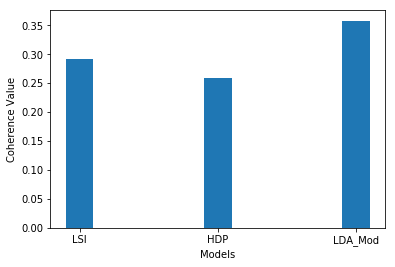

In [165]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lm_coherence],
                   ['LSI', 'HDP', 'LDA_Mod'])

## Play with CorEx Model

In [126]:
import numpy as np
import vis_topic as vt
import corex_topic as ct
import scipy.sparse as ss
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

raw_docs = [' '.join(clean_doc) for clean_doc in train_texts]

# Transform cleaned petition texts into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features = 20000, binary = True)
doc_word = vectorizer.fit_transform(raw_docs)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

vis_topic.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.frame

(4095, 20000)

In [128]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [130]:
len(words)

20000

In [131]:
# Remove all integers
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(4095, 20000)

In [132]:
%%time
# Train the CorEx topic model with 50 topics (Takes about 2 min)
ct_model = ct.Corex(n_hidden=50, words=words, max_iter=200, verbose=False, seed=None)
ct_model.fit(doc_word, words=words);

CPU times: user 3min 5s, sys: 37.3 s, total: 3min 42s
Wall time: 3min 44s


## split a topic

Here is an example that split the last topic into 2 topics.

In [325]:
%%time
# Train the CorEx topic model with 50 topics (Takes about 2 min)
seed = 2000
num_topics = 20
anchor_words = []

ct_model2 = ct.Corex(n_hidden=num_topics, words=words, max_iter=10, verbose=False, seed=seed)
ct_model2.fit(doc_word, words=words);
# Print all topics from the CorEx topic model
topics = ct_model2.get_topics()
for n in range(num_topics):
    topic_words,_ = zip(*ct_model2.get_topics(topic=n, n_words=20))
    print '{}: '.format(n) + ','.join(topic_words)
    anchor_words.append(list(topic_words))

0: governed,deriving,entitle,mankind,independence,declaration,nature,institute,park,hong,kong,movements,proclamation,addressed,korean,great,levels,htm,contaminated,proclaim
1: health,disease,care,patients,medical,research,child,cancer,children,cure,doctors,insurance,treatment,healthcare,awareness,treatments,treat,pain,patient,coverage
2: economy,tax,jobs,cost,companies,dollars,market,billion,industry,scientific,businesses,energy,costs,small,schedule,money,taxes,income,consumers,marijuana
3: impel,destructive,alter,africans,asians,powers,everybody,rapper,christie,charly,wingate,destruction,africa,rap,unusually,orchestrating,new,religion,conditions,flights
4: justice,genocide,murder,police,racist,investigation,whites,investigate,crimes,clinton,hillary,fbi,crime,anti,guilty,killed,evidence,charges,criminal,convicted
5: peacefully,withdraw,instituted,dissolve,earth,governments,consent,separate,opinions,abolish,requires,involvement,form,kidnapping,looking,basis,harsh,foods,held,properly
6: 

## use word vector to split a topic (clutser words in a topic)

In [326]:
from gensim.models import Word2Vec
wv_model = Word2Vec(train_texts, size=100, window=5, min_count=5, workers=4)

2017-12-05 13:40:02,394 : DEBUG : Fast version of gensim.models.word2vec is being used
2017-12-05 13:40:02,397 : INFO : collecting all words and their counts
2017-12-05 13:40:02,398 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-05 13:40:02,572 : INFO : collected 21403 word types from a corpus of 386062 raw words and 4095 sentences
2017-12-05 13:40:02,573 : INFO : Loading a fresh vocabulary
2017-12-05 13:40:02,616 : INFO : min_count=5 retains 7366 unique words (34% of original 21403, drops 14037)
2017-12-05 13:40:02,617 : INFO : min_count=5 leaves 361545 word corpus (93% of original 386062, drops 24517)
2017-12-05 13:40:02,661 : INFO : deleting the raw counts dictionary of 21403 items
2017-12-05 13:40:02,663 : INFO : sample=0.001 downsamples 31 most-common words
2017-12-05 13:40:02,664 : INFO : downsampling leaves estimated 301412 word corpus (83.4% of prior 361545)
2017-12-05 13:40:02,665 : INFO : estimated required memory for 7366 words and 100 dim

2017-12-05 13:40:03,474 : DEBUG : queueing job #73 (10000 words, 108 sentences) at alpha 0.01565
2017-12-05 13:40:03,482 : DEBUG : queueing job #74 (9939 words, 107 sentences) at alpha 0.01552
2017-12-05 13:40:03,492 : DEBUG : queueing job #75 (9990 words, 108 sentences) at alpha 0.01539
2017-12-05 13:40:03,499 : DEBUG : queueing job #76 (9903 words, 114 sentences) at alpha 0.01526
2017-12-05 13:40:03,508 : DEBUG : queueing job #77 (9907 words, 107 sentences) at alpha 0.01512
2017-12-05 13:40:03,516 : DEBUG : queueing job #78 (9980 words, 98 sentences) at alpha 0.01499
2017-12-05 13:40:03,526 : DEBUG : queueing job #79 (9998 words, 101 sentences) at alpha 0.01487
2017-12-05 13:40:03,535 : DEBUG : queueing job #80 (9902 words, 99 sentences) at alpha 0.01475
2017-12-05 13:40:03,543 : DEBUG : queueing job #81 (9944 words, 99 sentences) at alpha 0.01463
2017-12-05 13:40:03,552 : DEBUG : queueing job #82 (9892 words, 100 sentences) at alpha 0.01451
2017-12-05 13:40:03,558 : DEBUG : queueing

2017-12-05 13:40:04,173 : DEBUG : queueing job #157 (9887 words, 98 sentences) at alpha 0.00486
2017-12-05 13:40:04,180 : DEBUG : queueing job #158 (9910 words, 98 sentences) at alpha 0.00475
2017-12-05 13:40:04,188 : DEBUG : queueing job #159 (9917 words, 102 sentences) at alpha 0.00463
2017-12-05 13:40:04,195 : DEBUG : queueing job #160 (9970 words, 101 sentences) at alpha 0.00450
2017-12-05 13:40:04,203 : DEBUG : queueing job #161 (9954 words, 109 sentences) at alpha 0.00438
2017-12-05 13:40:04,211 : DEBUG : queueing job #162 (9947 words, 101 sentences) at alpha 0.00425
2017-12-05 13:40:04,219 : DEBUG : queueing job #163 (9943 words, 112 sentences) at alpha 0.00412
2017-12-05 13:40:04,233 : DEBUG : queueing job #164 (9885 words, 102 sentences) at alpha 0.00399
2017-12-05 13:40:04,236 : DEBUG : queueing job #165 (9988 words, 109 sentences) at alpha 0.00386
2017-12-05 13:40:04,242 : DEBUG : queueing job #166 (9980 words, 103 sentences) at alpha 0.00373
2017-12-05 13:40:04,252 : DEBUG 

In [327]:
wv_model.wv.similarity('woman', 'man')

0.96031557816698421

Split Topic 10

In [331]:
toSplitId = 10

build similarity matrix

In [333]:
def distance(word1, word2):
    return wv_model.wv.similarity(word1, word2)
 
def buildSimilarityMatrix(samples):
    numOfSamples = len(samples)
    matrix = np.zeros(shape=(numOfSamples, numOfSamples))
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            matrix[i,j] = distance(samples[i], samples[j])
    return matrix

samples = anchor_words[toSplitId]
sim_mat = buildSimilarityMatrix(samples)

categorize the words into 2 clusters

In [334]:
import numpy as np
from sklearn.cluster import SpectralClustering
num_cluster = 2
mat = np.matrix(sim_mat)
res = SpectralClustering(num_cluster).fit_predict(mat)
ll = [[] for _ in range(num_cluster)]
for i in range(len(samples)):
    idx = res[i]
    word = samples[i]
    ll[idx].append(word)

print ll

[[u'day', u'constitution', u'rights', u'amendment', u'law', u'medal', u'laws', u'award', u'holiday', u'national', u'shall'], [u'lost', u'students', u'years', u'loans', u'save', u'team', u'college', u'died', u'veterans']]


In [335]:
del anchor_words[toSplitId]
for i in range(num_cluster):
    anchor_words.insert(toSplitId, ll[i])

In [361]:
# Anchor 'education' and 'weapon' to first topic, 'drug' and 'student' to second topic, so on...
# Apparently different words are selected for one topic to demonstrate whether the anchoring works
ct_model3 = ct.Corex(n_hidden=(num_topics + num_cluster - 1), words=words, max_iter=5, verbose=False, seed=seed)
ct_model3.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);
for n in range(num_topics + num_cluster - 1):
    topic_words,_ = zip(*ct_model3.get_topics(topic=n, n_words=20))
    print '{}: '.format(n) + ','.join(topic_words)

0: independence,nature,institute,declaration,mankind,governed,deriving,entitle,park,levels,addressed,korean,proclamation,hong,kong,movements,contaminated,htm,great,korea
1: health,medical,care,treatment,research,disease,child,insurance,patients,cancer,healthcare,doctors,children,cure,coverage,awareness,pain,treatments,patient,treat
2: tax,money,dollars,cost,economy,jobs,companies,small,industry,costs,market,businesses,billion,taxes,income,energy,consumers,schedule,marijuana,scientific
3: new,conditions,powers,africa,destruction,destructive,alter,impel,everybody,africans,asians,rapper,christie,charly,wingate,rap,orchestrating,unusually,york,flights
4: justice,police,investigate,investigation,genocide,criminal,crimes,murder,racist,crime,anti,clinton,whites,fbi,convicted,charges,hillary,guilty,evidence,killed
5: form,governments,requires,peacefully,consent,abolish,withdraw,earth,separate,opinions,instituted,dissolve,involvement,looking,harsh,kidnapping,clear,basis,held,foods
6: non,existe

In [363]:
for n in range(num_topics + num_cluster - 1):
    print n,ct_model3.get_topics(topic=n, n_words=20)

0 [(u'independence', 0.060639131121382701), (u'nature', 0.05645803775139481), (u'institute', 0.052988766484768773), (u'declaration', 0.041976920304053908), (u'mankind', 0.035162602541278135), (u'governed', 0.032451253396290854), (u'deriving', 0.029748024801836092), (u'entitle', 0.029073479155456147), (u'park', 0.028399436170990618), (u'levels', 0.023025073162846701), (u'addressed', 0.019455898264881415), (u'korean', 0.011708964030983362), (u'proclamation', 0.009726488184856167), (u'hong', 0.0090666160480666023), (u'kong', 0.0090666160480666023), (u'movements', 0.0077246338080918103), (u'contaminated', 0.00577436464242587), (u'htm', 0.0054515159566944516), (u'great', 0.0029714292825232798), (u'korea', 0.0056672373249597799)]
1 [(u'health', 0.13389888113012366), (u'medical', 0.11574711951702733), (u'care', 0.096099655725198643), (u'treatment', 0.071729347519220971), (u'research', 0.069980122149989138), (u'disease', 0.055146013595459342), (u'child', 0.048480648592993954), (u'insurance', 0

14 [(u'known', 0.091463976507706726), (u'denied', 0.055320185712134727), (u'station', 0.029957940095324882), (u'assume', 0.02940221429673609), (u'september', 0.029179892827457775), (u'gay', 0.028291766586400389), (u'gender', 0.023311220929264003), (u'ground', 0.022080801596358994), (u'transgender', 0.020005707891526791), (u'notice', 0.018906489059695664), (u'lgbt', 0.018906489059695664), (u'presented', 0.017808573464143322), (u'orientation', 0.012338415659840153), (u'adopted', 0.010456030545691948), (u'aggravated', 0.0090717266583522655), (u'articles', 0.0085283929401938456), (u'labeling', 0.0062315178829385285), (u'pending', 0.0013842934203750139), (u'bisexual', 0.0069002934190255175), (u'lesbian', 0.0047339148182225892)]
15 [(u'family', 0.11335907897214317), (u'death', 0.090924969767573749), (u'old', 0.06001978887053247), (u'officers', 0.041812894235618819), (u'animal', 0.036948943947319901), (u'animals', 0.03646398334040999), (u'mother', 0.026339270598437547), (u'officer', 0.0250597

## retrvie similar documents for a document

In [350]:
from scipy import spatial

doc_id = 100
doc_vec = ct_model.p_y_given_x[doc_id].tolist()
sim_docs = []
for i in range(len(doc_complete)):
    doc_vec2 = ct_model.p_y_given_x[i].tolist()
    result = 1 - spatial.distance.cosine(doc_vec, doc_vec2)
    sim_docs.append((i, result))
sim_docs = sorted(sim_docs, key=lambda tup: -tup[1])
print sim_docs[:10]

[(100, 0.99999999999999989), (3020, 0.80601369890283303), (549, 0.80059361911652216), (581, 0.77857236430729626), (184, 0.73749816019210501), (2126, 0.72679524010868501), (2069, 0.69534194225612522), (2236, 0.68424216880906885), (4016, 0.67231458926175069), (3159, 0.67186071929127866)]


In [360]:
print doc_complete[3159]['title']

Allocate more federal funding towards the testing and usage of "rape kits" and set a mandated deadline for their testing


In [348]:
# The estimated probabilities of topics for each document
print ct_model.p_y_given_x.shape

(4095, 50)


In [158]:
# print the topics assigned to document 0 with a threshold set to 0.01
print doc_complete[0]['title']
doc_topics = ct_model.p_y_given_x[0]
for idx, doc_topic in enumerate(doc_topics):
    if (doc_topic > 0.01):
        print(idx, "%.2f" % doc_topic)

Grant voters the ability to vote for the President of the United States by dissolving the electoral college.
(2, '1.00')
(11, '1.00')
(19, '1.00')
(24, '1.00')
(33, '1.00')
(34, '1.00')
(35, '0.58')
(39, '0.18')
(41, '0.06')
(44, '0.01')
(46, '0.01')
(48, '0.02')
(49, '0.23')


In [161]:
print ct_model.labels[0]

[False False  True False False False False False False False False  True
 False False False False False False False  True False False False False
  True False False False False False False False False  True  True  True
 False False False False False False False False False False False False
 False False]


In [203]:
print len(ct_model.clusters)

20000


In [200]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_topics = 50
pca = PCA(n_components=num_topics)
fiftyDimVecs = pca.fit_transform([doc_vec for doc_vec in ct_model.p_y_given_x])
tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform(fiftyDimVecs)

In [201]:
twoDimVecs

array([[ 10.92,  48.76],
       [ 29.79, -10.22],
       [ 17.74, -58.66],
       ..., 
       [ -3.3 ,  21.96],
       [-14.36, -37.32],
       [-19.33, -14.98]], dtype=float32)

## Selecting number of topics

One way to choose topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly add to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

Text(0,0.5,u'Total Correlation (nats)')

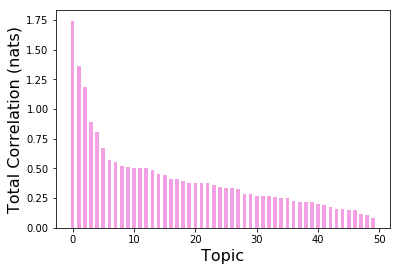

In [279]:
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color = '#f29fe4', width = 0.6)
plt.xlabel('Topic', fontsize = 16)
plt.ylabel('Total Correlation (nats)', fontsize = 16)

## Compare CorEx with previous models

In [198]:
cttopics = []
for i in range(50):
    _words = ct_model.get_topics(topic=i)
    cttopics.append((i, _words))

In [199]:
_cttopics = [[word for word, prob in topic] for topicid, topic in cttopics]

In [197]:
# print dictionary.token2id['genocide']
ct_coherence = CoherenceModel(topics=_cttopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
print(ct_coherence)

2017-12-04 16:10:16,843 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2017-12-04 16:10:16,903 : INFO : 1 batches submitted to accumulate stats from 64 documents (6126 virtual)
2017-12-04 16:10:16,916 : INFO : 2 batches submitted to accumulate stats from 128 documents (11939 virtual)
2017-12-04 16:10:16,926 : INFO : 3 batches submitted to accumulate stats from 192 documents (18013 virtual)
2017-12-04 16:10:16,936 : INFO : 4 batches submitted to accumulate stats from 256 documents (24012 virtual)
2017-12-04 16:10:16,949 : INFO : 5 batches submitted to accumulate stats from 320 documents (29904 virtual)
2017-12-04 16:10:16,957 : INFO : 6 batches submitted to accumulate stats from 384 documents (35760 virtual)
2017-12-04 16:10:16,969 : INFO : 7 batches submitted to accumulate stats from 448 documents (42285 virtual)
2017-12-04 16:10:16,991 : INFO : 8 batches submitted to accumulate stats from 512 documents (48306

2017-12-04 16:10:18,339 : DEBUG : completed batch 4; 320 documents processed (29217 virtual)
2017-12-04 16:10:18,341 : INFO : 47 batches submitted to accumulate stats from 3008 documents (271528 virtual)
2017-12-04 16:10:18,399 : DEBUG : completed batch 4; 320 documents processed (29189 virtual)
2017-12-04 16:10:18,459 : DEBUG : completed batch 5; 384 documents processed (33783 virtual)
2017-12-04 16:10:18,487 : DEBUG : completed batch 5; 384 documents processed (35643 virtual)
2017-12-04 16:10:18,491 : DEBUG : completed batch 5; 384 documents processed (33642 virtual)
2017-12-04 16:10:18,524 : DEBUG : completed batch 5; 384 documents processed (34991 virtual)
2017-12-04 16:10:18,547 : DEBUG : completed batch 5; 384 documents processed (35063 virtual)
2017-12-04 16:10:18,585 : DEBUG : completed batch 5; 384 documents processed (35662 virtual)
2017-12-04 16:10:18,609 : DEBUG : observed sentinel value; terminating
2017-12-04 16:10:18,632 : DEBUG : finished all batches; 384 documents proc

0.493209102528


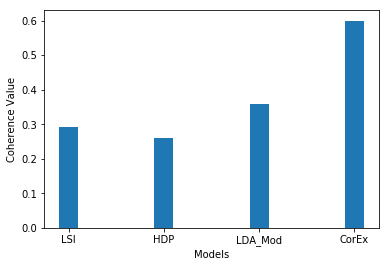

In [275]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lm_coherence, ct_coherence],
                   ['LSI', 'HDP', 'LDA_Mod', 'CorEx'])

CorEx appears to perform better in terms of Coherence Value.

## Hierarchical Topic Models

In [276]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=8) #8 high-level topics
tm_layer2.fit(ct_model.labels);

In [277]:
vt.vis_hierarchy([ct_model, tm_layer2], max_edges=200, column_label=words, prefix='htopic-2layer')

weight threshold is 0.000000 for graph with max of 200.000000 edges 
('non-isolated nodes,edges', 58, 162)
('non-isolated nodes,edges', 58, 50)


The resulting plot appears to be (8) clusters of topics:

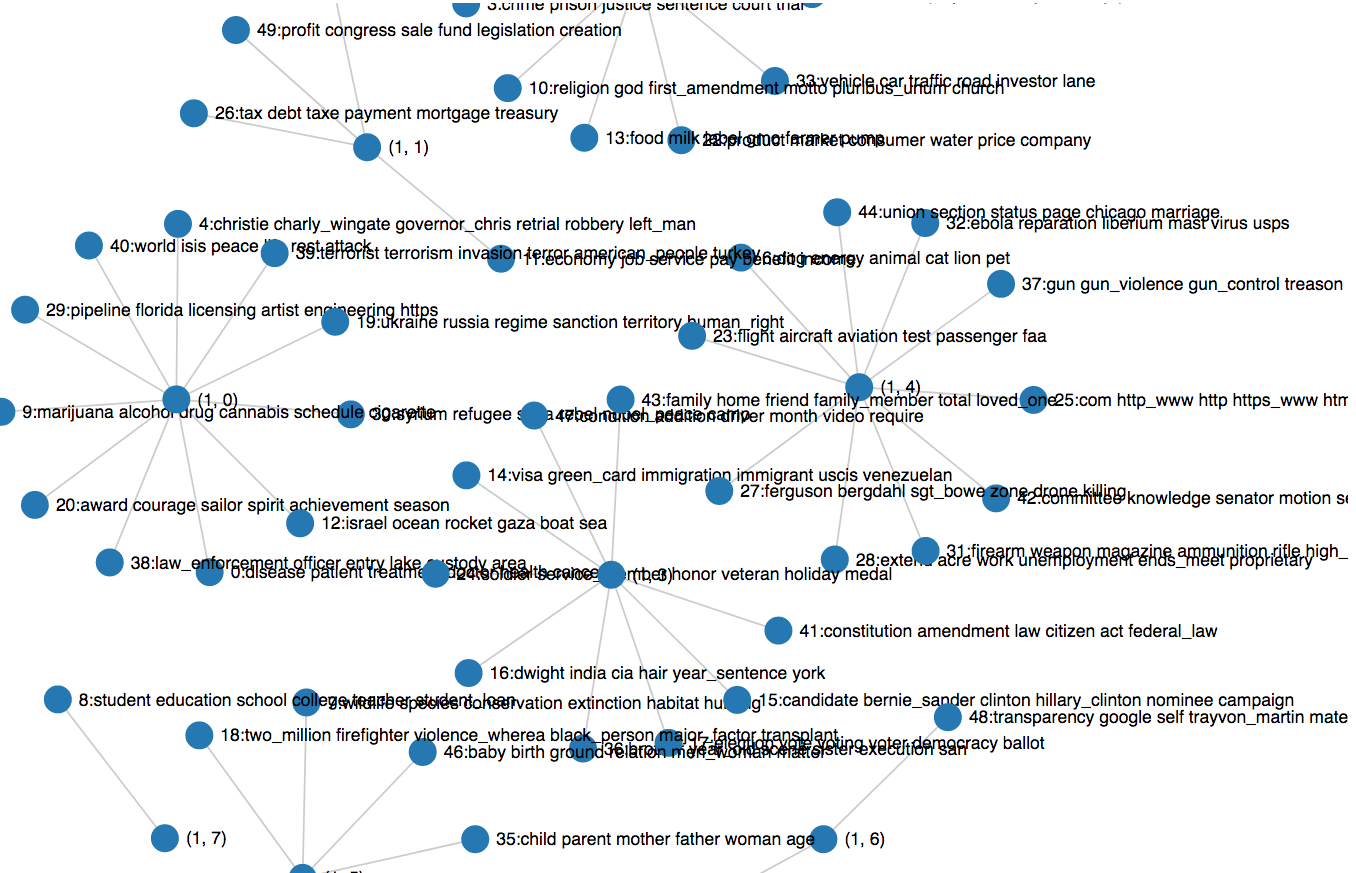

For example: in cluster (1,0), topic 40 (isis, peace), topic 39 (terrorist), topic 19 (ukraine) and topic 12 (israel) are grouped together. By wisely choosing the number of first level topics, it should make more sense.

## Anchoring for Semi-Supervised Topic Modeling

In [244]:
# Anchor 'education' and 'weapon' to first topic, 'drug' and 'student' to second topic, so on...
# Apparently different words are selected for one topic to demonstrate whether the anchoring works
anchor_words = [['education', 'weapon'], ['drug', 'student'], ['white', 'immigration']]
r
anchored_topic_model = ct.Corex(n_hidden=50)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [247]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print '{}: '.format(n) + ','.join(topic_words)

0: education,weapon,tuition,educational,higher,curriculum,edmc,deductible,forprofit,mentoring
1: student,drug,marijuana,cannabis,school,substance,loan,schedule,teacher,prohibition
2: white,immigration,house,antiwhite,antiracist,genocide,blended,nonwhites,assimilate,intermarry
